In [1]:
import pandas as pd
import psycopg2
import pandas.io.sql as psql
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold, cross_val_predict, cross_validate
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, mutual_info_score
from collections import OrderedDict
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
import matplotlib.cm as cm
import time
import scipy.sparse
import seaborn as sns
import lightgbm as lgbm
import category_encoders as ce
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Normalizer
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, clone_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Concatenate, Input, Dropout, Bidirectional, concatenate
from tensorflow.keras.layers import Reshape, Flatten, MultiHeadAttention, Attention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.backend import clear_session
from shapely.geometry import Polygon, box
from scipy.sparse import hstack, vstack
import os.path
from tensorflow.keras.optimizers import Adam
import pickle
from scipy import sparse
from tensorflow.keras.losses import CategoricalCrossentropy
from spektral.data.loaders import SingleLoader, MixedLoader
from spektral.datasets.citation import Citation
from spektral.layers import GCNConv, GlobalSumPool, ChebConv
from spektral.models.gcn import GCN
from spektral.transforms import LayerPreprocess
from spektral.data import Dataset, DisjointLoader, Graph
from tensorflow.keras.regularizers import l2
from sklearn.base import clone
#from scikeras.wrappers import KerasClassifier
import stellargraph as sg
from io import BytesIO
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import networkx as nx
from collections import Counter
from pecanpy import node2vec
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest, SelectFromModel, SelectFpr, SelectFdr
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.cluster import contingency_matrix
import multiprocessing
import tensorflow_addons as tfa
import matplotlib.patches as mpatches
import colorcet as cc
from matplotlib.lines import Line2D
from matplotlib import ticker
from openTSNE import TSNE
from sklearn.utils import class_weight
from nltk.tokenize import TweetTokenizer

import os
os.environ["METIS_DLL"] = '/usr/local/lib/libmetis.so'

import metis
#metis.part_graph(vector_of_mentions_local.tolil(), 10)

tf.random.set_seed(seed=0)

unTPath = "../../../../../unT/ffunes/"
gcnPath = "../../../gcn_input/"
tmp_save = unTPath + "tmp_saves/"
figuresPath = unTPath + "figures/"

%matplotlib inline

sns.set_theme()

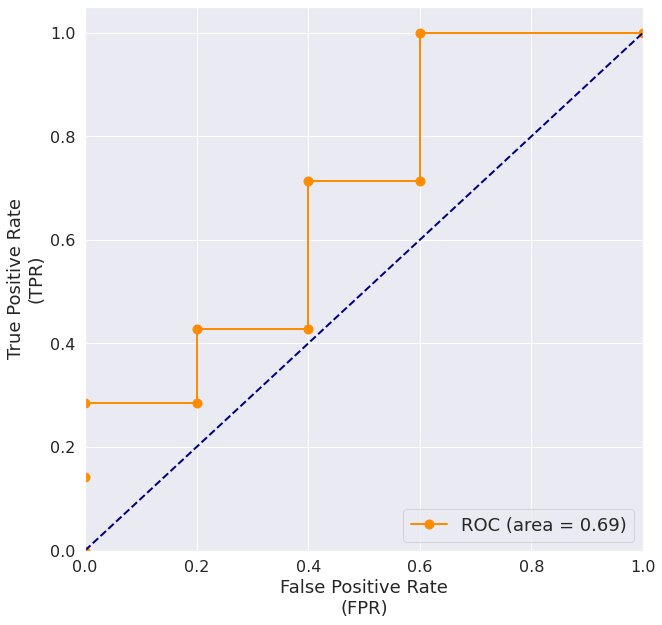

In [2]:
from sklearn.metrics import roc_curve, auc
unTPath = "../../../../../unT/ffunes/"
figuresPath = unTPath + "figures/"
labels = [1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0]
scores = [0.9, 0.8, 0.75, 0.7, 0.65, 0.62, 0.60, 0.50, 0.4, 0.38, 0.2, 0.1]

#y_test = [[1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1]]

fpr, tpr, _ = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

f, ax = plt.subplots(figsize=(10, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange', marker='o', markersize=9,
         lw=lw, label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.xlabel('False Positive Rate\n(FPR)', fontsize=18)
plt.ylabel('True Positive Rate\n(TPR)', fontsize=18)
plt.legend(loc="lower right", fontsize=18)
plt.show()

f.savefig(figuresPath + 'mentions/example_roc.pdf', bbox_inches = 'tight')

# Definicion de metricas y utilidades

In [3]:
'''colnames = [
    "city_name",
    "latitude",
    "longitude",
    "country"
]

geonames = pd.read_csv(unTPath + "geonames/geonames_parsed.csv", usecols=colnames)'''

from math import radians, sin, cos, atan2, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # km

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) \
        * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

def determine_distance(row):
    predicted_lat = row['predicted_lat']
    predicted_lon = row['predicted_lon']
    real_lat = row['real_lat']
    real_long = row['real_lon']
    
    return haversine_distance(predicted_lat, predicted_lon, real_lat, real_long)

def get_difference_distance(real_place, predicted_place, places_with_coords):    
    df_prediction = pd.DataFrame({
        'predicted_place': predicted_place,
        #'real_place': real_place,
        'real_lat': real_place[:,0],
        'real_lon': real_place[:,1]
    })#, dtype={'str'})
        
    df_prediction = df_prediction.astype({'predicted_place': str, 'real_lat': np.float64, 'real_lon': np.float64})
        
    df_prediction = pd.merge(
        left=df_prediction,
        right=places_with_coords,
        how='inner',
        left_on='predicted_place',
        right_on='class',
        #validate='m:1'
    ).rename(columns={'latitude': 'predicted_lat', 'longitude': 'predicted_lon'})
        
    '''df_prediction = pd.merge(
        left=df_prediction,
        right=places_with_coords,
        how='inner',
        left_on='real_place',
        right_on='class',
        #validate='m:1'
    ).rename(columns={'latitude': 'real_lat', 'longitude': 'real_lon'})    '''
        
    return df_prediction.apply(determine_distance, axis=1)

def accuracy_161km(real_place, pred_place, places_with_coords):
    dif_distance = get_difference_distance(real_place, pred_place, places_with_coords)
    
    total_positives = 0
    
    for val in dif_distance:
        if val <= 161:
            total_positives += 1

    return total_positives / len(dif_distance)

In [4]:
from math import log2

def secure_log2(v):
    try:
        return log2(v)
    except:
        return 0

def mutinfo(t, c, total_freq, Freq_terms, P_terms, P_cities, Freq_terms_cities, P_terms_cities, total_terms_cities):
    t_c = P_terms_cities[c].item(t) * secure_log2(P_terms_cities[c].item(t)/(P_terms.item(t) * P_cities[c]))
        
    P_t_nc = (Freq_terms.item(t) - Freq_terms_cities[c].item(t)) / total_freq
    
    t_nc = P_t_nc * secure_log2(P_t_nc / (P_terms.item(t) * (1 - P_cities[c])))
    
    P_nt_c = (total_terms_cities[c] - Freq_terms_cities[c].item(t)) / total_freq
    
    nt_c = P_nt_c * secure_log2(P_nt_c / ((1 - P_terms.item(t)) * P_cities[c]))
    
    P_nt_nc = ((total_freq - Freq_terms.item(t)) - (total_terms_cities[c] - Freq_terms_cities[c].item(t))) / total_freq
    
    nt_nc = P_nt_nc * secure_log2(P_nt_nc / ((1 - P_terms.item(t)) * (1 - P_cities[c])))
    
    return t_c + t_nc + nt_c + nt_nc

In [5]:
def mutual_info_city(X, city, vocab, cities, total_freq, Freq_terms, P_terms, P_cities, Freq_terms_cities, P_terms_cities, total_terms_cities):
    params = []

    for i in range(X.shape[1]):
        params.append((i, city, total_freq, Freq_terms, P_terms, P_cities, Freq_terms_cities, P_terms_cities, total_terms_cities))
        
    PROCESSES = 8

    mutinfos = {}

    with multiprocessing.Pool(PROCESSES) as pool:
        results = [pool.apply(mutinfo, p) for p in params]
    
    #print("Cal")
    
    #for i in range(len(results)):
    #    mutinfos[vectorizer.get_feature_names()[i]] = results[i]
    
    df = pd.DataFrame(data={"feature": vocab, "mi": results})
    
    return df

In [6]:
def mutual_info_city(X, city, vocab, cities, total_freq, Freq_terms, P_terms, P_cities, Freq_terms_cities, P_terms_cities, total_terms_cities):
    results = []
    
    for i in range(X.shape[1]):
        results.append(
            mutinfo(i, city, total_freq, Freq_terms, P_terms, P_cities, Freq_terms_cities, P_terms_cities, total_terms_cities)
        )

    df = pd.DataFrame(data={"feature": vocab, "mi": results})
    
    return df

In [7]:
class Fold:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
    def unpack(self, val_split=None, random_state=40):
        if val_split:
            sss = StratifiedShuffleSplit(n_splits=1, test_size=val_split, random_state=random_state)
                                
            for train_ix, val_ix in sss.split(self.X_train, self.y_train):
                X_train_ = self.X_train.iloc[train_ix]
                X_val = self.X_train.iloc[val_ix]
                    
                y_train_, y_val = self.y_train[train_ix], self.y_train[val_ix]
                    
                return X_train_, y_train_, X_val, y_val, self.X_test, self.y_test
        
        return self.X_train, self.y_train, self.X_test, self.y_test

In [8]:
class FoldGen:
    def create_folds(self, X, y, outer_cv=5, random_state=40):
        outer_cv_fold = StratifiedKFold(n_splits=outer_cv, shuffle=True, random_state=random_state)

        folds = []    
        test_idx = np.array([])

        for train_ix, test_ix in outer_cv_fold.split(X, y):
            X_train = X.iloc[train_ix]
            X_test = X.iloc[test_ix]

            y_train, y_test = y[train_ix], y[test_ix]

            folds.append(Fold(X_train, y_train, X_test, y_test))

            test_idx = np.concatenate([test_idx, test_ix])

        return folds, test_idx

In [9]:
class CrossValidator:
    def __init__(self, name, encoder=None):
        self.name = name
        self.encoder = encoder
            
    #def classifier(self):
        #return clone(self.clf)
    
    def classes_order(self):
        if self.encoder:
            return self.encoder.classes_
        
        return self.classes_
            
    def predict_proba(self, clf, X):
        return clf.predict_proba(X)
    
    '''def cross_score(self, X, y, scoring, outer_cv=5, n_jobs=-1):
        return cross_validate(
            self.classifier(),
            X=X[0] if len(X) == 1 else X,
            y=y if self.encoder is None else encoder.transform(y),
            cv=outer_cv,
            n_jobs=n_jobs,
            scoring=scoring,
            verbose=2
        )'''
            
    def cross_predict(
            self, folds, test_idx, outer_cv=5, predict_proba=True, random_state=40, preprocess=None, *args, **kwargs
        ):
        results = None
        
        for fold in folds:
            if self.encoder:
                X_train, y_train, X_test, y_test = fold.unpack()
                
                if self.encoder:
                    self.encoder.fit(y_train)
                
                    y_train = self.encoder.transform(y_train)
                    y_test = self.encoder.transform(y_test)                    
                
                fold = Fold(X_train, y_train, X_test, y_test)
                
            #if preprocess is not None:
            #    fold = preprocess(fold)
            
            if preprocess is not None:
                clf, X_test = preprocess(fold)
            
            #clf = self.classifier()
                
            #if len(fold) == 6:
            #    X_train, y_train, X_val, y_val, X_test, y_test = fold
                
            #    clf.fit(X_train, y_train, validation_data=(X_val, y_val), **kwargs)
            #else:
            #    X_train, y_train, X_test, y_test = fold                
                    
            #    clf.fit(X_train, y_train, **kwargs)     
            
            try:
                self.classes_ = clf.classes_
            except:
                pass
            
            # Print best params when searching for best params
            try:
                print("Best params: ", clf.best_params_)
            except:
                pass
                        
            y_pred = self.predict_proba(clf, X_test)
    
            if not predict_proba:
                y_pred = np.array([self.classes_order()[x] for x in np.argmax(y_pred, axis=1)])
            
            if results is None:
                results = y_pred
            else:
                results = np.concatenate((results, y_pred))
            
        preds = results[test_idx.argsort()]

        return preds
    
class KerasCrossValidator(CrossValidator):
    #def classifier(self):
        #return self.clf()
    
    def predict_proba(self, clf, X):
        return clf.predict(X).squeeze()
    
class GCNCrossValidator(CrossValidator):
    #def classifier(self):
        #return self.clf()
    
    def predict_proba(self, clf, X):
        return clf.predict(X).squeeze()

In [10]:
'''class CrossValidator:
    def __init__(self, name, clf, encoder=None):
        self.name = name
        self.clf = clf
        self.encoder = encoder
        
        self.classes_ = None
    
    def classifier(self):
        return clone(self.clf)
    
    def classes_order(self):
        if self.encoder:
            return self.encoder.classes_
        
        return self.classes_
            
    def predict_proba(self, clf, X):
        return clf.predict_proba(X)
    
    def cross_score(self, X, y, scoring, outer_cv=5, n_jobs=-1):
        return cross_validate(
            self.classifier(),
            X=X[0] if len(X) == 1 else X,
            y=y if self.encoder is None else encoder.transform(y),
            cv=outer_cv,
            n_jobs=n_jobs,
            scoring=scoring,
            verbose=2
        )
    
    def create_strats(self, X, y, val_split=None, outer_cv=5, random_state=40):
        outer_cv_fold = StratifiedKFold(n_splits=outer_cv, shuffle=True, random_state=random_state)
        
        data_divided = []
        test_idx = np.array([])
        
        for train_ix, test_ix in outer_cv_fold.split(X[0], y):
            X_train = []
            X_test = []
            
            for i in range(len(X)):
                X_train.append(
                    X[i][train_ix]
                )

                X_test.append(
                    X[i][test_ix]
                )
            
            y_train, y_test = y[train_ix], y[test_ix]
            
            if val_split is not None:
                sss = StratifiedShuffleSplit(n_splits=1, test_size=val_split, random_state=random_state)
                                
                for train_ix, val_ix in sss.split(X_train[0], y_train):
                    X_train_ = []
                    X_val = []
                    
                    y_train_, y_val = y_train[train_ix], y_train[val_ix]
                    
                    for i in range(len(X_train)):
                        X_train_.append(
                            X_train[i][train_ix]
                        )

                        X_val.append(
                            X_train[i][val_ix]
                        )
                        
                    #data_divided.append([X_train_, X_test, X_val, y_train_, y_test, y_val])
                    data_divided.append([X_train_, y_train_, X_val, y_val, X_test, y_test])
            else:
                #data_divided.append([X_train, X_test, y_train, y_test])
                data_divided.append([X_train, y_train, X_test, y_test])
                
            test_idx = np.concatenate([test_idx, test_ix])
            
        return data_divided, test_idx
    
    def apply_generators(self, generators, X, y=None):
        if generators is not None: 
            for idx, generator in zip(range(len(X)), generators):
                if generator is None:
                    continue

                if y is None:
                    X[idx] = generator.flow(X[idx])
                else:        
                    flow = generator.flow(X[idx], y)
                    X[idx], y = flow[0]

        if y is None:
            return X
        
        return X, y
    
    def apply_to_folds(self, fold, with_val, generators):
        total_strats = 6 if with_val else 4
        
        i = 0
        
        while i < total_strats:
            X = fold[i]
            y = fold[i+1]
            
            if self.encoder:
                y = self.encoder.transform(y)
                
            if i >= total_strats - 2:
                X = self.apply_generators(generators, X)       
            else:
                X, y = self.apply_generators(generators, X, y)

            fold[i] = X
            fold[i+1] = y
            
            i += 2
        
        return fold
            
    def cross_predict(
            self, X, y, val_split=None, outer_cv=5, predict_proba=True, random_state=40,
            generators=None, *args, **kwargs
        ):
        results = None
        
        if self.encoder:
            self.encoder.fit(y)
            
        data_div, test_idx = self.create_strats(X, y, val_split, outer_cv, random_state)
        
        for fold in data_div:            
            fold = self.apply_to_folds(fold, val_split is not None, generators)
            
            clf = self.classifier()
                
            if val_split:
                X_train, y_train, X_val, y_val, X_test, y_test = fold
                
                if len(X_train) == 1:
                    X_train = X_train[0]
                    X_val = X_val[0]
                    X_test = X_test[0]
                    
                clf.fit(X_train, y_train, validation_data=(X_val, y_val), **kwargs)   
            else:
                X_train, y_train, X_test, y_test = fold

                if len(X_train) == 1:
                    X_train = X_train[0]
                    X_test = X_test[0]
                    
                clf.fit(X_train, y_train, **kwargs)     
            
            try:
                self.classes_ = clf.classes_
            except:
                pass
            
            # Print best params when searching for best params
            try:
                print("Best params: ", clf.best_params_)
            except:
                pass
                        
            y_pred = self.predict_proba(clf, X_test)
    
            if not predict_proba:
                y_pred = np.array([self.classes_order()[x] for x in np.argmax(y_pred, axis=1)])
            
            if results is None:
                results = y_pred
            else:
                results = np.concatenate((results, y_pred))
            
        preds = results[test_idx.argsort()]

        return preds'''
    
    '''def cross_predict(
            self, X, y, val_split=None, outer_cv=5, predict_proba=True, random_state=40,
            generators=None, *args, **kwargs
        ):
        results = None
        
        if self.encoder:
            self.encoder.fit(y)
            
        data_div, test_idx = self.create_strats(X, y, val_split, outer_cv, random_state)
        
        for fold in data_div:
            clf = self.classifier()
            
            if val_split:
                X_train, X_test, X_val, y_train, y_test, y_val = fold
                
                if self.encoder:
                    y_train = encoder.transform(y_train)
                    y_val = encoder.transform(y_val)
                    y_test = encoder.transform(y_test)
                    
                if generators:
                    for idx, generator in zip(range(len(X)), generators):
                        if generator is None:
                            continue
                            
                        flow_train = generator.flow(X_train[idx], y_train)
                        X_train[idx], y_train = flow_train[0]
                                                    
                        flow_val = generator.flow(X_val[idx], y_val)
                        X_val[idx], y_val = flow_val[0]
                            
                        X_test[idx] = generator.flow(X_test[idx])
                
                if len(X) == 1:
                    X_train = X_train[0]
                    X_val = X_val[0]
                    X_test = X_test[0]
                    
                clf.fit(X_train, y_train, validation_data=(X_val, y_val), **kwargs)   
            else:
                X_train, X_test, y_train, y_test = fold
                
                if self.encoder:
                    y_train = encoder.transform(y_train)
                    y_test = encoder.transform(y_test)                  
                    
                if generators:
                    for idx, generator in zip(range(len(X)), generators):
                        if generator is None:
                            continue
                            
                        flow_train = generator.flow(X_train[idx], y_train)
                                                
                        X_train[idx], y_train = flow_train[0]
                        
                        X_test[idx] = generator.flow(X_test[idx])
                        
                if len(X) == 1:
                    X_train = X_train[0]
                    X_test = X_test[0]
                    
                clf.fit(X_train, y_train, **kwargs)     
            
            try:
                self.classes_ = clf.classes_
            except:
                pass
            
            # Print best params when searching for best params
            try:
                print("Best params: ", clf.best_params_)
            except:
                pass
            
            y_pred = self.predict_proba(clf, X_test)
    
            if not predict_proba:
                y_pred = np.array([self.classes_order()[x] for x in np.argmax(y_pred, axis=1)])
            
            if results is None:
                results = y_pred
            else:
                results = np.concatenate((results, y_pred))
            
        preds = results[test_idx.argsort()]

        return preds'''
    
'''class GCNCrossValidator(CrossValidator):
    def classifier(self):
        return self.clf()
    
    def predict_proba(self, clf, X):
        return clf.predict(X).squeeze()'''

IndentationError: unexpected indent (<ipython-input-10-8d81a84c2062>, line 181)

In [10]:
def get_all_metrics(y_true, y_pred, classes_order, places_with_coords, users_coords):
    y_true_ = np.array([classes_order[x] for x in np.argmax(y_true, axis=1)])
    y_pred_ = np.array([classes_order[x] for x in np.argmax(y_pred, axis=1)])
    
    acc = accuracy_score(y_true_, y_pred_)
    acc_161 = accuracy_161km(users_coords, y_pred_, places_with_coords)
    bal_acc = balanced_accuracy_score(y_true_, y_pred_)
    roc_auc_ovo = roc_auc_score(y_true, y_pred, average='weighted', multi_class='ovo')
        
    diffs_distance = get_difference_distance(users_coords, y_pred_, places_with_coords)
    
    #diffs_distance_ge_zero = [dist for dist in diffs_distance if dist > 0]
        
    return "Accuracy: {}\
        \nAcc@161: {}\
        \nBalanced Acc: {}\
        \nROC AUC Ovo: {}\
        \nMean Dist Err: {}\
        \nMedian Dist Err: {}".format(
        acc, acc_161, bal_acc, roc_auc_ovo, np.mean(diffs_distance), np.median(diffs_distance)
    )

# Infomap parse

In [11]:
def extract_infomap(filename):
    """Funcion que extrae las comunidades detectadas por INFOMAP a las que pertence un vertice de la red."""
    colnames = [
        "node_id", "module", "flow"
    ]
    
    dtypes = {
        "node_id": np.int64,
        "module": np.int64,
        "flow": np.float64
    }
    
    df = pd.read_csv(filename, comment="#", names=colnames, dtype=dtypes, sep=" ")
    
    #df = df.sort_values("flow", ascending=False).drop_duplicates("node_id", keep='first')
    
    del df["flow"]
    
    df = df.groupby(
        ["node_id"]
    )['module'].apply(list).reset_index(name='modules')
    
    return df

# Oslom parse

In [12]:
def extract_oslom(filename):
    """Funcion que extrae las comunidades detectadas por OSLOM a las que pertence un vertice de la red."""
    #clusters = {}
    #hashtag_clusters = {}
    data = []
    
    clusters = []
    
    with open(filename) as f:
        cluster = ""
        for line in f:
            m = re.search("^#module\s([0-9]+).*", line)
            #print line
            if (m is not None):
                cluster = int(m.group(1))
            else:
                l = line.replace('\n', ' ').strip().split(" ")
                l = list(map(int, l))
                
                clusters.append(cluster)
                #clusters[cluster] = l
                for i in l:
                    #if not i in hashtag_clusters:
                    #    hashtag_clusters[i] = set()
                    #hashtag_clusters[i].add(cluster)
                    data.append([i, cluster])
    return pd.DataFrame(data=data, columns=["id", "cluster"]), clusters

In [13]:
def extract_all_oslom(folder):
    basename = 'tp'
    
    all_clusters = {}
    
    train, clusters = extract_oslom(folder + basename)
    
    all_clusters[0] = clusters
    
    train = train.groupby(
        ["id"]
    )['cluster'].apply(list).reset_index(name='clusters')
    
    level = 1
    
    while os.path.isfile(folder + basename + str(level)):
        l_train, l_clusters = extract_oslom(folder + basename + str(level))
        
        l_train = l_train.groupby(
            ["id"]
        )['cluster'].apply(list).reset_index(name='clusters_' + str(level))
        
        train = pd.merge(
            left=train,
            right=l_train,
            how='left',
            validate='1:1'
        )
        
        all_clusters[level] = l_clusters
        
        level += 1
    
    return train, all_clusters

# KD-Trees

In [14]:
class Node:
    def __init__(self, value, left, right):
        self.value = value
        self.left = left
        self.right = right
        
def kdtree(points, depth=0, k=2, min_samples=20):
    if len(points) <= min_samples:
        return None
    
    axis = depth % k

    median = np.median(points[:, axis])
    
    print("Depth: ", depth, "Total points: ", len(points), "Median: ", median)

    try:
        print("Equal: ", points[points[:, axis] == median][0][0])
        print("Equal: ", points[points[:, axis] == median][1][0])
        print("Equal: ", points[points[:, axis] == median][2][0])
        print("Equal: ", points[points[:, axis] == median][3][0])
        print("Equal: ", points[points[:, axis] == median][4][0])
    except:
        pass
    return Node(
        value=median,
        right=kdtree(points[points[:, axis] < median], depth=depth + 1),
        left=kdtree(points[points[:, axis] >= median], depth=depth + 1)
    )

def kdtree_class_gen(df, min_samples_split=2):
    idxs = users_train_final.index.to_numpy()
    points = users_train_final[["longitude", "latitude"]].to_numpy().astype(np.longdouble)
    
    total_nodes = [[kdtree(points), points, idxs]]
    final_leaves = []
        
    samples_per_leaf = df.shape[0]
    axis = 0
    
    while samples_per_leaf >= min_samples_split:
        new_total_nodes = []
        
        for node, points, idxs in total_nodes:
            left_p = points[points[:, axis] < node.value]
            right_p = points[points[:, axis] >= node.value]

            left_idxs = idxs[points[:, axis] < node.value]
            right_idxs = idxs[points[:, axis] >= node.value]
            
            new_total_nodes.append([node.left, left_p, left_idxs])
            new_total_nodes.append([node.right, right_p, right_idxs])
            
        total_nodes = new_total_nodes
        
        axis = (axis + 1) % 2
        samples_per_leaf //= 2
        
    i = 0
    for node, points, idxs in total_nodes:
        df.loc[idxs, 'class'] = i
        print(len(points))
        final_leaves.append({
            "x_min": np.min(points[:, 0]),
            "x_max": np.max(points[:, 0]),
            "y_min": np.min(points[:, 1]),
            "y_max": np.max(points[:, 1]),
            "points": len(points),
            'x_med_points': np.median(df.loc[idxs, ["longitude"]]),
            'y_med_points': np.median(df.loc[idxs, ["latitude"]]),
            'x_cent_points': np.sum(df.loc[idxs, ["longitude"]].values)/len(idxs),
            'y_cent_points': np.sum(df.loc[idxs, ["latitude"]].values)/len(idxs),
            'class': i
        })
        
    return final_leaves

In [15]:
def kdtree_class_gen(df, min_samples_split=2):
    latitudes = df.latitude.to_numpy().astype(np.longdouble)
    longitudes = df.longitude.to_numpy().astype(np.longdouble)
    indexes = df.index.values
    
    i = 0

    leaves = {str(i): [longitudes, latitudes, indexes]}
    final_leaves = []

    #next_split_axis = 0 # X Axis

    finished = False

    while not finished:
        split_ocurred = False

        for leaf_id, coords in list(leaves.items()):
            dif_lon = np.max(coords[0]) - np.min(coords[0])
            dif_lat = np.max(coords[1]) - np.min(coords[1])
                            
            next_split_axis = 1 if dif_lat > dif_lon else 0
            
            median_val = np.median(coords[next_split_axis])
                
            l_split = [
                i for i, x in enumerate(coords[next_split_axis]) if x <= median_val
            ]

            r_split = [
                i for i, x in enumerate(coords[next_split_axis]) if x > median_val
            ]
            
            if len(l_split) >= min_samples_split and len(r_split) >= min_samples_split:                                
                main_axis_l = [coords[next_split_axis][x] for x in l_split]
                other_axis_l = [coords[(next_split_axis + 1) % 2][x] for x in l_split]
                
                main_axis_r = [coords[next_split_axis][x] for x in r_split]
                other_axis_r = [coords[(next_split_axis + 1) % 2][x] for x in r_split]
                
                if (next_split_axis == 0):
                    leaves[str(i+1)] = [
                        main_axis_l,
                        other_axis_l,
                        [coords[2][x] for x in l_split]
                    ]

                    leaves[str(i+2)] = [
                        main_axis_r,
                        other_axis_r,
                        [coords[2][x] for x in r_split]
                    ]
                else:
                    leaves[str(i+1)] = [
                        other_axis_l,
                        main_axis_l,
                        [coords[2][x] for x in l_split]
                    ]

                    leaves[str(i+2)] = [
                        other_axis_r,
                        main_axis_r,
                        [coords[2][x] for x in r_split]
                    ]
                
                del leaves[leaf_id]
                i += 2
                split_ocurred = True
            else:
                df.loc[coords[2], 'class'] = len(final_leaves)
                
                final_leaves.append({
                    "x_min": np.min(coords[0]),
                    "x_max": np.max(coords[0]),
                    "y_min": np.min(coords[1]),
                    "y_max": np.max(coords[1]),
                    "points": len(coords[0]),
                    'x_med_points': np.median(df.loc[coords[2], ["longitude"]]),
                    'y_med_points': np.median(df.loc[coords[2], ["latitude"]]),
                    'x_cent_points': np.sum(df.loc[coords[2], ["longitude"]].values)/len(coords[2]),
                    'y_cent_points': np.sum(df.loc[coords[2], ["latitude"]].values)/len(coords[2]),
                    'class': int(len(final_leaves))
                })

                del leaves[leaf_id]
        
        if split_ocurred:
            pass
            #next_split_axis = (next_split_axis + 1) % 2
        else:
            finished = True
    
    return final_leaves

# Lectura de datos

In [16]:
users = pd.read_pickle(unTPath + 'exact/users_exact_coords.pkl')
users_with_mentions = pd.read_pickle(unTPath + "exact/users_exact_mentions.pkl")
users_with_followers = pd.read_pickle(unTPath + "exact/users_exact_followers.pkl")
users_with_content = pd.read_pickle(unTPath + "exact/users_exact_content.pkl")
#users_with_content = pd.read_pickle(unTPath + "exact/users_exact_content_filtered.pkl")

users_train = pd.merge(
    left=users,
    right=users_with_mentions.loc[:, ["id", "users_mentioned"]],
    how='left',
    validate='1:1',
    on='id'
)

users_train = pd.merge(
    left=users_train,
    right=users_with_followers.loc[:, ["id", "users_followed", "users_followers"]],
    how='left',
    validate='1:1',
    on='id'
)

users_train = pd.merge(
    left=users_train,
    right=users_with_content.loc[:, ["id", "all_tweets", "hashtags"]],
    how='left',
    validate='1:1',
    on="id"
)

users_train.shape

(37146, 26)

In [17]:
#users_train["unified_place"] = users_train["place_name"] + "," + users_train["place_country"]

In [18]:
#d = users_train.groupby("unified_place").count().reset_index()

#d = d.loc[d["id"] > 100, ["unified_place"]]

#users_train = pd.merge(
#    left=users_train,
#    right=d,
#    how='inner',
#    on='unified_place'
#)

#users_train.shape

Tenemos 95 ciudades en total

In [19]:
users_train["unified_place"].nunique()

95

In [20]:
users_train["place_country"].nunique()

14

In [21]:
#users_train.dropna(subset=["users_mentioned"], inplace=True)
#users_train.reset_index(drop=True, inplace=True)
#users_train.shape

In [22]:
users_train.loc[users_train['users_mentioned'].isnull(), ['users_mentioned']] = users_train.loc[users_train['users_mentioned'].isnull(),'users_mentioned'].apply(lambda x: [])
users_train.loc[users_train['users_followed'].isnull(), ['users_followed']] = users_train.loc[users_train['users_followed'].isnull(),'users_followed'].apply(lambda x: [])
users_train.loc[users_train['all_tweets'].isnull(), ['all_tweets']] = users_train.loc[users_train['all_tweets'].isnull(),'all_tweets'].apply(lambda x: '')
users_train.loc[users_train['users_followers'].isnull(), ['users_followers']] = users_train.loc[users_train['users_followers'].isnull(),'users_followers'].apply(lambda x: [])

In [23]:
users_train["users_mentioned"] = users_train["users_mentioned"].apply(lambda x: list(map(int, x)))
users_train["users_followed"] = users_train["users_followed"].apply(lambda x: list(map(int, x)))
users_train["users_followers"] = users_train["users_followers"].apply(lambda x: list(map(int, x)))

In [24]:
users_ids = users_train["id"].to_numpy()

set_users = set(users_ids)

for x in users_train["users_mentioned"].to_numpy():
    set_users |= set(x)

mentioned_users = list(set_users.difference(set(users_ids)))

total_users_mentions = list(users_ids) + mentioned_users
len(total_users_mentions)

1612249

In [25]:
#Verify order

value = True

for i in range(0, len(users_train["id"])):
    if total_users_mentions[i] != users_train["id"][i]:
        value = False

print(value)

True


In [26]:
graph_mentions_dir = nx.DiGraph()

graph_mentions_dir.add_nodes_from(users_ids)

for user_id, users_mentioned in zip(users_ids, users_train["users_mentioned"].to_numpy()):
    ocurrences = list(Counter(users_mentioned).items())
            
    graph_mentions_dir.add_weighted_edges_from(list(map(lambda x: (user_id, x[0], x[1]), ocurrences)))
                    
graph_mentions_dir.remove_edges_from(nx.selfloop_edges(graph_mentions_dir))

In [27]:
vector_of_mentions_dir = nx.adjacency_matrix(graph_mentions_dir, nodelist=total_users_mentions).astype(np.uint8)
vector_of_mentions_dir

<1612249x1612249 sparse matrix of type '<class 'numpy.uint8'>'
	with 3522286 stored elements in Compressed Sparse Row format>

In [28]:
vector_of_mentions_dir_local = vector_of_mentions_dir[0:len(users_ids), 0:len(users_ids)]
vector_of_mentions_dir_local

<37146x37146 sparse matrix of type '<class 'numpy.uint8'>'
	with 48883 stored elements in Compressed Sparse Row format>

In [29]:
vector_of_mentions_undir_local = vector_of_mentions_dir_local + vector_of_mentions_dir_local.T
vector_of_mentions_undir_local

<37146x37146 sparse matrix of type '<class 'numpy.uint8'>'
	with 86814 stored elements in Compressed Sparse Row format>

In [30]:
vector_of_mentions_dir_bip = vector_of_mentions_dir[:len(users_ids), len(users_ids):]
# Convertimos a bool para que los pesos de las aristas pasen a ser todos 1
vector_of_mentions_dir_bip = vector_of_mentions_dir_bip.astype(bool).astype(np.uint8)
vector_of_mentions_dir_bip

<37146x1575103 sparse matrix of type '<class 'numpy.uint8'>'
	with 3473403 stored elements in Compressed Sparse Row format>

In [31]:
vector_of_comentions_ext = vector_of_mentions_dir_bip.dot(vector_of_mentions_dir_bip.T)
# Eliminamos la diagonal
vector_of_comentions_ext.setdiag(0, k=0)
vector_of_comentions_ext.eliminate_zeros()
vector_of_comentions_ext

/var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<37146x37146 sparse matrix of type '<class 'numpy.uint8'>'
	with 9018242 stored elements in Compressed Sparse Row format>

In [32]:
vector_of_col_mentions = vector_of_mentions_undir_local + vector_of_comentions_ext
vector_of_col_mentions

<37146x37146 sparse matrix of type '<class 'numpy.uint8'>'
	with 9048006 stored elements in Compressed Sparse Row format>

In [31]:
cx = vector_of_col_mentions.tocoo()
edges = []
already_passed = {}

for i in range(vector_of_col_mentions.shape[0]):
    already_passed[i] = []

for i,j,v in zip(cx.row, cx.col, cx.data):
    if v <= 0:
        continue
    
    if i in already_passed[j]:
        continue
        
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)
    
    already_passed[i].append(j)

In [24]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../../results/matrix/mentions/edges_mentions_col_w_final_exact.csv", header=False, index=False)

In [280]:
graph_comentions = nx.DiGraph()

graph_comentions.add_nodes_from(users_ids)

for user_id, users_mentioned in zip(users_ids, users_train["users_mentioned"].to_numpy()):
    ocurrences = list(Counter(users_mentioned).items())
            
    graph_comentions.add_weighted_edges_from(list(map(lambda x: (user_id, x[0], x[1]), ocurrences)))
                    
graph_comentions.remove_edges_from(nx.selfloop_edges(graph_comentions))

In [281]:
vector_of_mentions = nx.adjacency_matrix(graph_comentions, nodelist=total_users_mentions).astype(np.uint8)
vector_of_mentions = vector_of_mentions[0:len(users_ids), :]
vector_of_mentions = vector_of_mentions.astype(bool).astype(np.uint8)
vector_of_mentions.setdiag(1, k=0)
vector_of_mentions

/var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<37146x1612249 sparse matrix of type '<class 'numpy.uint8'>'
	with 3559432 stored elements in Compressed Sparse Row format>

In [282]:
vector_of_co_mentions = vector_of_mentions.dot(vector_of_mentions.T)
vector_of_co_mentions.setdiag(0, k=0)
vector_of_co_mentions.eliminate_zeros()
vector_of_co_mentions

<37146x37146 sparse matrix of type '<class 'numpy.uint8'>'
	with 9195606 stored elements in Compressed Sparse Row format>

In [28]:
cx = vector_of_co_mentions.tocoo()
edges = []
already_passed = {}

for i in range(vector_of_co_mentions.shape[0]):
    already_passed[i] = []

for i,j,v in zip(cx.row, cx.col, cx.data):
    if v <= 0:
        continue
    
    if i in already_passed[j]:
        continue
        
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)
    
    already_passed[i].append(j)

In [29]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../../results/matrix/mentions/edges_comentions_w_final_exact.csv", header=False, index=False)

In [33]:
users_ids = users_train["id"].to_numpy()

set_users = set(users_ids)

for x in users_train["users_followed"].to_numpy():
    set_users |= set(x)
    
for x in users_train["users_followers"].to_numpy():
    set_users |= set(x)
    
follows_users = list(set_users.difference(set(users_ids)))

total_users_follows = list(users_ids) + follows_users
len(total_users_follows)

686072

In [ ]:
#Verify order

value = True

for i in range(0, len(users_train["id"])):
    if total_users_follows[i] != users_train["id"][i]:
        value = False

print(value)

Coseguidores 

In [ ]:
graph_cofol = nx.DiGraph()

graph_cofol.add_nodes_from(users_ids)

for user_id, users_followed in zip(users_ids, users_train["users_followed"].to_numpy()):
    graph_cofol.add_edges_from(list(map(lambda x: (user_id, x), users_followed)))
    
for user_id, users_follower in zip(users_ids, users_train["users_followers"].to_numpy()):
    graph_cofol.add_edges_from(list(map(lambda x: (x, user_id), users_follower)))
                    
graph_cofol.remove_edges_from(nx.selfloop_edges(graph_cofol))

vector_of_fols = nx.adjacency_matrix(graph_cofol, nodelist=total_users_follows).astype(np.uint8)
vector_of_fols = vector_of_fols[0:len(users_ids), :]
vector_of_fols = vector_of_fols.astype(bool).astype(np.uint8)
vector_of_fols.setdiag(1, k=0)

vector_of_co_fols = vector_of_fols.dot(vector_of_fols.T)
vector_of_co_fols.setdiag(0, k=0)
vector_of_co_fols.eliminate_zeros()
vector_of_co_fols

In [34]:
graph_follows_dir = nx.DiGraph()

graph_follows_dir.add_nodes_from(users_ids)

for user_id, users_followed in zip(users_ids, users_train["users_followed"].to_numpy()):
    graph_follows_dir.add_edges_from(list(map(lambda x: (user_id, x), users_followed)))
    
for user_id, users_follower in zip(users_ids, users_train["users_followers"].to_numpy()):
    graph_follows_dir.add_edges_from(list(map(lambda x: (x, user_id), users_follower)))
                    
graph_follows_dir.remove_edges_from(nx.selfloop_edges(graph_follows_dir))

In [35]:
vector_of_fol_dir = nx.adjacency_matrix(graph_follows_dir, nodelist=total_users_follows).astype(np.uint8)
vector_of_fol_dir

<686072x686072 sparse matrix of type '<class 'numpy.uint8'>'
	with 4704639 stored elements in Compressed Sparse Row format>

In [36]:
vector_of_fol_dir_local = vector_of_fol_dir[0:len(users_ids), 0:len(users_ids)]
vector_of_fol_undir_local = vector_of_fol_dir_local + vector_of_fol_dir_local.T
vector_of_fol_undir_local

<37146x37146 sparse matrix of type '<class 'numpy.uint8'>'
	with 285820 stored elements in Compressed Sparse Row format>

In [37]:
vector_of_fol_dir_bip = vector_of_fol_dir[:len(users_ids), len(users_ids):]
# Convertimos a bool para que los pesos de las aristas pasen a ser todos 1
vector_of_fol_dir_bip = vector_of_fol_dir_bip.astype(bool).astype(np.uint8)
vector_of_fol_dir_bip

<37146x648926 sparse matrix of type '<class 'numpy.uint8'>'
	with 972968 stored elements in Compressed Sparse Row format>

In [38]:
vector_of_cofol_ext = vector_of_fol_dir_bip.dot(vector_of_fol_dir_bip.T)
# Eliminamos la diagonal
vector_of_cofol_ext.setdiag(0, k=0)
vector_of_cofol_ext.eliminate_zeros()
vector_of_cofol_ext

<37146x37146 sparse matrix of type '<class 'numpy.uint8'>'
	with 2695150 stored elements in Compressed Sparse Row format>

In [39]:
vector_of_col_follows = vector_of_fol_undir_local + vector_of_cofol_ext
vector_of_col_follows

<37146x37146 sparse matrix of type '<class 'numpy.uint8'>'
	with 2883492 stored elements in Compressed Sparse Row format>

In [38]:
graph_follows_collapsed = nx.Graph()

graph_follows_collapsed.add_nodes_from(users_ids)

for user_id, users_followed in zip(users_ids, users_train["users_followed"].to_numpy()):
    graph_follows_collapsed.add_edges_from(list(map(lambda x: (user_id, x), users_followed)))
    
for user_id, users_follower in zip(users_ids, users_train["users_followers"].to_numpy()):
    graph_follows_collapsed.add_edges_from(list(map(lambda x: (x, user_id), users_follower)))

In [39]:
vector_of_follows_local = nx.adjacency_matrix(graph_follows_collapsed, nodelist=total_users_follows).astype(np.uint8)
vector_of_follows_local = vector_of_follows_local[0:len(users_ids), 0:len(users_ids)]
vector_of_follows_local

<37146x37146 sparse matrix of type '<class 'numpy.uint8'>'
	with 285820 stored elements in Compressed Sparse Row format>

In [40]:
graph_follows_collapsed = nx.DiGraph()

graph_follows_collapsed.add_nodes_from(users_ids)

for user_id, users_followed in zip(users_ids, users_train["users_followed"].to_numpy()):
    graph_follows_collapsed.add_edges_from(list(map(lambda x: (user_id, x), users_followed)))
    
for user_id, users_follower in zip(users_ids, users_train["users_followers"].to_numpy()):
    graph_follows_collapsed.add_edges_from(list(map(lambda x: (x, user_id), users_follower)))

In [41]:
vector_of_follows = nx.adjacency_matrix(graph_follows_collapsed, nodelist=total_users_follows).astype(np.uint8)
vector_of_follows = vector_of_follows.astype(np.bool).astype(np.uint8)
vector_of_follows.eliminate_zeros()
vector_of_follows

<686072x686072 sparse matrix of type '<class 'numpy.uint8'>'
	with 4704639 stored elements in Compressed Sparse Row format>

In [42]:
vector_of_ac_follows = vector_of_follows[0:len(users_ids), :]
vector_of_ac_follows

<37146x686072 sparse matrix of type '<class 'numpy.uint8'>'
	with 1137344 stored elements in Compressed Sparse Row format>

In [43]:
m_vector_of_follows = vector_of_follows_local.copy()
m_vector_of_follows[m_vector_of_follows > 0] = 0
m_vector_of_follows.eliminate_zeros()
m_vector_of_follows = hstack([m_vector_of_follows, vector_of_ac_follows[:, len(users_ids):]])
# Convertimos a bool para que los pesos de las aristas pasen a ser todos 1
m_vector_of_follows = m_vector_of_follows.astype(bool).astype(np.uint8).tocsr()
m_vector_of_follows

<37146x686072 sparse matrix of type '<class 'numpy.uint8'>'
	with 972968 stored elements in Compressed Sparse Row format>

In [44]:
m_vector_of_co_follows = m_vector_of_follows.dot(m_vector_of_follows.T)
m_vector_of_co_follows.setdiag(0, k=0)
m_vector_of_co_follows.eliminate_zeros()
m_vector_of_co_follows

<37146x37146 sparse matrix of type '<class 'numpy.uint8'>'
	with 2695150 stored elements in Compressed Sparse Row format>

In [45]:
vector_of_col_follows = vector_of_follows_local + m_vector_of_co_follows
# Nos interesa que sea no pesado
vector_of_col_follows = vector_of_col_follows.astype(bool).astype(np.uint8)
vector_of_col_follows.eliminate_zeros()
vector_of_col_follows

<37146x37146 sparse matrix of type '<class 'numpy.uint8'>'
	with 2883492 stored elements in Compressed Sparse Row format>

In [35]:
cx = vector_of_col_follows.tocoo()
edges = []
already_passed = {}

for i in range(vector_of_col_follows.shape[0]):
    already_passed[i] = []

for i,j,v in zip(cx.row, cx.col, cx.data):
    if v <= 0:
        continue
    
    if i in already_passed[j]:
        continue
        
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)
    
    already_passed[i].append(j)

In [46]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../../results/matrix/mentions/edges_col_followers_w_final_exact.csv", header=False, index=False)

In [40]:
vectorizer = CountVectorizer(
    #strip_accents='unicode',
    strip_accents=None,
    lowercase=True,
    #max_df=0.05,
    max_df=50,
    min_df=10,
    binary=True,
    ngram_range=(1, 3)
)

vector_of_words = vectorizer.fit_transform(users_train["all_tweets"].to_numpy()).astype(np.uint8)
vector_of_words

<37146x97019 sparse matrix of type '<class 'numpy.uint8'>'
	with 1886417 stored elements in Compressed Sparse Row format>

In [41]:
av_words = set(vectorizer.get_feature_names())

In [37]:
def parse_stopwords(row):
    tweets = row["all_tweets"].lower()
    
    return [word for word in re.split("\W+", tweets) if word in av_words]

users_train["all_tweets_filtered"] = users_train.apply(parse_stopwords, axis=1)

In [ ]:
#def parse_stopwords(row):
#    tweets = row["all_tweets"].lower()
    
#    return [gram for gram in av_words if gram in tweets]
    
#users_train["all_tweets_filtered"] = users_train.apply(parse_stopwords, axis=1)

In [ ]:
#users_train["all_tweets_filtered"]

In [42]:
users_ids = users_train["id"].to_numpy()

set_nodes = set(users_ids)

set_nodes |= av_words

nodes_words = list(set_nodes.difference(set(users_ids)))

total_nodes_content = list(users_ids) + nodes_words
len(total_nodes_content)

134165

In [ ]:
graph_content = nx.DiGraph()

for user_id, words in zip(users_ids, users_train["all_tweets_filtered"].to_numpy()):
    ocurrences = list(Counter(words).items())
    
    graph_content.add_weighted_edges_from(list(map(lambda x: (user_id, x[0], x[1]), ocurrences)))

print("Nodos: ", len(graph_content.nodes), "Aristas: ", len(graph_content.edges))

In [51]:
vector_of_content = nx.adjacency_matrix(graph_content, nodelist=total_nodes_content).astype(np.uint8)[0:len(users_ids), :]
vector_of_content = vector_of_content.astype(bool).astype(np.uint8)
vector_of_content

<43567x62547 sparse matrix of type '<class 'numpy.uint8'>'
	with 363655 stored elements in Compressed Sparse Row format>

In [52]:
vector_of_content = vector_of_content.dot(vector_of_content.T)
vector_of_content.setdiag(0, k=0)
vector_of_content.eliminate_zeros()
vector_of_content

<43567x43567 sparse matrix of type '<class 'numpy.uint8'>'
	with 6126264 stored elements in Compressed Sparse Row format>

In [53]:
cx = vector_of_content.tocoo()
edges = []
already_passed = {}

for i in range(vector_of_content.shape[0]):
    already_passed[i] = []

for i,j,v in zip(cx.row, cx.col, cx.data):
    if v <= 0:
        continue
    
    if i in already_passed[j]:
        continue
        
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)
    
    already_passed[i].append(j)

In [54]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../../results/matrix/mentions/edges_content_final_exact.csv", header=False, index=False)

Armado de grafo multicapa menciones y seguidores

In [447]:
cx = vector_of_col_mentions.tocoo()
edges = []
already_passed = {}

for i in range(vector_of_col_mentions.shape[0]):
    already_passed[i] = []

for i,j,v in zip(cx.row, cx.col, cx.data):
    if v <= 0:
        continue
    
    if i in already_passed[j]:
        continue
        
    format_str = "1 " + str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)
    
    already_passed[i].append(j)

In [448]:
cx = vector_of_col_follows.tocoo()
already_passed = {}

for i in range(vector_of_col_follows.shape[0]):
    already_passed[i] = []

for i,j,v in zip(cx.row, cx.col, cx.data):
    if v <= 0:
        continue
    
    if i in already_passed[j]:
        continue
        
    format_str = "2 " + str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)
    
    already_passed[i].append(j)

In [452]:
df = pd.DataFrame({"edges": edges})

f = open("../../results/matrix/mentions/edges_col_follows_mentions_final_exact.csv", 'a')
f.write("*Intra\n")

df.to_csv(f, header=False, index=False)

f.close()

# Búsqueda de comunidades

Comenciones oslom con peso

In [ ]:
start = time.time()

!cd ../../oslom/OSLOM2 && \
./oslom_undir -f ../../results/matrix/mentions/edges_comentions_w_final_exact.csv -w -r 10 -hr 50 -seed 42 -cp 0.5

end = time.time()
print(end - start)

setting -f
setting -w
setting -r
setting -hr
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/matrix/mentions/edges_comentions_w_final_exact.csv
Weighted: yes
First Level Runs:			10
Higher Level Runs:			50
-cp:			0.5
Random number generator seed:			42
**************************************

allocating 7486780 factorials...
done
mkdir: cannot create directory ‘../../results/matrix/mentions/edges_comentions_w_final_exact.csv_oslo_files’: File exists
output files will be written in directory: ../../results/matrix/mentions/edges_comentions_w_final_exact.csv_oslo_files
network:: 38917 nodes and 7.48678e+06 stubs;	 average degree = 192.378
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 5176
iteration: 20 number of modules: 353
collection done 


checked 0 modules 0 were found significant.  Modules to check: 358. Percentage nodes done: 0
che

iteration: 0 number of modules: 834
iteration: 20 number of modules: 93
collection done 


possible fusions to check: 99
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 805
iteration: 20 number of modules: 92
collection done 


possible fusions to check: 98
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 939
minimality check: 10 modules to check, run: 1
pairs to check: 253
pairs to check: 84
pairs to check: 25
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 492 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #5
iteration: 0 number of modules: 5202
iteration: 20 number of modules: 360
iteration: 40 number of modules: 351
collection done 


checked 0 modules 0 were found significant.  Modules to check: 355. Percentage

Menciones colapsadas (Comenciones externas + menciones) con peso

In [122]:
start = time.time()

!cd ../../oslom/OSLOM2 && \
./oslom_undir -f ../../results/matrix/mentions/edges_mentions_col_w_final_exact.csv -w -r 10 -hr 50 -seed 42 -cp 0.5

end = time.time()
print(end - start)

setting -f
setting -w
setting -r
setting -hr
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/matrix/mentions/edges_mentions_col_w_final_exact.csv
Weighted: yes
First Level Runs:			10
Higher Level Runs:			50
-cp:			0.5
Random number generator seed:			42
**************************************

allocating 9048006 factorials...
done
mkdir: cannot create directory ‘../../results/matrix/mentions/edges_mentions_col_w_final_exact.csv_oslo_files’: File exists
output files will be written in directory: ../../results/matrix/mentions/edges_mentions_col_w_final_exact.csv_oslo_files
network:: 33727 nodes and 9.04801e+06 stubs;	 average degree = 268.272
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 4658
iteration: 20 number of modules: 253
collection done 


checked 0 modules 0 were found significant.  Modules to check: 257. Percentage nodes done:

iteration: 0 number of modules: 4530
iteration: 20 number of modules: 262
collection done 


checked 0 modules 0 were found significant.  Modules to check: 268. Percentage nodes done: 0
checked 100 modules 100 were found significant.  Modules to check: 168. Percentage nodes done: 0.897204
checked 200 modules 200 were found significant.  Modules to check: 68. Percentage nodes done: 0.993092
significance check done 


checking unions of not significant modules, modules to check: 16
iteration: 0 number of modules: 16
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 210 modules to check, run: 0
minimality check: 326 modules to check, run: 1
minimality check: 35 modules to check, run: 2
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using com

checked 200 modules 199 were found significant.  Modules to check: 58. Percentage nodes done: 0.993951
significance check done 


checking unions of not significant modules, modules to check: 17
iteration: 0 number of modules: 17
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 203 modules to check, run: 0
minimality check: 310 modules to check, run: 1
minimality check: 32 modules to check, run: 2
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 697
collection done 


possible fusions to check: 104
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 703
collection done 


possible fusions to check: 96
checked 0 unions. Fused: 0


checking highly intersecting modules

pairs to check: 12
pairs to check: 10
pairs to check: 9
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 30 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #4
iteration: 0 number of modules: 77
iteration: 20 number of modules: 18
collection done 


checked 0 modules 0 were found significant.  Modules to check: 20. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 13 modules to check, run: 0
minimality check: 6 modules to check, run: 4
minimality check: 5 modules to check, run: 5
***************************************************************************
MINIMALITY CHECK DONE
checking simila

iteration: 0 number of modules: 77
iteration: 20 number of modules: 19
collection done 


checked 0 modules 0 were found significant.  Modules to check: 18. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 12 modules to check, run: 0
minimality check: 6 modules to check, run: 5
minimality check: 5 modules to check, run: 8
minimality check: 6 modules to check, run: 9
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 59
iteration: 20 number of modules: 28
collection done 


possible fusions to check: 26
check unions of modules using community network

iteration: 0 number of modules: 24
iteration: 20 number of modules: 16
collection done 


possible fusio

iteration: 20 number of modules: 18
collection done 


checked 0 modules 0 were found significant.  Modules to check: 19. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 12 modules to check, run: 0
minimality check: 5 modules to check, run: 4
minimality check: 6 modules to check, run: 6
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 41
iteration: 20 number of modules: 24
iteration: 40 number of modules: 24
collection done 


possible fusions to check: 24
check unions of modules using community network

iteration: 0 number of modules: 35
collection done 


possible fusions to check: 17
checking highly intersecting modules

pairs to check: 19
pairs t

pairs to check: 23
pairs to check: 16
pairs to check: 9
pairs to check: 6
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 34 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #22
iteration: 0 number of modules: 88
iteration: 20 number of modules: 18
collection done 


checked 0 modules 0 were found significant.  Modules to check: 18. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 13 modules to check, run: 0
minimality check: 8 modules to check, run: 4
minimality check: 6 modules to check, run: 5
minimality check: 11 modules to check, run: 6
***************************************************************************
MINIMALITY

collection done 


possible fusions to check: 33
check unions of modules using community network

iteration: 0 number of modules: 24
iteration: 20 number of modules: 14
collection done 


possible fusions to check: 14
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 30 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #28
iteration: 0 number of modules: 89
iteration: 20 number of modules: 19
collection done 


checked 0 modules 0 were found significant.  Modules to check: 19. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 13 modules to check, run: 0
minimality check: 6 mo

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 38
iteration: 20 number of modules: 26
collection done 


possible fusions to check: 26
check unions of modules using community network

iteration: 0 number of modules: 34
iteration: 20 number of modules: 21
collection done 


possible fusions to check: 20
checking highly intersecting modules

pairs to check: 8
pairs to check: 6
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 28 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #34
iteration: 0 number of modules: 85
iteration: 20 number of modules: 19
collection done 


checked 0 modules 0 were found significant.  Modules to check: 19. Percentage nodes done:

minimality check: 5 modules to check, run: 6
minimality check: 6 modules to check, run: 7
minimality check: 5 modules to check, run: 8
minimality check: 5 modules to check, run: 9
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 33
collection done 


possible fusions to check: 20
check unions of modules using community network

iteration: 0 number of modules: 20
iteration: 20 number of modules: 15
collection done 


possible fusions to check: 15
checking highly intersecting modules

pairs to check: 3
pairs to check: 3
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 20 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #40
iteration: 0 number of modules: 86


minimality check: 7 modules to check, run: 4
minimality check: 14 modules to check, run: 5
minimality check: 11 modules to check, run: 6
minimality check: 7 modules to check, run: 7
minimality check: 7 modules to check, run: 8
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 56
iteration: 20 number of modules: 28
collection done 


possible fusions to check: 27
check unions of modules using community network

iteration: 0 number of modules: 36
collection done 


possible fusions to check: 17
checking highly intersecting modules

pairs to check: 33
pairs to check: 9
pairs to check: 14
pairs to check: 9
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 37 modules. writing... 
DONE   ****************************
*************************

checking highly intersecting modules

pairs to check: 123
pairs to check: 79
pairs to check: 53
pairs to check: 32
pairs to check: 17
pairs to check: 7
pairs to check: 2
checking homeless nodes
writing final solution in file ../../results/matrix/mentions/edges_mentions_col_w_final_exact.csv_oslo_files/short_tp1
******** module_collection ******** 66 modules. writing... 
DONE   ****************************
network:: 77 nodes and 6.47696e+06 stubs;	 average degree = 84116.3
STARTING! HIERARCHICAL LEVEL: 2
***************************************************************** RUN: #1
iteration: 0 number of modules: 30
iteration: 20 number of modules: 17
collection done 


checked 0 modules 0 were found significant.  Modules to check: 17. Percentage nodes done: 0
significance check done 


checking unions of not significant modules, modules to check: 11
iteration: 0 number of modules: 11
collection done 


checking unions of not significant modules done 


**************************************

iteration: 20 number of modules: 18
collection done 


checked 0 modules 0 were found significant.  Modules to check: 17. Percentage nodes done: 0
significance check done 


checking unions of not significant modules, modules to check: 11
iteration: 0 number of modules: 11
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 18
collection done 


possible fusions to check: 13
checked 0 unions. Fused: 1
check unions of modules using community network

iteration: 0 number of modules: 12
collection done 


possible fusions to check: 12
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
*******************************************

checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #14
iteration: 0 number of modules: 33
iteration: 20 number of modules: 16
collection done 


checked 0 modules 0 were found significant.  Modules to check: 17. Percentage nodes done: 0
significance check done 


checking unions of not significant modules, modules to check: 11
iteration: 0 number of modules: 11
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of m

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 18
collection done 


possible fusions to check: 14
checked 0 unions. Fused: 1
check unions of modules using community network

iteration: 0 number of modules: 14
collection done 


possible fusions to check: 12
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 2 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #21
iteration: 0 number of modules: 29
iteration: 20 number of modules: 18
collection done 


checked 0 modules 0 were found significant.  Modules to check: 17. Percentage nodes done: 0
significance check done 


checkin

iteration: 20 number of modules: 17
collection done 


checked 0 modules 0 were found significant.  Modules to check: 16. Percentage nodes done: 0
significance check done 


checking unions of not significant modules, modules to check: 11
iteration: 0 number of modules: 11
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 19
collection done 


possible fusions to check: 14
checked 0 unions. Fused: 1
check unions of modules using community network

iteration: 0 number of modules: 14
collection done 


possible fusions to check: 12
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
*******************************************

checked 0 unions. Fused: 1
check unions of modules using community network

iteration: 0 number of modules: 13
collection done 


possible fusions to check: 12
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 2 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #34
iteration: 0 number of modules: 29
collection done 


checked 0 modules 0 were found significant.  Modules to check: 16. Percentage nodes done: 0
significance check done 


checking unions of not significant modules, modules to check: 11
iteration: 0 number of modules: 11
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

*****************

significance check done 


checking unions of not significant modules, modules to check: 11
iteration: 0 number of modules: 11
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 21
iteration: 20 number of modules: 14
collection done 


possible fusions to check: 14
checked 0 unions. Fused: 1
check unions of modules using community network

iteration: 0 number of modules: 14
collection done 


possible fusions to check: 13
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 2 mo

iteration: 20 number of modules: 19
collection done 


checked 0 modules 0 were found significant.  Modules to check: 16. Percentage nodes done: 0
significance check done 


checking unions of not significant modules, modules to check: 11
iteration: 0 number of modules: 11
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 19
iteration: 20 number of modules: 15
collection done 


possible fusions to check: 15
checked 0 unions. Fused: 1
check unions of modules using community network

iteration: 0 number of modules: 14
collection done 


possible fusions to check: 12
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
*******

checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #8
iteration: 0 number of modules: 17
collection done 


checked 0 modules 0 were found significant.  Modules to check: 14. Percentage nodes done: 0
significance check done 


checking unions of not significant modules, modules to check: 11
iteration: 0 number of modules: 11
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

itera

significance check done 


checking unions of not significant modules, modules to check: 11
iteration: 0 number of modules: 11
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 13
collection done 


possible fusions to check: 12
checked 0 unions. Fused: 1
check unions of modules using community network

iteration: 0 number of modules: 12
collection done 


possible fusions to check: 12
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1 modules. writing... 
DONE   **********

significance check done 


checking unions of not significant modules, modules to check: 11
iteration: 0 number of modules: 11
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 12
collection done 


possible fusions to check: 12
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #30
iteration: 0 number of modules: 17
collection done 


checked 0 mo

collection done 


checked 0 modules 0 were found significant.  Modules to check: 14. Percentage nodes done: 0
significance check done 


checking unions of not significant modules, modules to check: 11
iteration: 0 number of modules: 11
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 12
collection done 


possible fusions to check: 12
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1 modules. writing... 
DONE   ****************************
******************************

significance check done 


checking unions of not significant modules, modules to check: 11
iteration: 0 number of modules: 11
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 12
collection done 


possible fusions to check: 12
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1 modules. writing... 
DONE   ****************************
pruning all the modules collected. Partitions found: 50
getting partition from tp-file: ../../results/matrix/mentions/edges_mentions_col_w_fi

16055.876292467117


Menciones con peso no dirigidas

In [ ]:
start = time.time()

!cd ../../oslom/OSLOM2 && \
./oslom_undir -f ../../results/matrix/mentions/edges_mentions_final_exact.csv -w -r 10 -hr 0 -seed 42 -cp 0.5

end = time.time()
print(end - start)

setting -f
setting -w
setting -r
setting -hr
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/matrix/mentions/edges_mentions_final_exact.csv
Weighted: yes
First Level Runs:			10
Higher Level Runs:			0
-cp:			0.5
Random number generator seed:			42
**************************************

allocating 7001004 factorials...
done
mkdir: cannot create directory ‘../../results/matrix/mentions/edges_mentions_final_exact.csv_oslo_files’: File exists
output files will be written in directory: ../../results/matrix/mentions/edges_mentions_final_exact.csv_oslo_files
network:: 1730346 nodes and 7.001e+06 stubs;	 average degree = 4.04601
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 41565
iteration: 20 number of modules: 30232
collection done 


checked 0 modules 0 were found significant.  Modules to check: 445678. Percentage nodes done: 0
checked 10

checked 6700 modules 4836 were found significant.  Modules to check: 438978. Percentage nodes done: 0.0217066
checked 6800 modules 4840 were found significant.  Modules to check: 438878. Percentage nodes done: 0.0217644
checked 6900 modules 4848 were found significant.  Modules to check: 438778. Percentage nodes done: 0.0218222
checked 7000 modules 4924 were found significant.  Modules to check: 438678. Percentage nodes done: 0.02188
checked 7100 modules 5023 were found significant.  Modules to check: 438578. Percentage nodes done: 0.0219378
checked 7200 modules 5121 were found significant.  Modules to check: 438478. Percentage nodes done: 0.0219956
checked 7300 modules 5221 were found significant.  Modules to check: 438378. Percentage nodes done: 0.0220534
checked 7400 modules 5321 were found significant.  Modules to check: 438278. Percentage nodes done: 0.0221112
checked 7500 modules 5420 were found significant.  Modules to check: 438178. Percentage nodes done: 0.022169
checked 7600 

checked 14200 modules 10056 were found significant.  Modules to check: 431478. Percentage nodes done: 0.037396
checked 14300 modules 10100 were found significant.  Modules to check: 431378. Percentage nodes done: 0.0374538
checked 14400 modules 10109 were found significant.  Modules to check: 431278. Percentage nodes done: 0.0375116
checked 14500 modules 10111 were found significant.  Modules to check: 431178. Percentage nodes done: 0.0375694
checked 14600 modules 10111 were found significant.  Modules to check: 431078. Percentage nodes done: 0.0376272
checked 14700 modules 10179 were found significant.  Modules to check: 430978. Percentage nodes done: 0.0376849
checked 14800 modules 10277 were found significant.  Modules to check: 430878. Percentage nodes done: 0.0377427
checked 14900 modules 10376 were found significant.  Modules to check: 430778. Percentage nodes done: 0.0378005
checked 15000 modules 10472 were found significant.  Modules to check: 430678. Percentage nodes done: 0.0

checked 21600 modules 15053 were found significant.  Modules to check: 424078. Percentage nodes done: 0.0577075
checked 21700 modules 15145 were found significant.  Modules to check: 423978. Percentage nodes done: 0.0577653
checked 21800 modules 15230 were found significant.  Modules to check: 423878. Percentage nodes done: 0.0578231
checked 21900 modules 15330 were found significant.  Modules to check: 423778. Percentage nodes done: 0.0578809
checked 22000 modules 15423 were found significant.  Modules to check: 423678. Percentage nodes done: 0.0579387
checked 22100 modules 15523 were found significant.  Modules to check: 423578. Percentage nodes done: 0.0579965
checked 22200 modules 15619 were found significant.  Modules to check: 423478. Percentage nodes done: 0.0580543
checked 22300 modules 15664 were found significant.  Modules to check: 423378. Percentage nodes done: 0.0581121
checked 22400 modules 15762 were found significant.  Modules to check: 423278. Percentage nodes done: 0.

checked 29000 modules 21034 were found significant.  Modules to check: 416678. Percentage nodes done: 0.0939147
checked 29100 modules 21131 were found significant.  Modules to check: 416578. Percentage nodes done: 0.0939725
checked 29200 modules 21221 were found significant.  Modules to check: 416478. Percentage nodes done: 0.0940303
checked 29300 modules 21314 were found significant.  Modules to check: 416378. Percentage nodes done: 0.0940881
checked 29400 modules 21408 were found significant.  Modules to check: 416278. Percentage nodes done: 0.0941459
checked 29500 modules 21504 were found significant.  Modules to check: 416178. Percentage nodes done: 0.0942037
checked 29600 modules 21599 were found significant.  Modules to check: 416078. Percentage nodes done: 0.0942615
checked 29700 modules 21693 were found significant.  Modules to check: 415978. Percentage nodes done: 0.0943193
checked 29800 modules 21758 were found significant.  Modules to check: 415878. Percentage nodes done: 0.

checked 36400 modules 26799 were found significant.  Modules to check: 409278. Percentage nodes done: 0.0981954
checked 36500 modules 26865 were found significant.  Modules to check: 409178. Percentage nodes done: 0.0982532
checked 36600 modules 26962 were found significant.  Modules to check: 409078. Percentage nodes done: 0.098311
checked 36700 modules 27061 were found significant.  Modules to check: 408978. Percentage nodes done: 0.0983688
checked 36800 modules 27161 were found significant.  Modules to check: 408878. Percentage nodes done: 0.0984266
checked 36900 modules 27260 were found significant.  Modules to check: 408778. Percentage nodes done: 0.0984843
checked 37000 modules 27347 were found significant.  Modules to check: 408678. Percentage nodes done: 0.0985421
checked 37100 modules 27351 were found significant.  Modules to check: 408578. Percentage nodes done: 0.0985999
checked 37200 modules 27353 were found significant.  Modules to check: 408478. Percentage nodes done: 0.0

checked 43800 modules 32291 were found significant.  Modules to check: 401878. Percentage nodes done: 0.107007
checked 43900 modules 32385 were found significant.  Modules to check: 401778. Percentage nodes done: 0.107065
checked 44000 modules 32458 were found significant.  Modules to check: 401678. Percentage nodes done: 0.107123
checked 44100 modules 32486 were found significant.  Modules to check: 401578. Percentage nodes done: 0.10718
checked 44200 modules 32514 were found significant.  Modules to check: 401478. Percentage nodes done: 0.107499
checked 44300 modules 32520 were found significant.  Modules to check: 401378. Percentage nodes done: 0.107888
checked 44400 modules 32587 were found significant.  Modules to check: 401278. Percentage nodes done: 0.107953
checked 44500 modules 32606 were found significant.  Modules to check: 401178. Percentage nodes done: 0.108011
checked 44600 modules 32665 were found significant.  Modules to check: 401078. Percentage nodes done: 0.108069
ch

checked 51200 modules 37521 were found significant.  Modules to check: 394478. Percentage nodes done: 0.120838
checked 51300 modules 37545 were found significant.  Modules to check: 394378. Percentage nodes done: 0.120895
checked 51400 modules 37622 were found significant.  Modules to check: 394278. Percentage nodes done: 0.122624
checked 51500 modules 37666 were found significant.  Modules to check: 394178. Percentage nodes done: 0.122682
checked 51600 modules 37691 were found significant.  Modules to check: 394078. Percentage nodes done: 0.12274
checked 51700 modules 37763 were found significant.  Modules to check: 393978. Percentage nodes done: 0.122797
checked 51800 modules 37858 were found significant.  Modules to check: 393878. Percentage nodes done: 0.122855
checked 51900 modules 37948 were found significant.  Modules to check: 393778. Percentage nodes done: 0.122913
checked 52000 modules 38033 were found significant.  Modules to check: 393678. Percentage nodes done: 0.122971
ch

checked 58600 modules 42665 were found significant.  Modules to check: 387078. Percentage nodes done: 0.133227
checked 58700 modules 42684 were found significant.  Modules to check: 386978. Percentage nodes done: 0.133285
checked 58800 modules 42782 were found significant.  Modules to check: 386878. Percentage nodes done: 0.133343
checked 58900 modules 42812 were found significant.  Modules to check: 386778. Percentage nodes done: 0.1334
checked 59000 modules 42835 were found significant.  Modules to check: 386678. Percentage nodes done: 0.133499
checked 59100 modules 42848 were found significant.  Modules to check: 386578. Percentage nodes done: 0.133557
checked 59200 modules 42858 were found significant.  Modules to check: 386478. Percentage nodes done: 0.133713
checked 59300 modules 42909 were found significant.  Modules to check: 386378. Percentage nodes done: 0.133912
checked 59400 modules 42956 were found significant.  Modules to check: 386278. Percentage nodes done: 0.13397
chec

checked 66000 modules 48339 were found significant.  Modules to check: 379678. Percentage nodes done: 0.144908
checked 66100 modules 48430 were found significant.  Modules to check: 379578. Percentage nodes done: 0.144966
checked 66200 modules 48505 were found significant.  Modules to check: 379478. Percentage nodes done: 0.145246
checked 66300 modules 48537 were found significant.  Modules to check: 379378. Percentage nodes done: 0.145303
checked 66400 modules 48557 were found significant.  Modules to check: 379278. Percentage nodes done: 0.146478
checked 66500 modules 48643 were found significant.  Modules to check: 379178. Percentage nodes done: 0.146536
checked 66600 modules 48729 were found significant.  Modules to check: 379078. Percentage nodes done: 0.146594
checked 66700 modules 48751 were found significant.  Modules to check: 378978. Percentage nodes done: 0.146652
checked 66800 modules 48847 were found significant.  Modules to check: 378878. Percentage nodes done: 0.146709
c

checked 73400 modules 52584 were found significant.  Modules to check: 372278. Percentage nodes done: 0.166534
checked 73500 modules 52678 were found significant.  Modules to check: 372178. Percentage nodes done: 0.166592
checked 73600 modules 52771 were found significant.  Modules to check: 372078. Percentage nodes done: 0.16665
checked 73700 modules 52866 were found significant.  Modules to check: 371978. Percentage nodes done: 0.166708
checked 73800 modules 52949 were found significant.  Modules to check: 371878. Percentage nodes done: 0.167152
checked 73900 modules 53038 were found significant.  Modules to check: 371778. Percentage nodes done: 0.167209
checked 74000 modules 53103 were found significant.  Modules to check: 371678. Percentage nodes done: 0.167267
checked 74100 modules 53164 were found significant.  Modules to check: 371578. Percentage nodes done: 0.167472
checked 74200 modules 53264 were found significant.  Modules to check: 371478. Percentage nodes done: 0.167529
ch

Menciones con peso dirigidas

In [ ]:
start = time.time()

!cd ../../oslom/OSLOM2 && \
./oslom_dir -f ../../results/matrix/mentions/edges_mentions_dir_final_exact.csv -w -r 10 -hr 0 -seed 42 -cp 0.5

end = time.time()
print(end - start)

Seguidores colapsados

In [123]:
start = time.time()

!cd ../../oslom/OSLOM2 && \
./oslom_undir -f ../../results/matrix/mentions/edges_col_followers_w_final_exact.csv -uw -r 10 -hr 50 -seed 42 -cp 0.5

end = time.time()
print(end - start)

setting -f
setting -uw
setting -r
setting -hr
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/matrix/mentions/edges_col_followers_w_final_exact.csv
Weighted: no
First Level Runs:			10
Higher Level Runs:			50
-cp:			0.5
Random number generator seed:			42
**************************************

allocating 2883492 factorials...
done
mkdir: cannot create directory ‘../../results/matrix/mentions/edges_col_followers_w_final_exact.csv_oslo_files’: File exists
output files will be written in directory: ../../results/matrix/mentions/edges_col_followers_w_final_exact.csv_oslo_files
network:: 21540 nodes and 2.88349e+06 stubs;	 average degree = 133.867
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 4383
iteration: 20 number of modules: 285
collection done 


checked 0 modules 0 were found significant.  Modules to check: 282. Percentage nodes do

minimality check: 227 modules to check, run: 2
minimality check: 61 modules to check, run: 3
minimality check: 12 modules to check, run: 4
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 745
iteration: 20 number of modules: 154
collection done 


possible fusions to check: 151
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 725
iteration: 20 number of modules: 143
collection done 


possible fusions to check: 148
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 2107
pairs to check: 1496
pairs to check: 1226
pairs to check: 1013
pairs to check: 852
pairs to check: 770
pairs to check: 642
pairs to check: 460
pairs to check: 361
pairs to check: 329
pairs to check: 285
pairs to check: 257
pairs to check: 245
pairs to check: 212
pairs to check: 1

checked 200 modules 200 were found significant.  Modules to check: 93. Percentage nodes done: 0.978459
significance check done 


checking unions of not significant modules, modules to check: 2
iteration: 0 number of modules: 2
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 251 modules to check, run: 0
minimality check: 351 modules to check, run: 1
minimality check: 190 modules to check, run: 2
minimality check: 56 modules to check, run: 3
minimality check: 5 modules to check, run: 4
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 728
collection done 


possible fusions to check: 140
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of

minimality check: 9 modules to check, run: 1
minimality check: 18 modules to check, run: 2
minimality check: 20 modules to check, run: 3
minimality check: 35 modules to check, run: 4
minimality check: 41 modules to check, run: 5
minimality check: 29 modules to check, run: 6
minimality check: 14 modules to check, run: 7
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 84
iteration: 20 number of modules: 33
collection done 


possible fusions to check: 33
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 60
collection done 


possible fusions to check: 7
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 38
pairs to check: 14
pairs to check: 6
pairs to check: 6
***************************************************************************
CHECK UNIONS

iteration: 0 number of modules: 80
iteration: 20 number of modules: 26
iteration: 40 number of modules: 26
collection done 


possible fusions to check: 26
checked 0 unions. Fused: 1
check unions of modules using community network

iteration: 0 number of modules: 14
iteration: 20 number of modules: 6
collection done 


possible fusions to check: 5
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 12
pairs to check: 3
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 43 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #7
iteration: 0 number of modules: 165
collection done 


checked 0 modules 0 were found significant.  Modules to check: 79. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************

checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 66
pairs to check: 35
pairs to check: 26
pairs to check: 9
pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 83 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #12
iteration: 0 number of modules: 154
collection done 


checked 0 modules 0 were found significant.  Modules to check: 83. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 11 modules to check, run: 1
minimality check: 20 modules to check, run: 2
minimality check: 21 modules to check, run: 3
minimality check: 30 modules to check, run: 4
minimality check: 33 modules to che

collection done 


checked 0 modules 0 were found significant.  Modules to check: 86. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 11 modules to check, run: 1
minimality check: 21 modules to check, run: 2
minimality check: 23 modules to check, run: 3
minimality check: 37 modules to check, run: 4
minimality check: 38 modules to check, run: 5
minimality check: 37 modules to check, run: 6
minimality check: 13 modules to check, run: 7
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 85
iteration: 20 number of modules: 32
collection done 


possible fusions to check: 32
checked 0 unions. Fused: 0
check unions of modules using community network

iterati

minimality check: 37 modules to check, run: 4
minimality check: 38 modules to check, run: 5
minimality check: 36 modules to check, run: 6
minimality check: 25 modules to check, run: 7
minimality check: 13 modules to check, run: 8
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 83
iteration: 20 number of modules: 30
collection done 


possible fusions to check: 29
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 49
iteration: 20 number of modules: 20
collection done 


possible fusions to check: 20
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 42
pairs to check: 14
pairs to check: 8
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 77 modules

iteration: 0 number of modules: 93
iteration: 20 number of modules: 29
collection done 


possible fusions to check: 28
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 32
iteration: 20 number of modules: 8
collection done 


possible fusions to check: 4
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 27
pairs to check: 15
pairs to check: 7
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 46 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #28
iteration: 0 number of modules: 157
collection done 


checked 0 modules 0 were found significant.  Modules to check: 83. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


*******************************************************

checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 53
iteration: 20 number of modules: 18
collection done 


possible fusions to check: 16
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 32
pairs to check: 15
pairs to check: 9
pairs to check: 2
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 73 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #33
iteration: 0 number of modules: 171
collection done 


checked 0 modules 0 were found significant.  Modules to check: 80. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 12 modules to check, run

pairs to check: 23
pairs to check: 6
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 51 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #38
iteration: 0 number of modules: 157
collection done 


checked 0 modules 0 were found significant.  Modules to check: 78. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 11 modules to check, run: 1
minimality check: 19 modules to check, run: 2
minimality check: 25 modules to check, run: 3
minimality check: 31 modules to check, run: 4
minimality check: 36 modules to check, run: 5
minimality check: 25 modules to check, run: 6
minimality check: 8 modules to check, run: 7
minimality check: 7

iteration: 0 number of modules: 170
collection done 


checked 0 modules 0 were found significant.  Modules to check: 85. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 11 modules to check, run: 1
minimality check: 22 modules to check, run: 2
minimality check: 26 modules to check, run: 3
minimality check: 36 modules to check, run: 4
minimality check: 43 modules to check, run: 5
minimality check: 35 modules to check, run: 6
minimality check: 16 modules to check, run: 7
minimality check: 6 modules to check, run: 8
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 81
iteration: 20 number of modules: 25
collection done 


possible fusions to check: 25
ch

significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 11 modules to check, run: 1
minimality check: 20 modules to check, run: 2
minimality check: 23 modules to check, run: 3
minimality check: 32 modules to check, run: 4
minimality check: 34 modules to check, run: 5
minimality check: 33 modules to check, run: 6
minimality check: 22 modules to check, run: 7
minimality check: 6 modules to check, run: 8
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 84
iteration: 20 number of modules: 29
collection done 


possible fusions to check: 27
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 57
iteration: 20 number of modules: 19
co

significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 5 modules to check, run: 6
minimality check: 6 modules to check, run: 7
minimality check: 6 modules to check, run: 9
minimality check: 5 modules to check, run: 10
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 19
iteration: 20 number of modules: 7
collection done 


possible fusions to check: 7
checked 0 unions. Fused: 1
check unions of modules using community network

iteration: 0 number of modules: 6
collection done 


possible fusions to check: 3
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 1
***************************************************************************
CHECK UNIONS AND SIM

significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 7 modules to check, run: 5
minimality check: 7 modules to check, run: 6
minimality check: 6 modules to check, run: 7
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 20
iteration: 20 number of modules: 9
collection done 


possible fusions to check: 8
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 14
iteration: 20 number of modules: 8
collection done 


possible fusions to check: 7
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 10
pairs to check: 7
***************************************************************************
CHECK UNION

minimality check: 5 modules to check, run: 5
minimality check: 5 modules to check, run: 6
minimality check: 6 modules to check, run: 9
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 19
collection done 


possible fusions to check: 10
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 13
iteration: 20 number of modules: 7
collection done 


possible fusions to check: 6
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 5
pairs to check: 4
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 16 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #16
iteration: 0 number of modul

minimality check: 9 modules to check, run: 8
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 22
collection done 


possible fusions to check: 10
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 12
iteration: 20 number of modules: 6
collection done 


possible fusions to check: 6
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 12
pairs to check: 8
pairs to check: 5
pairs to check: 1
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 19 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #22
iteration: 0 number of modules: 32
collection done 


checked 0 modules 0 were fo

minimality check: 8 modules to check, run: 6
minimality check: 9 modules to check, run: 7
minimality check: 7 modules to check, run: 8
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 18
iteration: 20 number of modules: 8
collection done 


possible fusions to check: 8
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 9
collection done 


possible fusions to check: 3
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 11
pairs to check: 6
pairs to check: 3
pairs to check: 1
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 15 modules. writing... 
DONE   ****************************
***************************************************************** RU

minimality check: 6 modules to check, run: 6
minimality check: 5 modules to check, run: 7
minimality check: 6 modules to check, run: 8
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 20
iteration: 20 number of modules: 7
collection done 


possible fusions to check: 7
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 12
iteration: 20 number of modules: 6
collection done 


possible fusions to check: 6
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 5
pairs to check: 2
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 11 modules. writing... 
DONE   ****************************
***************************************************************** RUN

minimality check: 5 modules to check, run: 4
minimality check: 5 modules to check, run: 5
minimality check: 6 modules to check, run: 6
minimality check: 6 modules to check, run: 8
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 14
iteration: 20 number of modules: 6
collection done 


possible fusions to check: 6
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 14
iteration: 20 number of modules: 6
collection done 


possible fusions to check: 6
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 17
pairs to check: 13
pairs to check: 11
pairs to check: 5
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 13 modules. writing... 
DONE   **************

checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 12
pairs to check: 8
pairs to check: 1
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 15 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #46
iteration: 0 number of modules: 35
collection done 


checked 0 modules 0 were found significant.  Modules to check: 23. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 6 modules to check, run: 5
minimality check: 6 modules to check, run: 6
minimality check: 6 modules to check, run: 7
minimality check: 5 modules to check, run: 8
***************************************************************************
MI

significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 5
collection done 


possible fusions to check: 2
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #2
iteration: 0 number of modules: 8
collection done 


checked 0 modules 0 were found significant.  Modules to check: 4. Percentage nodes done: 0
significance check done 


checking unions o

significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 6
collection done 


possible fusions to check: 3
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 5
collection done 


possible fusions to check: 2
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 2 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #10
iteration: 0 number of module

significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 5
collection done 


possible fusions to check: 4
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 4
collection done 


possible fusions to check: 3
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 3 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #18
iteration: 0 number of module

significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 4
collection done 


possible fusions to check: 3
checked 0 unions. Fused: 1
check unions of modules using community network

iteration: 0 number of modules: 2
collection done 


possible fusions to check: 2
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 2 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #26
iteration: 0 number of module

significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 2
collection done 


possible fusions to check: 1
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #35
iteration: 0 number of modules: 9
collection done 


checked 0 modules 0 were found significant.  Modules to check: 5. Percentage nodes done: 0
significance check done 


checking unions 

significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 8
collection done 


possible fusions to check: 3
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 5
collection done 


possible fusions to check: 3
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 1
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 3 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #43
iteration: 0 number of module

significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 4
collection done 


possible fusions to check: 2
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1 modules. writing... 
DONE   ****************************
pruning all the modules collected. Partitions found: 50
getting partition from tp-file: ../../results/matrix/mentions/edges_col_followers_w_final_exact.csv_oslo_files/partitions_level_3
81 groups found
81 bss found
checking similar modules

checking highly inter

iteration: 0 number of modules: 1
collection done 


checked 0 modules 0 were found significant.  Modules to check: 1. Percentage nodes done: 0
significance check done 


checking unions of not significant modules, modules to check: 1
iteration: 0 number of modules: 1
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
***************************************************************** RUN: #17
iteration: 0 number of modules: 1
collection done 


checked 0 modules 0 were found significant.  Modules to check: 1. Percentage nodes done: 0
significance check done 


checking unions of not significant modules, modules to check: 1
iteration: 0 number of mod

11995.21491408348


Contenido

In [ ]:
start = time.time()

!cd ../../oslom/OSLOM2 && \
./oslom_undir -f ../../results/matrix/mentions/edges_content_final_exact.csv -w -r 10 -hr 0 -seed 42 -cp 0.5

end = time.time()
print(end - start)

Infomap multicapa

In [562]:
!cd ../../infomap/infomap-1.1.3 && \
./Infomap --clu ../../results/matrix/mentions/edges_col_follows_mentions_final_exact.csv ../../results/matrix/mentions/

  Infomap v1.1.3 starts at 2021-10-18 06:18:55
  -> Input network: ../../results/matrix/mentions/edges_col_follows_mentions_final_exact.csv
  -> Output path:   ../../results/matrix/mentions/
  -> Configuration: clu
  OpenMP 201307 detected with 8 threads...
Parsing undirected network from file '../../results/matrix/mentions/edges_col_follows_mentions_final_exact.csv'... 
  Parsing intra-layer links...
  -> 5965749 intra-layer links
  -> Expanding undirected links to directed...
Generating state network from multilayer networks with simulated inter-layer links...
-> 2 networks
-> Relax rate: 0.15
Done!
-------------------------------------
  -> 55267 state nodes
  -> 35213 physical nodes
  -> 20257140 links with total weight 55267
  -> Found higher order network input, using the Map Equation for higher order network flows
  -> Notice: Directed input found, changing flow model from 'undirected' to 'directed'
Calculating global network flow using flow model 'directed'... 
  -> Using unrec

# Preparado de datos para entrenar

In [43]:
#train, clusters = extract_all_oslom('../../results/matrix/mentions/edges_comentions_w_final_exact.csv_oslo_files/')
train, clusters = extract_all_oslom('../../results/matrix/mentions/edges_mentions_col_w_final_exact.csv_oslo_files/')
#train, clusters = extract_all_oslom('../../results/matrix/mentions/edges_mentions_dir_final_exact.csv_oslo_files/')
#train, clusters = extract_all_oslom('../../results/matrix/mentions/edges_mentions_final_exact.csv_oslo_files/')

In [44]:
train.head(2)

,id,clusters,clusters_1,clusters_2,clusters_3
0,0,[252],[16],[4],[0]
1,2,[50],[51],[4],[0]


In [45]:
def get_original_user_id(row):
    return total_users_mentions[row["id"]]

train["id"] = train.apply(get_original_user_id, axis=1)

In [46]:
users_train_final = pd.merge(
    left=train,
    right=users_train,
    how='right',
    left_on="id",
    right_on="id",
    validate="m:1"
)

In [47]:
users_train_final = users_train_final.rename(columns={
    "clusters": "clusters_mentions_0",
    "clusters_1": "clusters_mentions_1",
    "clusters_2": "clusters_mentions_2",
    "clusters_3": "clusters_mentions_3",
    #"clusters_4": "clusters_mentions_4"
})

In [48]:
total_clusters_mentions = 4

In [49]:
train, clusters = extract_all_oslom('../../results/matrix/mentions/edges_cofollowers_w_final_exact.csv_oslo_files/')

In [50]:
train.head(2)

,id,clusters,clusters_1,clusters_2,clusters_3
0,2,"[46, 76, 274, 346]","[33, 73, 81]","[8, 11, 12, 13]",[0]
1,3,[346],[81],"[8, 13]",[0]


In [51]:
def get_original_user_id(row):
    return total_users_follows[row["id"]]

train["id"] = train.apply(get_original_user_id, axis=1)

In [52]:
users_train_final = pd.merge(
    left=train,
    right=users_train_final,
    how='right',
    left_on="id",
    right_on="id",
    validate="m:1"
)

In [53]:
users_train_final = users_train_final.rename(columns={
    "clusters": "clusters_followers_0",
    "clusters_1": "clusters_followers_1",
    "clusters_2": "clusters_followers_2",
    "clusters_3": "clusters_followers_3"
})

In [54]:
total_clusters_follows = 4

In [55]:
train, clusters = extract_all_oslom('../../results/matrix/mentions/edges_content_final_exact.csv_oslo_files/')

In [56]:
train.head(2)

,id,clusters
0,0,[1814]
1,2,[1266]


In [57]:
def get_original_user_id(row):
    return total_nodes_content[row["id"]]

train["id"] = train.apply(get_original_user_id, axis=1)

In [58]:
users_train_final = pd.merge(
    left=train,
    right=users_train_final,
    how='right',
    left_on="id",
    right_on="id",
    validate="m:1"
)

In [59]:
users_train_final = users_train_final.rename(columns={
    "clusters": "clusters_content_0"
})

In [60]:
total_clusters_content = 1

In [61]:
for i in range(total_clusters_mentions):
    ind = str(i)
    users_train_final.loc[users_train_final['clusters_mentions_' + ind].isnull(), ['clusters_mentions_' + ind]] = users_train_final.loc[users_train_final['clusters_mentions_' + ind].isnull(),'clusters_mentions_' + ind].apply(lambda x: [])

for i in range(total_clusters_follows):
    ind = str(i)
    users_train_final.loc[users_train_final['clusters_followers_' + ind].isnull(), ['clusters_followers_' + ind]] = users_train_final.loc[users_train_final['clusters_followers_' + ind].isnull(),'clusters_followers_' + ind].apply(lambda x: [])
    
for i in range(total_clusters_content):
    ind = str(i)
    users_train_final.loc[users_train_final['clusters_content_' + ind].isnull(), ['clusters_content_' + ind]] = users_train_final.loc[users_train_final['clusters_content_' + ind].isnull(),'clusters_content_' + ind].apply(lambda x: [])    

In [62]:
infomap_clusters = extract_infomap('../../results/matrix/mentions/edges_col_follows_mentions_final_exact.clu')

In [63]:
#infomap_clusters = infomap_clusters.sort_values("flow", ascending=False).drop_duplicates(subset=["node_id"], keep='first')

In [64]:
def get_original_user_id(row):
    return total_users_mentions[row["node_id"]]

infomap_clusters["id"] = infomap_clusters.apply(get_original_user_id, axis=1)

In [65]:
users_train_final = pd.merge(
    left=infomap_clusters.loc[:, ["id", "modules"]].rename(columns={"modules": "clusters_infomap"}),
    right=users_train_final,
    how='right',
    left_on="id",
    right_on="id",
    validate="m:1"
)

users_train_final.shape

(37146, 36)

In [66]:
users_train_final.loc[users_train_final['clusters_infomap'].isnull(), ['clusters_infomap']] = users_train_final.loc[users_train_final['clusters_infomap'].isnull(),'clusters_infomap'].apply(lambda x: []) 

In [67]:
users_train_final.head(2)

,id,clusters_infomap,clusters_content_0,clusters_followers_0,clusters_followers_1,clusters_followers_2,clusters_followers_3,clusters_mentions_0,clusters_mentions_1,clusters_mentions_2,...,latitude,longitude,detected_location,profile_city,profile_country,users_mentioned,users_followed,users_followers,all_tweets,hashtags
0,1.151541e+18,[],[1814],[],[],[],[],[252],[16],[4],...,-34.6000,-58.5167,No existe ubicacion,None,None,"[865143098925514752, 1143936338321973254, 8343...",[],"[797166380634304512, 183468892, 245073262]",,[]
1,1.744667e+08,[80],[],[],[],[],[],[],[],[],...,-34.6086,-58.3734,Ubicacion exacta,"[{'place': 'santa cruz', 'population': 1364389...",bolivia,[],"[140648703, 171237125]",[171237125],buenos aires de noche en buenos aires argentina,[]


# Generando coordenadas de clases

KD-Tree

In [68]:
ids = users_train_final["latitude"]
users_train_final[ids.isin(ids[ids.duplicated()])][["id", "name", "screen_name", "latitude", "longitude"]].sort_values("latitude")

,id,name,screen_name,latitude,longitude
34090,1.767768e+07,Mauro Diego Solis,Malcomito,-54.817770,-68.342358
34112,1.865748e+09,M a j O☝,MajoAchaval,-54.817770,-68.342358
34196,1.367759e+08,None,None,-54.817770,-68.342358
34145,1.424432e+09,Josue vedia,josue_vedia,-54.815396,-68.325767
34132,5.470362e+08,Gabriel Alejandro,Gabriel_Urquiza,-54.815396,-68.325767
...,...,...,...,...,...
30323,5.135058e+07,Perpio ,PERPIO,48.884020,2.332620
30241,7.609150e+07,köni,konithegeek,48.886944,2.341111
30333,8.422082e+17,c☀️nstanza,meltingatoms_,48.886944,2.341111
30363,1.343364e+08,Kelvin de la cruz,tejadacruz,48.886944,2.341111


In [69]:
users_train_final["unified_place"].nunique()

95

In [70]:
leaves = kdtree_class_gen(users_train_final, 255)
print("Total classes:", len(leaves))

Total classes: 95


In [71]:
leaves

[{'x_min': -64.1894621800000067,
  'x_max': -64.178549000000003844,
  'y_min': -31.487108599999999115,
  'y_max': -31.334948929999999478,
  'points': 1154,
  'x_med_points': -64.1833,
  'y_med_points': -31.4,
  'x_cent_points': -64.18376964150782,
  'y_cent_points': -31.40511174738302,
  'class': 0},
 {'x_min': -58.521711600000003273,
  'x_max': -58.41509839999999798,
  'y_min': -34.615871810000001574,
  'y_max': -34.60625893000000275,
  'points': 1219,
  'x_med_points': -58.4397,
  'y_med_points': -34.6089,
  'x_cent_points': -58.44167374146023,
  'y_cent_points': -34.60927761113208,
  'class': 1},
 {'x_min': -58.415091189999998278,
  'x_max': -58.373399999999996624,
  'y_min': -34.6158100000000033,
  'y_max': -34.606274900000002503,
  'points': 1218,
  'x_med_points': -58.3734,
  'y_med_points': -34.6086,
  'x_cent_points': -58.37862631917077,
  'y_cent_points': -34.60902058136289,
  'class': 2},
 {'x_min': -58.66608500000000248,
  'x_max': -58.52522069999999843,
  'y_min': -34.92479

In [72]:
users_train_final = users_train_final.astype({"class": int})
users_train_final = users_train_final.astype({"class": str})

In [73]:
places_with_coords = (pd.DataFrame(leaves)
                      .rename(columns={"y_med_points": 'latitude', "x_med_points": "longitude"})
                      .loc[:, ["class", "latitude", "longitude"]])

places_with_coords = places_with_coords.astype({"class": str})

places_with_coords.head(2)

,class,latitude,longitude
0,0,-31.4000,-64.1833
1,1,-34.6089,-58.4397


In [74]:
encoder = LabelBinarizer()

classes_true = users_train_final["class"].to_numpy()
classes_true_enc = encoder.fit_transform(classes_true)

encoder_city = LabelBinarizer()

cities_true = users_train_final["unified_place"].to_numpy()
cities_true_enc = encoder_city.fit_transform(cities_true)

In [75]:
total_cities = len(np.unique(cities_true))
total_kd_regions = len(np.unique(classes_true))

In [76]:
class_names = places_with_coords["class"].to_numpy()
cities_with_coords = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].groupby("unified_place").mean().reset_index().rename(columns={"unified_place": "class"})

Balanceo de ciudades

In [77]:
city_samples = users_train_final["unified_place"].value_counts().to_dict()
city_samples

{'ciudad autónoma de buenos aires,argentina': 8388,
 'córdoba,argentina': 1979,
 'rosario,argentina': 1304,
 'mar del plata,argentina': 1081,
 'la plata,argentina': 1048,
 'bogotá, d.c.,colombia': 674,
 'santiago,chile': 610,
 'sao paulo,brasil': 586,
 'asuncion,paraguay': 571,
 'gonzález catán,argentina': 557,
 'guayaquil,ecuador': 554,
 'santa fé,argentina': 535,
 'mendoza,argentina': 515,
 'villa soldati,argentina': 504,
 'quito,ecuador': 484,
 'corrientes,argentina': 480,
 'río de janeiro,brasil': 479,
 'caracas,venezuela': 474,
 'salta,argentina': 474,
 'san carlos de bariloche,argentina': 438,
 'san miguel de tucumán,argentina': 428,
 'quilmes,argentina': 421,
 'cuauhtémoc,méxico': 413,
 'lomas de zamora,argentina': 411,
 'tigre,argentina': 410,
 'posadas,argentina': 409,
 'san isidro,argentina': 407,
 'lanús oeste,argentina': 394,
 'villa gesell,argentina': 380,
 'morón,argentina': 354,
 'avellaneda,argentina': 346,
 'madrid,españa': 342,
 'manhattan,estados unidos': 337,
 'vice

In [78]:
N = 200

for k, v in city_samples.items():
    if v >= N:
        city_samples[k] = N

In [79]:
rus = RandomUnderSampler(sampling_strategy=city_samples, random_state=42)

users_train_final_bal, cities_true_bal = rus.fit_resample(users_train_final, cities_true)

In [80]:
users_train_final_bal.shape

(16153, 37)

In [81]:
cities_true_bal_enc = encoder_city.transform(cities_true_bal)

In [82]:
weights = compute_class_weight(
    'balanced',
    classes=encoder_city.classes_,
    y=cities_true
)

users_train_final["sample_weight_city"] = 1

i = 0

for city in encoder_city.classes_:
    users_train_final.loc[cities_true == city, ["sample_weight_city"]] = weights[i]
    
    i += 1

In [83]:
users_coords = users_train_final[["latitude", "longitude"]].to_numpy()

folds_cities, test_cities_idxs = FoldGen().create_folds(users_train_final, cities_true)
folds_kd, test_kd_idxs = FoldGen().create_folds(users_train_final, classes_true)
folds_cities_bal, test_cities_bal_idxs = FoldGen().create_folds(users_train_final_bal, cities_true_bal)

In [86]:
#with open(tmp_save + 'users_train_final.pickle', 'wb') as handle:
#    pickle.dump(users_train_final, handle, protocol=4)  

#with open(tmp_save + 'folds_cities.pickle', 'wb') as handle:
#    pickle.dump(folds_cities, handle, protocol=4)
    
#with open(tmp_save + 'test_cities_idxs.pickle', 'wb') as handle:
#    pickle.dump(test_cities_idxs, handle, protocol=4)    

# Resultados con solo Contenido

Calculamos probabilidades usando Hashtags para incorporar al resto de clasificadores sin redes neuronales

In [85]:
class ChiSelector(BaseEstimator, TransformerMixin):
    def __init__(self, vocab, k=50):
        self.vocab = vocab
        self.k = k

    def fit(self, X, y):
        features_sel = np.array([])
        
        for target in np.unique(y):
            #print("CAlculating chi2")
            chi, p = chi2(X, y==target)
            
            idxs = np.argsort(chi)[-self.k:]
            
            features_sel = np.concatenate([features_sel, idxs])
            
            #Top words of this target is at self.vocab[idxs]
            #print("Top vocab for city", target,": ", self.vocab[idxs])
                
        features_sel = np.unique(features_sel)
        
        self.features_selected = features_sel
        
        return self
        
    def transform(self, X, y=None, **fit_params):
        #print(len(self.features_selected))
        return X[:, self.features_selected]

In [139]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    vectorizer = CountVectorizer(
        #strip_accents='unicode',
        strip_accents='ascii',
        lowercase=True,
        #max_df=0.2,
        #min_df=10,
        #ngram_range=(1, 3)
        analyzer=lambda x: x
    )
        
    X_train = vectorizer.fit_transform(X_train["hashtags"].to_numpy()).astype(np.uint8)
        
    X_test = vectorizer.transform(X_test["hashtags"].to_numpy()).astype(np.uint8)
    
    estimator = Pipeline(
        [
            ("chi2", ChiSelector(np.array(vectorizer.get_feature_names()), k=50)),
            ("logreg", LogisticRegression(C=0.5, n_jobs=-1))
        ]
    )
    
    clf = estimator
    
    '''clf=GridSearchCV(
        estimator=estimator,
        param_grid={
            "logreg__C": [0.5, 1.0],
            "chi2__k": [50, 100, 150, 300, 400, 500]
        },
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )'''
    
    #sample = class_weight.compute_sample_weight('balanced', y_train)
    
    #clf.fit(X_train, y_train, naive_bayes__sample_weight=sample)
    
    clf.fit(X_train, y_train)
    
    return clf, X_test
    
cn_cross_val = CrossValidator(
    name="Contenido Mutual information + Naive Bayes",
)

#nb_prob = cn_cross_val.cross_predict(
#    folds_kd,
#    test_kd_idxs,
#    preprocess=preprocess
#)

#count_score_kd = get_all_metrics(classes_true_enc, nb_prob, cn_cross_val.classes_order(), places_with_coords, users_coords)

hashtag_probs = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, hashtag_probs, cn_cross_val.classes_order(), cities_with_coords, users_coords)

In [140]:
print(count_score_city)

Accuracy: 0.26037796801809077        
Acc@161: 0.47464060733322566        
Balanced Acc: 0.05371871591455403        
ROC AUC Ovo: 0.5884582650057659        
Mean Dist Err: 1147.3722432067336        
Median Dist Err: 276.1076607402642


In [141]:
with open('../../tmp_paper/hashtag_probs_chi2.pickle', 'wb') as handle:
    pickle.dump(hashtag_probs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('../../tmp_paper/hashtag_probs_chi2.pickle', 'rb') as handle:
    hashtag_probs = pickle.load(handle)

Simple Naive Bayes

In [107]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    vectorizer = CountVectorizer(
        #strip_accents='unicode',
        strip_accents='ascii',
        lowercase=True,
        max_df=0.2,
        min_df=10,
        ngram_range=(1, 3)
    )
        
    X_train = vectorizer.fit_transform(X_train["all_tweets"].to_numpy()).astype(np.uint8)
    
    print("Usando ", X_train.shape[1], "palabras para entrenar")
    
    X_test = vectorizer.transform(X_test["all_tweets"].to_numpy()).astype(np.uint8)
        
    clf = GridSearchCV(
        estimator=MultinomialNB(),
        param_grid={
            "alpha": [0.1, 0.5, 1.0],
        },
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
    
    #sample = class_weight.compute_sample_weight('balanced', y_train)
    
    #clf.fit(X_train, y_train, sample_weight=sample)
    clf.fit(X_train, y_train)
    
    return clf, X_test
    
    #return X_train, y_train, X_test, y_test
    
cn_cross_val = CrossValidator(
    name="Contenido Mutual information + Naive Bayes",
)

#nb_prob = cn_cross_val.cross_predict(
#    folds_kd,
#    test_kd_idxs,
#    preprocess=preprocess
#)

#count_score_kd = get_all_metrics(classes_true_enc, nb_prob, cn_cross_val.classes_order(), places_with_coords, users_coords)

nb_prob = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, nb_prob, cn_cross_val.classes_order(), cities_with_coords, users_coords)

Usando  95833 palabras para entrenar
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params:  {'alpha': 0.1}
Usando  94007 palabras para entrenar
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params:  {'alpha': 0.1}
Usando  94465 palabras para entrenar
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params:  {'alpha': 0.1}
Usando  92201 palabras para entrenar
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params:  {'alpha': 0.1}
Usando  95259 palabras para entrenar
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params:  {'alpha': 0.1}


In [126]:
print("BOW Scores - KD-Tree")
print(count_score_kd)

print()

print("BOW Scores - Cities")
print(count_score_city)

BOW Scores - KD-Tree
Accuracy: 0.407069401819846        
Acc@161: 0.6633823291875303        
Balanced Acc: 0.3917860925039761        
ROC AUC Ovo: 0.819552560339658        
Mean Dist Err: 747.0806431230742        
Median Dist Err: 7.802255810986023

BOW Scores - Cities
Accuracy: 0.5919614494158186        
Acc@161: 0.708716954719216        
Balanced Acc: 0.5240500426353752        
ROC AUC Ovo: 0.876027210737512        
Mean Dist Err: 716.7652607569579        
Median Dist Err: 5.421636512566529


Custom chi2

In [110]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    vectorizer = CountVectorizer(
        #strip_accents='unicode',
        strip_accents='ascii',
        lowercase=True,
        max_df=0.2,
        min_df=10,
        ngram_range=(1, 3)
    )
    tweets_train = X_train["all_tweets"]
    hashtags_train = X_train["hashtags"].apply(lambda x: ' '.join(x))
    
    content_train = tweets_train + hashtags_train
    
    X_train = vectorizer.fit_transform(content_train.to_numpy()).astype(np.uint8)
    
    tweets_test = X_test["all_tweets"]
    hashtags_test = X_test["hashtags"].apply(lambda x: ' '.join(x))
    
    content_test = tweets_test + hashtags_test
    
    X_test = vectorizer.transform(content_test.to_numpy()).astype(np.uint8)
    
    estimator = Pipeline(
        [
            ("chi2", ChiSelector(np.array(vectorizer.get_feature_names()), k=50)),
            ("naive_bayes", MultinomialNB())
        ]
    )
    
    clf=GridSearchCV(
        estimator=estimator,
        param_grid={
            "naive_bayes__alpha": [0.01, 0.05, 0.1, 0.5],
            "chi2__k": [50, 100, 150, 300, 400, 500]
        },
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
    
    #sample = class_weight.compute_sample_weight('balanced', y_train)
    
    #clf.fit(X_train, y_train, naive_bayes__sample_weight=sample)
    
    clf.fit(X_train, y_train)
    
    return clf, X_test
    
cn_cross_val = CrossValidator(
    name="Contenido Mutual information + Naive Bayes",
)

#content_preds = cn_cross_val.cross_predict(
#    folds_kd,
#    test_kd_idxs,
#    preprocess=preprocess
#)

#count_score_kd = get_all_metrics(classes_true_enc, content_preds, cn_cross_val.classes_order(), places_with_coords, users_coords)

content_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, content_preds, cn_cross_val.classes_order(), cities_with_coords, users_coords)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params:  {'chi2__k': 50, 'naive_bayes__alpha': 0.5}
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params:  {'chi2__k': 50, 'naive_bayes__alpha': 0.5}
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params:  {'chi2__k': 50, 'naive_bayes__alpha': 0.5}
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params:  {'chi2__k': 50, 'naive_bayes__alpha': 0.5}
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params:  {'chi2__k': 50, 'naive_bayes__alpha': 0.5}


In [111]:
# Con hashtags
print(count_score_city)

Accuracy: 0.6302697464060734        
Acc@161: 0.7400527647660583        
Balanced Acc: 0.6178594042725762        
ROC AUC Ovo: 0.8984082131835182        
Mean Dist Err: 631.1950472638955        
Median Dist Err: 4.854669287837341


In [131]:
print("BOW Chi2 Scores - KD-Tree")
print(count_score_kd)

print()

print("BOW Chi2 Scores - Cities")
print(count_score_city)

BOW Chi2 Scores - KD-Tree
Accuracy: 0.45140795778818715        
Acc@161: 0.6833575620524417        
Balanced Acc: 0.4388486808597744        
ROC AUC Ovo: 0.8468645882807527        
Mean Dist Err: 720.7735334631824        
Median Dist Err: 6.281756534615228

BOW Chi2 Scores - Cities
Accuracy: 0.6313196575674366        
Acc@161: 0.7396758735799278        
Balanced Acc: 0.6196897193320997        
ROC AUC Ovo: 0.9001176496287105        
Mean Dist Err: 638.6482213749567        
Median Dist Err: 4.854669287837341


In [115]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    vectorizer = CountVectorizer(
        #strip_accents='unicode',
        strip_accents='ascii',
        lowercase=True,
        max_df=0.2,
        min_df=10,
        ngram_range=(1, 3)
    )
        
    tweets_train = X_train["all_tweets"]
    hashtags_train = X_train["hashtags"].apply(lambda x: ' '.join(x))
    
    content_train = tweets_train + hashtags_train
    
    X_train = vectorizer.fit_transform(X_train["all_tweets"].to_numpy()).astype(np.uint8)
        
    tweets_test = X_test["all_tweets"]
    hashtags_test = X_test["hashtags"].apply(lambda x: ' '.join(x))
    
    content_test = tweets_test + hashtags_test
    
    X_test = vectorizer.transform(X_test["all_tweets"].to_numpy()).astype(np.uint8)
    
    estimator = Pipeline(
        [
            ("chi2", ChiSelector(np.array(vectorizer.get_feature_names()), k=50)),
            ("logreg", LogisticRegression(n_jobs=-1))
        ]
    )
    
    clf=GridSearchCV(
        estimator=estimator,
        param_grid={
            "logreg__C": [0.5],
            "chi2__k": [50, 100, 150, 300, 400, 500]
        },
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
    
    #sample = class_weight.compute_sample_weight('balanced', y_train)
    
    #clf.fit(X_train, y_train, naive_bayes__sample_weight=sample)
    
    clf.fit(X_train, y_train)
    
    return clf, X_test
    
cn_cross_val = CrossValidator(
    name="Contenido Mutual information + Naive Bayes",
)

#content_preds = cn_cross_val.cross_predict(
#    folds_kd,
#    test_kd_idxs,
#    preprocess=preprocess
#)

#count_score_kd = get_all_metrics(classes_true_enc, content_preds, cn_cross_val.classes_order(), places_with_coords, users_coords)

content_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, content_preds, cn_cross_val.classes_order(), cities_with_coords, users_coords)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params:  {'chi2__k': 100, 'logreg__C': 0.5}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params:  {'chi2__k': 400, 'logreg__C': 0.5}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params:  {'chi2__k': 300, 'logreg__C': 0.5}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params:  {'chi2__k': 150, 'logreg__C': 0.5}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params:  {'chi2__k': 100, 'logreg__C': 0.5}


In [114]:
# Con hashtags
print(count_score_city)

Accuracy: 0.6657782802993593        
Acc@161: 0.7668928013783449        
Balanced Acc: 0.588848110312173        
ROC AUC Ovo: 0.9202845278915639        
Mean Dist Err: 527.5152744329547        
Median Dist Err: 4.751279018380844


In [116]:
print(count_score_city)

Accuracy: 0.6722123512625855        
Acc@161: 0.7686157325149411        
Balanced Acc: 0.5945680501447326        
ROC AUC Ovo: 0.9234856678424014        
Mean Dist Err: 524.7838031535881        
Median Dist Err: 4.680993494728582


In [117]:
#with open('../../tmp_paper/content_preds_chi2.pickle', 'wb') as handle:
#    pickle.dump(content_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('../../tmp_paper/content_preds_chi2.pickle', 'rb') as handle:
    content_preds = pickle.load(handle)

In [ ]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    train_idxs = X_train.index.to_numpy()
    test_idxs = X_test.index.to_numpy()
    
    total_preds_train = content_preds[train_idxs]
    
    total_preds_train = np.concatenate(
        (total_preds_train, hashtag_probs[train_idxs]), axis=1)
    
    total_preds_test = content_preds[test_idxs]
    
    total_preds_test = np.concatenate(
        (total_preds_test, hashtag_probs[test_idxs]), axis=1)
        
    clf=GridSearchCV(
        estimator=LogisticRegression(random_state=35,n_jobs=-1),
        param_grid={'C': [0.1, 0.5, 1.0, 2.0, 4.0]},
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
    
    clf.fit(total_preds_train, y_train)
    
    return clf, total_preds_test
    
cn_cross_val = CrossValidator(
    name="Meta classifier solo Contenido y hashtags",
)

nb_prob = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, nb_prob, cn_cross_val.classes_order(), cities_with_coords, users_coords)

In [144]:
print(count_score_city)

Accuracy: 0.6586981101599095        
Acc@161: 0.7639315134873204        
Balanced Acc: 0.5645926048978821        
ROC AUC Ovo: 0.9182901458387481        
Mean Dist Err: 545.5939536443293        
Median Dist Err: 4.854669287837341


LightGBM + NB

In [ ]:
estimator = Pipeline(
    [
        ("LightGBM_selector", SelectFromModel(lgbm.LGBMClassifier())),
        ("naive_bayes", MultinomialNB())
    ]
)

cn_cross_val = CrossValidator(
    name="LightGBM Feat selec + MNB",
    clf=GridSearchCV(
        estimator=estimator,
        param_grid={
            "naive_bayes__alpha": [0.1, 0.5, 1.0, 2.0],
            #"LightGBM_selector__max_features": [500, 1000, 2000],
            "LightGBM_selector__threshold": ["1.25*median", "mean", "2.0*median", "1.25*mean"]
        },
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
)

lgbm_preds = cn_cross_val.cross_predict(
    folds_kd,
    test_kd_idxs,
    preprocess=preprocess
)

count_score_kd = get_all_metrics(classes_true_enc, lgbm_preds, cn_cross_val.classes_order(), places_with_coords)

lgbm_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, lgbm_preds, cn_cross_val.classes_order(), cities_with_coords)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [ ]:
print("LightGBM - KD-Tree")
print(count_score_kd)

print()

print("LightGBM - Cities")
print(count_score_city)

In [77]:
print(get_all_metrics(classes_true_enc, lgbm_preds, cn_cross_val.classes_order()))

Accuracy: 0.4177703307549292        
Acc@161: 0.6409438336355499        
Balanced Acc: 0.40739549328113883        
ROC AUC Ovo: 0.8370476096619159        
Mean Dist Err: 767.8992482590676        
Median Dist Err: 6.125720415609002


Custom mutual information

In [118]:
class MutinfoSelector(BaseEstimator, TransformerMixin):
    def __init__(self, vocab, k=50):
        self.vocab = vocab
        self.k = k

    def fit(self, X, y):
        features_sel = np.array([])
        
        total_freq = X.sum()
        Freq_terms = X.sum(axis=0)
        P_terms = Freq_terms / total_freq
        P_cities = {}
        Freq_terms_cities = {}
        P_terms_cities = {}
        total_terms_cities = {}
        
        for city in np.unique(y):
            P_cities[city] = X[y == city].sum() / total_freq
            P_terms_cities[city] = X[y == city].sum(axis=0) / total_freq
            Freq_terms_cities[city] = X[y == city].sum(axis=0)
            total_terms_cities[city] = X[y == city].sum(axis=0).sum()
        
        for target in np.unique(y):
            #print("Calculating mutual info")
            #print(X.shape, target)
            mutinfo = mutual_info_city(
                X,
                target,
                self.vocab,
                np.unique(y),
                total_freq, Freq_terms, P_terms, P_cities, Freq_terms_cities, P_terms_cities, total_terms_cities
            )
            #mutinfo = mutual_info_score(X.todense(), y==target)
            
            #print(mutinfo)
            idxs = mutinfo.sort_values("mi", ascending=False).index.to_numpy()[:self.k]
            #idxs = np.argsort(mutinfo)[-self.k:]
            
            features_sel = np.concatenate([features_sel, idxs])
                        
            #print("Top vocab: ", self.vocab[idxs])                        
            #Top words of this target is at self.vocab[idxs]
                
        features_sel = np.unique(features_sel)
        
        self.features_selected = features_sel
        
        return self
        
    def transform(self, X, y=None, **fit_params):
        #print(len(self.features_selected))
        return X[:, self.features_selected]

In [119]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    vectorizer = CountVectorizer(
        #strip_accents='unicode',
        strip_accents='ascii',
        lowercase=True,
        max_df=0.2,
        min_df=10,
        #ngram_range=(1, 3)
    )
        
    X_train = vectorizer.fit_transform(X_train["all_tweets"].to_numpy()).astype(np.uint8)
        
    X_test = vectorizer.transform(X_test["all_tweets"].to_numpy()).astype(np.uint8)
    
    estimator = Pipeline(
        [
            ("mutinfo", MutinfoSelector(np.array(vectorizer.get_feature_names()), k=50)),
            ("naive_bayes", MultinomialNB(alpha=0.5))
        ]
    )
        
    clf=GridSearchCV(
        estimator=estimator,
        param_grid={
            #"naive_bayes__alpha": [0.01, 0.05, 0.1, 0.5],
            #"mutinfo__k": [50, 100, 150, 300, 400, 500]
            "naive_bayes__alpha": [0.1, 0.5, 1.0],
            "mutinfo__k": [50, 100, 150]
        },
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
    
    clf.fit(X_train, y_train)
    
    return clf, X_test

cn_cross_val = CrossValidator(
    name="Contenido Mutual information + Naive Bayes"
)

#content_preds = cn_cross_val.cross_predict(
    #folds_kd,
    #test_kd_idxs,
    #preprocess=preprocess
#)

#count_score_kd = get_all_metrics(classes_true_enc, content_preds, cn_cross_val.classes_order(), places_with_coords)

content_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, content_preds, cn_cross_val.classes_order(), cities_with_coords, users_coords)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params:  {'mutinfo__k': 50, 'naive_bayes__alpha': 0.5}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params:  {'mutinfo__k': 50, 'naive_bayes__alpha': 0.5}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params:  {'mutinfo__k': 50, 'naive_bayes__alpha': 0.5}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params:  {'mutinfo__k': 50, 'naive_bayes__alpha': 0.5}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params:  {'mutinfo__k': 50, 'naive_bayes__alpha': 0.5}


TypeError: get_all_metrics() missing 1 required positional argument: 'users_coords'

In [121]:
print("MutInfo - Cities")
print(count_score_city)

MutInfo - Cities
Accuracy: 0.5928767565821353        
Acc@161: 0.7120282129973617        
Balanced Acc: 0.5408455928096603        
ROC AUC Ovo: 0.878441672272903        
Mean Dist Err: 702.23904525197        
Median Dist Err: 5.421636512566529


Red de palabras en común

In [141]:
v = CountVectorizer(
    strip_accents=None,
    lowercase=False,
    #vocabulary=all_clusters,
    analyzer=lambda x: x
)

vector_of_clusters_cn = v.fit_transform(users_train_final["clusters_content_0"]).astype(np.float32)
vector_of_clusters_cn

<43567x2603 sparse matrix of type '<class 'numpy.float32'>'
	with 53313 stored elements in Compressed Sparse Row format>

In [142]:
cn_cross_val = CrossValidator(
    name="Contenido Mutual information + Naive Bayes",
    clf=GridSearchCV(
        estimator=MultinomialNB(),
        param_grid={
            "alpha": [0.1, 0.5, 1.0, 2.0],
        },
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
)

net_probs = cn_cross_val.cross_predict(
    [vector_of_clusters_cn],
    classes_true
)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'alpha': 0.5}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'alpha': 0.5}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'alpha': 0.5}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'alpha': 0.5}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'alpha': 0.5}


In [143]:
get_all_metrics(classes_true_enc, net_probs, cn_cross_val.classes_order())

Accuracy:  0.1104505703858425 
Acc@161:  0.37365437142791563 
Balanced Acc:  0.09407844746616024 
ROC AUC Ovo:  0.6396428837797812 
Mean Dist Err:  1225.2056032100786 
Median Dist Err:  392.1198323968894


BI-LSTM en todo el contenido

Distribucion de longitud de tweets

In [99]:
word_dist = users_train_final["all_tweets"].apply(lambda x: x.split(' ')).str.len()

In [100]:
word_dist.median()

39.0

In [101]:
word_dist.mean()

255.61021375114413

In [96]:
word_dist = word_dist[word_dist < 256]

In [97]:
word_dist.shape[0] / users_train_final.shape[0] * 100

82.77068863403866

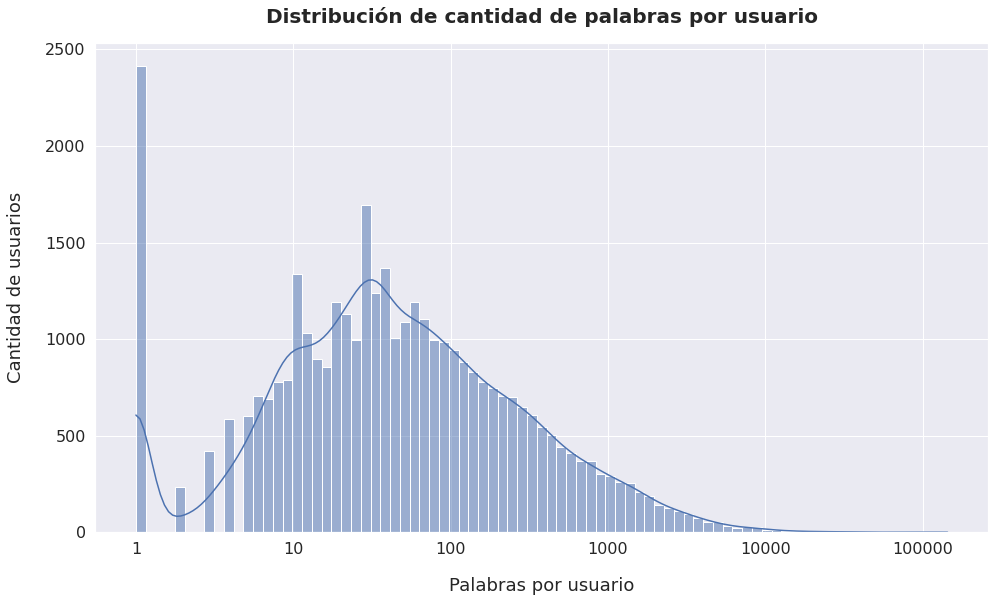

In [102]:
f, ax = plt.subplots(figsize=(16, 9))

sns.histplot(
    data=word_dist.to_frame(),
    x="all_tweets",
    kde=True,
    ax=ax,
    log_scale=True
)

ax.set_title("Distribución de cantidad de palabras por usuario", fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel("Palabras por usuario", fontsize=18, labelpad=20)
ax.set_ylabel("Cantidad de usuarios", fontsize=18, labelpad=20)

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))

f.savefig(figuresPath + 'content/distribucion_palabras.pdf', bbox_inches = 'tight')

plt.show()

In [91]:
def create_nlp_model(optimizer, num_classes, embedding_dim, input_length, max_features):
    clear_session()
    
    nlp_input = Input(shape=(input_length, ))
    emb = Embedding(max_features, embedding_dim, input_length=input_length, mask_zero=True)(nlp_input)
    sdrop = SpatialDropout1D(0.4)(emb)
    '''nlp_output = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(sdrop)
    nlp_output = Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(nlp_output)
    nlp_output = Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(nlp_output)
    nlp_output = Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(nlp_output)'''
    nlp_output = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2))(sdrop)
    
    #nlp_output = Bidirectional(LSTM(100, dropout=0.2))(sdrop)
    nlp_output = Dense(num_classes, activation='softmax')(nlp_output)
    
    nlp_model = Model(inputs=nlp_input, outputs=nlp_output)

    nlp_model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return nlp_model

In [92]:
clf = create_nlp_model(
    num_classes=total_cities,
    embedding_dim=64,
    input_length=256,
    optimizer="adam",
    max_features=10000
)
    
clf.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 256, 64)           640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 256, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               132000    
_________________________________________________________________
dense (Dense)                (None, 95)                19095     
Total params: 791,095
Trainable params: 791,095
Non-trainable params: 0
_________________________________________________________________


In [93]:
max_features = 10000
embedding_dim = 64
sequence_length = 256

def preprocess(fold):   
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
    
    train_tweets = X_train["all_tweets"].to_numpy()
    val_tweets = X_val["all_tweets"].to_numpy()
    test_tweets = X_test["all_tweets"].to_numpy()
    
    tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(train_tweets)
    
    print('Tokens unicos %s' % len(tokenizer.word_index))
    print('Embedding dim recomendado: ', len(tokenizer.word_index)**(1/4))

    X_train = tokenizer.texts_to_sequences(train_tweets)
    X_train = pad_sequences(X_train, maxlen=sequence_length, truncating='post', padding='pre')
    
    X_val = tokenizer.texts_to_sequences(val_tweets)
    X_val = pad_sequences(X_val, maxlen=sequence_length, truncating='post', padding='pre')   
    
    X_test = tokenizer.texts_to_sequences(test_tweets)
    X_test = pad_sequences(X_test, maxlen=sequence_length, truncating='post', padding='pre')
    
    clf = create_nlp_model(
        num_classes=total_cities,
        embedding_dim=embedding_dim,
        input_length=sequence_length,
        optimizer="adam",
        max_features=max_features
    )
    
    clf.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, restore_best_weights=True)],
        epochs=30,
        batch_size=64        
    )
    
    return clf, X_test

    
cn_cross_val = KerasCrossValidator(
    name="Contenido Mutual information + Naive Bayes",
    encoder=LabelBinarizer()
)

bilstm_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, bilstm_preds, cn_cross_val.classes_order(), cities_with_coords, users_coords)

Tokens unicos 253969
Embedding dim recomendado:  22.448905783107836
Epoch 1/30
418/418 [==============================] - 115s 268ms/step - loss: 3.7189 - accuracy: 0.2392 - val_loss: 3.3608 - val_accuracy: 0.2944
Epoch 2/30
418/418 [==============================] - 112s 267ms/step - loss: 3.2014 - accuracy: 0.3075 - val_loss: 3.0150 - val_accuracy: 0.3382
Epoch 3/30
418/418 [==============================] - 111s 265ms/step - loss: 2.8619 - accuracy: 0.3648 - val_loss: 2.7567 - val_accuracy: 0.3869
Epoch 4/30
418/418 [==============================] - 111s 265ms/step - loss: 2.6150 - accuracy: 0.4096 - val_loss: 2.5809 - val_accuracy: 0.4357
Epoch 5/30
418/418 [==============================] - 111s 264ms/step - loss: 2.3902 - accuracy: 0.4559 - val_loss: 2.4634 - val_accuracy: 0.4717
Epoch 6/30
418/418 [==============================] - 111s 265ms/step - loss: 2.1925 - accuracy: 0.4958 - val_loss: 2.4192 - val_accuracy: 0.4855
Epoch 7/30
418/418 [==============================] - 11

418/418 [==============================] - 107s 256ms/step - loss: 1.0530 - accuracy: 0.7524 - val_loss: 2.0677 - val_accuracy: 0.6157
Epoch 18/30
418/418 [==============================] - 107s 256ms/step - loss: 1.0136 - accuracy: 0.7618 - val_loss: 2.0712 - val_accuracy: 0.6134
Epoch 19/30
418/418 [==============================] - 107s 256ms/step - loss: 0.9746 - accuracy: 0.7713 - val_loss: 2.1061 - val_accuracy: 0.6218
Epoch 20/30
418/418 [==============================] - 107s 256ms/step - loss: 0.9282 - accuracy: 0.7785 - val_loss: 2.1827 - val_accuracy: 0.6036
Epoch 21/30
418/418 [==============================] - 107s 256ms/step - loss: 0.9046 - accuracy: 0.7858 - val_loss: 2.1556 - val_accuracy: 0.6198
Epoch 22/30
418/418 [==============================] - 107s 256ms/step - loss: 0.8578 - accuracy: 0.7952 - val_loss: 2.1753 - val_accuracy: 0.6174
Epoch 23/30
418/418 [==============================] - 107s 256ms/step - loss: 0.8290 - accuracy: 0.8018 - val_loss: 2.1998 - val_

In [94]:
print("BiLSTM Total - Cities")
print(count_score_city)

BiLSTM Total - Cities
Accuracy: 0.6049641953373176        
Acc@161: 0.7205351854843052        
Balanced Acc: 0.5036349451290945        
ROC AUC Ovo: 0.9189811649440626        
Mean Dist Err: 663.3731882236921        
Median Dist Err: 5.321599948720096


In [709]:
print("BiLSTM Total - Cities")
print(count_score_city)

BiLSTM Total - Cities
Accuracy: 0.5975609756097561        
Acc@161: 0.7141011145210789        
Balanced Acc: 0.4964177746659649        
ROC AUC Ovo: 0.9168510217113284        
Mean Dist Err: 670.6865155060009        
Median Dist Err: 0.0


In [352]:
print("BiLSTM Total - Cities")
print(count_score_city)

BiLSTM Total - Cities
Accuracy: 0.6016798578581812        
Acc@161: 0.7188660959457277        
Balanced Acc: 0.49130318515514343        
ROC AUC Ovo: 0.9177050293645955        
Mean Dist Err: 1642.1014008346312        
Median Dist Err: 643.3665274754685


BI-LSTM eliminando stop-words y usando terminos usados al menos 10 veces

In [ ]:
max_features = 10000
embedding_dim = 64
sequence_length = 256

def parse_stopwords(row, av_words):
    tweets = row["all_tweets"].lower()

    return ' '.join([word for word in re.split("\W+", tweets) if word in av_words])
    
def preprocess(fold):   
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
    
    train_tweets = X_train["all_tweets"].to_numpy()
    val_tweets = X_val["all_tweets"].to_numpy()
    test_tweets = X_test["all_tweets"].to_numpy()
    
    vectorizer = CountVectorizer(
        #strip_accents='unicode',
        strip_accents=None,
        lowercase=True,
        max_df=0.3,
        min_df=10
    )

    vector_of_words = vectorizer.fit_transform(train_tweets).astype(np.uint8)
    
    av_words = set(vectorizer.get_feature_names())

    train_tweets = X_train.apply(parse_stopwords, axis=1, av_words=av_words).to_numpy()

    tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(train_tweets)
    
    print('Tokens unicos %s' % len(tokenizer.word_index))
    print('Embedding dim recomendado: ', len(tokenizer.word_index)**(1/4))

    X_train = tokenizer.texts_to_sequences(train_tweets)
    X_train = pad_sequences(X_train, maxlen=sequence_length, truncating='post', padding='pre')
    
    X_val = tokenizer.texts_to_sequences(val_tweets)
    X_val = pad_sequences(X_val, maxlen=sequence_length, truncating='post', padding='pre')   
    
    X_test = tokenizer.texts_to_sequences(test_tweets)
    X_test = pad_sequences(X_test, maxlen=sequence_length, truncating='post', padding='pre')
    
    clf = create_nlp_model(
        num_classes=total_cities,
        input_length=sequence_length,
        optimizer="adam"
    )
    
    clf.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, restore_best_weights=True)],
        epochs=30,
        batch_size=64        
    )
    
    return clf, X_test    
    
cn_cross_val = KerasCrossValidator(
    name="Contenido Mutual information + Naive Bayes",
    encoder=LabelBinarizer()
)

bilstm_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, bilstm_preds, cn_cross_val.classes_order(), cities_with_coords)

In [259]:
count_score_bi = get_all_metrics(classes_true_enc, bilstm_red_preds, bilstm_red_cross_val.classes_order(), places_with_coords)

In [262]:
print("BiLSTM Short Scores - KD-Tree")
print(count_score_bi)

print()

print("BiLSTM Short Scores - Cities")
print(count_score_city_bi)

BiLSTM Short Scores - KD-Tree
Accuracy: 0.349135842351801        
Acc@161: 0.6592365261400959        
Balanced Acc: 0.31254287298571065        
ROC AUC Ovo: 0.8838231692953935        
Mean Dist Err: 1276.6785155465955        
Median Dist Err: 249.4093358040593

BiLSTM Short Scores - Cities
Accuracy: 0.5573413018898401        
Acc@161: 0.6932913368868788        
Balanced Acc: 0.4201241919307192        
ROC AUC Ovo: 0.905000149118594        
Mean Dist Err: 1673.7787453341261        
Median Dist Err: 643.3665274754685


Word2vec Bi-LSTM eliminando stop-words y usando terminos al menos usados 10 veces

Construimos un vocabulario para utilizar con word2vec, no importa si tomamos datos de conjunto de pruebas/validacion porque al final se entrenaran con terminos que solo existan en el entrenamiento

In [95]:
embedding_dim = 64
sequence_length = 256

def parse_stopwords(row, av_words):
    tweets = row["all_tweets"].lower()

    return ' '.join([word for word in re.split("\W+", tweets) if word in av_words])

vectorizer = CountVectorizer(
    #strip_accents='unicode',
    strip_accents=None,
    lowercase=True,
    max_df=0.3,
    min_df=10
)

all_tweets = users_train_final["all_tweets"].to_numpy()

vector_of_words = vectorizer.fit_transform(all_tweets).astype(np.uint8)
    
av_words = set(vectorizer.get_feature_names())

tweets_filtered = users_train_final.apply(parse_stopwords, axis=1, av_words=av_words).to_numpy()

tweets_filtered_list = list(map(lambda x: x.split(' '), tweets_filtered))
    
bigrams_detector = Phrases(tweets_filtered_list, 
            delimiter=' ', min_count=10, threshold=10)

bigrams_detector = Phraser(bigrams_detector)
    
trigrams_detector = Phrases(bigrams_detector[tweets_filtered_list], 
            delimiter=' ', min_count=10, threshold=10)

trigrams_detector = Phraser(trigrams_detector)
    
tweets_filtered_list = list(bigrams_detector[tweets_filtered_list])
tweets_filtered_list = list(trigrams_detector[tweets_filtered_list])

In [96]:
tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(tweets_filtered_list)
print('Tokens unicos %s' % len(tokenizer.word_index))
print('Embedding dim recomendado: ', len(tokenizer.word_index)**(1/4))

Tokens unicos 52635
Embedding dim recomendado:  15.14672207973581


In [97]:
word2vec = Word2Vec(
    tweets_filtered_list,
    vector_size=embedding_dim,
    window=5,
    min_count=0,
    sg=1,
    workers=6,
    epochs=10
)

In [98]:
# Matriz de embeddings con +1 por el elemento agregado por el Tokenizer
embeddings = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, idx in tokenizer.word_index.items():
    try:
        embeddings[idx] =  word2vec.wv[word]
    except:
        pass

In [101]:
def create_word2vec_model(optimizer, num_classes, input_length, embeddings, words_dim):
    clear_session()
    
    nlp_input = Input(shape=(input_length, ))
    emb = Embedding(words_dim, embedding_dim, input_length=input_length, 
                    weights=[embeddings],trainable=False)(nlp_input)
    sdrop = SpatialDropout1D(0.4)(emb)
    #nlp_output = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(sdrop)
    #nlp_output = Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(nlp_output)
    #nlp_output = Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(nlp_output)
    #nlp_output = Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(nlp_output)
    nlp_output = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2))(sdrop)
    nlp_output = Dense(num_classes, activation='softmax')(nlp_output)
    
    nlp_model = Model(inputs=nlp_input, outputs=nlp_output)

    nlp_model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return nlp_model

In [102]:
    clf = create_word2vec_model(
        input_length=sequence_length,
        embeddings=embeddings,
        words_dim=len(tokenizer.word_index) + 1,
        optimizer="adam",
        num_classes=total_cities
    )
    
    clf.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 256, 64)           3368704   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 256, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               132000    
_________________________________________________________________
dense (Dense)                (None, 95)                19095     
Total params: 3,519,799
Trainable params: 151,095
Non-trainable params: 3,368,704
_________________________________________________________________


In [103]:
def preprocess(fold):   
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
    
    train_tweets = X_train["all_tweets"].to_numpy()
    val_tweets = X_val["all_tweets"].to_numpy()
    test_tweets = X_test["all_tweets"].to_numpy()

    X_train = tokenizer.texts_to_sequences(train_tweets)
    X_train = pad_sequences(X_train, maxlen=sequence_length, truncating='post', padding='pre')
    
    X_val = tokenizer.texts_to_sequences(val_tweets)
    X_val = pad_sequences(X_val, maxlen=sequence_length, truncating='post', padding='pre')   
    
    X_test = tokenizer.texts_to_sequences(test_tweets)
    X_test = pad_sequences(X_test, maxlen=sequence_length, truncating='post', padding='pre')
    
    clf = create_word2vec_model(
        input_length=sequence_length,
        embeddings=embeddings,
        words_dim=len(tokenizer.word_index) + 1,
        optimizer="adam",
        num_classes=total_cities
    )
    
    clf.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, restore_best_weights=True)],
        epochs=30,
        batch_size=64        
    )
    
    return clf, X_test
    
cn_cross_val = KerasCrossValidator(
    name="Contenido Mutual information + Naive Bayes",
    encoder=LabelBinarizer()
)

word2vec_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, word2vec_preds, cn_cross_val.classes_order(), cities_with_coords, users_coords)

Epoch 1/30
418/418 [==============================] - 83s 193ms/step - loss: 3.5330 - accuracy: 0.2561 - val_loss: 3.0699 - val_accuracy: 0.3264
Epoch 2/30
418/418 [==============================] - 81s 193ms/step - loss: 3.1110 - accuracy: 0.3164 - val_loss: 2.7992 - val_accuracy: 0.3822
Epoch 3/30
418/418 [==============================] - 81s 193ms/step - loss: 2.8648 - accuracy: 0.3642 - val_loss: 2.6201 - val_accuracy: 0.4122
Epoch 4/30
418/418 [==============================] - 81s 193ms/step - loss: 2.6742 - accuracy: 0.4018 - val_loss: 2.4572 - val_accuracy: 0.4515
Epoch 5/30
418/418 [==============================] - 81s 193ms/step - loss: 2.5413 - accuracy: 0.4300 - val_loss: 2.3422 - val_accuracy: 0.4731
Epoch 6/30
418/418 [==============================] - 81s 193ms/step - loss: 2.4455 - accuracy: 0.4490 - val_loss: 2.2632 - val_accuracy: 0.4997
Epoch 7/30
418/418 [==============================] - 81s 193ms/step - loss: 2.3704 - accuracy: 0.4665 - val_loss: 2.1789 - val_ac

418/418 [==============================] - 81s 194ms/step - loss: 1.9084 - accuracy: 0.5632 - val_loss: 1.8143 - val_accuracy: 0.5902
Epoch 24/30
418/418 [==============================] - 81s 194ms/step - loss: 1.8951 - accuracy: 0.5689 - val_loss: 1.8150 - val_accuracy: 0.5949
Epoch 25/30
418/418 [==============================] - 81s 194ms/step - loss: 1.8813 - accuracy: 0.5705 - val_loss: 1.8049 - val_accuracy: 0.5922
Epoch 26/30
418/418 [==============================] - 81s 194ms/step - loss: 1.8605 - accuracy: 0.5728 - val_loss: 1.7887 - val_accuracy: 0.5986
Epoch 27/30
418/418 [==============================] - 81s 194ms/step - loss: 1.8492 - accuracy: 0.5782 - val_loss: 1.7845 - val_accuracy: 0.5983
Epoch 28/30
418/418 [==============================] - 81s 194ms/step - loss: 1.8374 - accuracy: 0.5795 - val_loss: 1.7813 - val_accuracy: 0.5993
Epoch 29/30
418/418 [==============================] - 81s 194ms/step - loss: 1.8293 - accuracy: 0.5822 - val_loss: 1.7757 - val_accurac

In [104]:
print("Word2vec Scores - Cities")
print(count_score_city)

Word2vec Scores - Cities
Accuracy: 0.6041834921660475        
Acc@161: 0.750471113982663        
Balanced Acc: 0.4735540328376348        
ROC AUC Ovo: 0.9255257954042853        
Mean Dist Err: 547.4828855546851        
Median Dist Err: 5.225198729193501


In [297]:
print("Word2vec Scores - KD-Tree")
print(count_score_kd)

print()

print("Word2vec Scores - Cities")
print(count_score_city)

Word2vec Scores - KD-Tree
Accuracy: 0.39261293275184406        
Acc@161: 0.6864803747375222        
Balanced Acc: 0.36042045590081406        
ROC AUC Ovo: 0.9040220760945974        
Mean Dist Err: 1126.6104162760003        
Median Dist Err: 234.615269811828

Word2vec Scores - Cities
Accuracy: 0.6057179777095785        
Acc@161: 0.7540246594518926        
Balanced Acc: 0.47317914895261526        
ROC AUC Ovo: 0.9256375551873239        
Mean Dist Err: 1373.8395307842823        
Median Dist Err: 387.85362324458777


Transformer

In [95]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [96]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [97]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [180]:
class TokenAndPositionEmbeddingPreTrain(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, weights):
        super(TokenAndPositionEmbeddingPreTrain, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, weights=[weights], trainable=True)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.bisltm = Bidirectional(LSTM(16, dropout=0.2, return_sequences=True))
    
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        x = self.bisltm(x)
        return x + positions

In [99]:
def create_transformer_model(optimizer, num_classes, input_length, vocab_size, emb_dim, num_heads, ff_dim):
    inputs = layers.Input(shape=(input_length,))
    
    embedding_layer = TokenAndPositionEmbedding(input_length, vocab_size, emb_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(emb_dim, num_heads, ff_dim)
    x = transformer_block(x)
    #x = transformer_block(x)
    #x = transformer_block(x)
    #x = transformer_block(x)
    #x = transformer_block(x)
    #x = transformer_block(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    #x = layers.Dense(20, activation="relu")(x)
    #x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    return model

In [178]:
def create_pretrained_transformer_model(
    optimizer, num_classes, input_length, vocab_size, emb_dim, num_heads, ff_dim, weights
):
    inputs = layers.Input(shape=(input_length,))
    
    embedding_layer = TokenAndPositionEmbeddingPreTrain(input_length, vocab_size, emb_dim, weights)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(emb_dim, num_heads, ff_dim)
    x = transformer_block(x)
    #x = transformer_block(x)
    #x = transformer_block(x)
    #x = transformer_block(x)
    #x = transformer_block(x)
    #x = transformer_block(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    #x = layers.Dense(20, activation="relu")(x)
    #x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    return model

In [101]:
model = create_transformer_model("adam", 95, 256, 10000, 32, 6, 32)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
token_and_position_embedding (None, 256, 32)           328192    
_________________________________________________________________
transformer_block_1 (Transfo (None, 256, 32)           27424     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 95)                3135      
Total params: 358,751
Trainable params: 358,751
Non-trainable params: 0
_____________________________________________________

In [229]:
def parse_stopwords(row, av_words):
    tweets = row["all_tweets"].lower()

    #return ' '.join([word for word in re.split("\W+", tweets) if word in av_words])
    return [word for word in tweets if word in av_words]

def apply_tokenizer(row):
    tweets = row["all_tweets"].lower()
    
    return TweetTokenizer(reduce_len=3).tokenize(tweets)

def preprocess(fold):   
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
    
    #train_tweets = X_train["all_tweets"].to_numpy()
    train_tweets = X_train.apply(apply_tokenizer, axis=1).to_numpy()
    val_tweets = X_val.apply(apply_tokenizer, axis=1).to_numpy()#X_val["all_tweets"].to_numpy()
    test_tweets =X_test.apply(apply_tokenizer, axis=1).to_numpy() #X_test["all_tweets"].to_numpy()

    print("Tokenizer end")
    
    vectorizer = CountVectorizer(
        #strip_accents='unicode',
        strip_accents=None,
        lowercase=True,
        #max_df=0.3,
        min_df=10,
        dtype=np.uint8,
        analyzer=lambda x: x
    )

    vector_of_words = vectorizer.fit_transform(train_tweets)
    
    av_words = set(vectorizer.get_feature_names())
    
    print("Total words: ", len(av_words))

    train_tweets = np.array(list(map(lambda tweets: [word for word in tweets if word in av_words], train_tweets)), dtype=object)
    #X_train.apply(parse_stopwords, axis=1, av_words=av_words).to_numpy()
    
    #tweets_filtered_list = list(map(lambda x: x.split(' '), train_tweets))
    
    print("Generated vocabulary: ", train_tweets.shape)
    
    embedding_dim = 32
    
    word2vec = Word2Vec(
        train_tweets,
        vector_size=embedding_dim,
        window=5,
        min_count=0,
        sg=1,
        workers=6,
        epochs=10
    )
    
    print("Word2vec end")
    
    #max_features = 50000
    sequence_length = 256
    
    tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(train_tweets)
    
    print('Tokens unicos %s' % len(tokenizer.word_index))
    print('Embedding dim recomendado: ', len(tokenizer.word_index)**(1/4))
    
    X_train = tokenizer.texts_to_sequences(train_tweets)
    X_train = pad_sequences(X_train, maxlen=sequence_length, truncating='post', padding='pre')
    
    X_val = tokenizer.texts_to_sequences(val_tweets)
    X_val = pad_sequences(X_val, maxlen=sequence_length, truncating='post', padding='pre')   
    
    X_test = tokenizer.texts_to_sequences(test_tweets)
    X_test = pad_sequences(X_test, maxlen=sequence_length, truncating='post', padding='pre')
    
    embeddings = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

    for word, idx in tokenizer.word_index.items():
        try:
            embeddings[idx] =  word2vec.wv[word]
        except:
            pass
        
    clf = create_pretrained_transformer_model(
        optimizer="adam",
        num_classes=total_cities,
        input_length=sequence_length,
        vocab_size=len(tokenizer.word_index) + 1,
        emb_dim=embedding_dim,
        num_heads=6,
        ff_dim=32,
        #With weights
        weights=embeddings
    )
    
    clf.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=1, min_delta=0.0001, restore_best_weights=True)],
        epochs=30,
        batch_size=64        
    )
    
    return clf, X_test
    
cn_cross_val = KerasCrossValidator(
    name="Contenido Mutual information + Naive Bayes",
    encoder=LabelBinarizer()
)

transformer_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, transformer_preds, cn_cross_val.classes_order(), cities_with_coords, users_coords)

Tokenizer end
Total words:  21733


<ipython-input-229-404001edc4be>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_tweets = np.array(list(map(lambda tweets: [word for word in tweets if word in av_words], train_tweets)))


Generated vocabulary:  (26744,)
Word2vec end
Tokens unicos 21733
Embedding dim recomendado:  12.141711797486623
Epoch 1/30
418/418 [==============================] - 172s 406ms/step - loss: 3.4622 - accuracy: 0.2783 - val_loss: 2.7498 - val_accuracy: 0.3933
Epoch 2/30
418/418 [==============================] - 169s 405ms/step - loss: 2.4527 - accuracy: 0.4678 - val_loss: 2.1086 - val_accuracy: 0.5397
Epoch 3/30
418/418 [==============================] - 169s 405ms/step - loss: 1.9946 - accuracy: 0.5724 - val_loss: 1.8615 - val_accuracy: 0.6060
Epoch 4/30
418/418 [==============================] - 169s 405ms/step - loss: 1.7556 - accuracy: 0.6261 - val_loss: 1.7310 - val_accuracy: 0.6410
Epoch 5/30
418/418 [==============================] - 169s 405ms/step - loss: 1.5981 - accuracy: 0.6573 - val_loss: 1.6736 - val_accuracy: 0.6504
Epoch 6/30
418/418 [==============================] - 169s 404ms/step - loss: 1.4809 - accuracy: 0.6791 - val_loss: 1.6974 - val_accuracy: 0.6538
Tokenizer en

<ipython-input-229-404001edc4be>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_tweets = np.array(list(map(lambda tweets: [word for word in tweets if word in av_words], train_tweets)))


Generated vocabulary:  (26745,)
Word2vec end
Tokens unicos 22149
Embedding dim recomendado:  12.199401668022475
Epoch 1/30
418/418 [==============================] - 172s 406ms/step - loss: 3.4661 - accuracy: 0.2825 - val_loss: 2.7320 - val_accuracy: 0.4092
Epoch 2/30
418/418 [==============================] - 169s 405ms/step - loss: 2.4422 - accuracy: 0.4739 - val_loss: 2.1144 - val_accuracy: 0.5491
Epoch 3/30
418/418 [==============================] - 169s 405ms/step - loss: 2.0122 - accuracy: 0.5656 - val_loss: 1.8453 - val_accuracy: 0.6033
Epoch 4/30
418/418 [==============================] - 171s 408ms/step - loss: 1.7727 - accuracy: 0.6181 - val_loss: 1.7467 - val_accuracy: 0.6403
Epoch 5/30
418/418 [==============================] - 172s 411ms/step - loss: 1.6152 - accuracy: 0.6506 - val_loss: 1.6939 - val_accuracy: 0.6531
Epoch 6/30
418/418 [==============================] - 170s 408ms/step - loss: 1.4996 - accuracy: 0.6729 - val_loss: 1.6725 - val_accuracy: 0.6585
Epoch 7/30
4

<ipython-input-229-404001edc4be>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_tweets = np.array(list(map(lambda tweets: [word for word in tweets if word in av_words], train_tweets)))


Generated vocabulary:  (26745,)
Word2vec end
Tokens unicos 21973
Embedding dim recomendado:  12.17509444799779
Epoch 1/30
418/418 [==============================] - 176s 415ms/step - loss: 3.5264 - accuracy: 0.2676 - val_loss: 2.8400 - val_accuracy: 0.3546
Epoch 2/30
418/418 [==============================] - 171s 409ms/step - loss: 2.5040 - accuracy: 0.4547 - val_loss: 2.1028 - val_accuracy: 0.5572
Epoch 3/30
418/418 [==============================] - 170s 406ms/step - loss: 2.0086 - accuracy: 0.5671 - val_loss: 1.8344 - val_accuracy: 0.6191
Epoch 4/30
418/418 [==============================] - 170s 406ms/step - loss: 1.7514 - accuracy: 0.6268 - val_loss: 1.7063 - val_accuracy: 0.6410
Epoch 5/30
418/418 [==============================] - 198s 474ms/step - loss: 1.6069 - accuracy: 0.6528 - val_loss: 1.6472 - val_accuracy: 0.6615
Epoch 6/30
418/418 [==============================] - 219s 525ms/step - loss: 1.4886 - accuracy: 0.6736 - val_loss: 1.6141 - val_accuracy: 0.6666
Epoch 7/30
41

<ipython-input-229-404001edc4be>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_tweets = np.array(list(map(lambda tweets: [word for word in tweets if word in av_words], train_tweets)))


Generated vocabulary:  (26745,)
Word2vec end
Tokens unicos 21353
Embedding dim recomendado:  12.088285957491552
Epoch 1/30
418/418 [==============================] - 224s 528ms/step - loss: 3.4856 - accuracy: 0.2685 - val_loss: 2.8331 - val_accuracy: 0.3573
Epoch 2/30
418/418 [==============================] - 220s 527ms/step - loss: 2.4961 - accuracy: 0.4553 - val_loss: 2.1283 - val_accuracy: 0.5239
Epoch 3/30
418/418 [==============================] - 219s 525ms/step - loss: 2.0345 - accuracy: 0.5613 - val_loss: 1.8394 - val_accuracy: 0.6134
Epoch 4/30
418/418 [==============================] - 220s 527ms/step - loss: 1.7866 - accuracy: 0.6191 - val_loss: 1.7041 - val_accuracy: 0.6447
Epoch 5/30
418/418 [==============================] - 220s 526ms/step - loss: 1.6180 - accuracy: 0.6519 - val_loss: 1.6517 - val_accuracy: 0.6571
Epoch 6/30
418/418 [==============================] - 220s 526ms/step - loss: 1.5022 - accuracy: 0.6744 - val_loss: 1.6467 - val_accuracy: 0.6676
Epoch 7/30
4

<ipython-input-229-404001edc4be>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_tweets = np.array(list(map(lambda tweets: [word for word in tweets if word in av_words], train_tweets)))


Generated vocabulary:  (26745,)
Word2vec end
Tokens unicos 22209
Embedding dim recomendado:  12.207655107333371
Epoch 1/30
418/418 [==============================] - 230s 530ms/step - loss: 3.5389 - accuracy: 0.2647 - val_loss: 2.8729 - val_accuracy: 0.3745
Epoch 2/30
418/418 [==============================] - 221s 529ms/step - loss: 2.5410 - accuracy: 0.4457 - val_loss: 2.1479 - val_accuracy: 0.5259
Epoch 3/30
418/418 [==============================] - 221s 528ms/step - loss: 2.0414 - accuracy: 0.5619 - val_loss: 1.8651 - val_accuracy: 0.5804
Epoch 4/30
418/418 [==============================] - 220s 527ms/step - loss: 1.7918 - accuracy: 0.6178 - val_loss: 1.7473 - val_accuracy: 0.6373
Epoch 5/30
418/418 [==============================] - 220s 527ms/step - loss: 1.6201 - accuracy: 0.6494 - val_loss: 1.6798 - val_accuracy: 0.6551
Epoch 6/30
418/418 [==============================] - 221s 528ms/step - loss: 1.4996 - accuracy: 0.6755 - val_loss: 1.6956 - val_accuracy: 0.6524


In [231]:
#with open('../../tmp_paper/transformer_preds.pickle', 'wb') as handle:
#    pickle.dump(transformer_preds, handle, protocol=4)

In [152]:
with open('../../tmp_paper/transformer_preds.pickle', 'rb') as handle:
    transformer_preds = pickle.load(handle)

In [149]:
#with open(tmp_save + 'transformer_exact_preds.pickle', 'rb') as handle:
#    transformer_preds = pickle.load(handle)

In [153]:
count_score_city = get_all_metrics(cities_true_enc, transformer_preds, encoder_city.classes_, cities_with_coords, users_coords)

In [230]:
print(count_score_city)

Accuracy: 0.6578635653906207        
Acc@161: 0.7671350885694287        
Balanced Acc: 0.5733106782263208        
ROC AUC Ovo: 0.9359052385550506        
Mean Dist Err: 514.5073055376216        
Median Dist Err: 4.854669287837341


# Predicciones solo con Menciones

Naive bayes sobre grafo no dirigido pesado

In [717]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    X_train = vector_of_mentions_compl[X_train.index.to_numpy()]
    X_test = vector_of_mentions_compl[X_test.index.to_numpy()]
    
    clf = GridSearchCV(
        estimator=MultinomialNB(),
        param_grid={
            "alpha": [0.1, 0.5, 1.0, 2.0],
        },
        cv=3,
        #n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
    
    clf.fit(X_train, y_train)
    
    return clf, X_test
                
cn_cross_val = CrossValidator(
    name="Menciones No Dirigidas Naive Bayes",
)

mentions_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, mentions_preds, cn_cross_val.classes_order(), cities_with_coords)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END alpha=0.1; accuracy: (test=0.330) balanced_accuracy: (test=0.317) roc_auc_ovo_weighted: (test=0.725) total time=  14.0s
[CV 2/3] END alpha=0.1; accuracy: (test=0.321) balanced_accuracy: (test=0.285) roc_auc_ovo_weighted: (test=0.711) total time=  11.3s
[CV 3/3] END alpha=0.1; accuracy: (test=0.315) balanced_accuracy: (test=0.290) roc_auc_ovo_weighted: (test=0.711) total time=  11.5s
[CV 1/3] END alpha=0.5; accuracy: (test=0.384) balanced_accuracy: (test=0.306) roc_auc_ovo_weighted: (test=0.730) total time=  11.4s
[CV 2/3] END alpha=0.5; accuracy: (test=0.375) balanced_accuracy: (test=0.271) roc_auc_ovo_weighted: (test=0.717) total time=  11.4s
[CV 3/3] END alpha=0.5; accuracy: (test=0.368) balanced_accuracy: (test=0.277) roc_auc_ovo_weighted: (test=0.717) total time=  11.5s
[CV 1/3] END alpha=1.0; accuracy: (test=0.401) balanced_accuracy: (test=0.294) roc_auc_ovo_weighted: (test=0.728) total time=   9.7s
[CV 2/3] 

[CV 3/3] END alpha=2.0; accuracy: (test=0.394) balanced_accuracy: (test=0.251) roc_auc_ovo_weighted: (test=0.717) total time=  10.6s
Best params:  {'alpha': 0.5}


In [718]:
print(count_score_city)

Accuracy: 0.3869326441608787        
Acc@161: 0.5854735368545738        
Balanced Acc: 0.29942323208627886        
ROC AUC Ovo: 0.7386245437337722        
Mean Dist Err: 925.5070031216536        
Median Dist Err: 24.490685793228526


In [342]:
print("Mentions MNB - KD-Tree")
print(count_score_kd)

print()

print("Mentions MNB - Cities")
print(count_score_city)

Mentions MNB - KD-Tree
Accuracy: 0.21092446023797987        
Acc@161: 0.5764819899854627        
Balanced Acc: 0.19046570747411734        
ROC AUC Ovo: 0.6673773728229001        
Mean Dist Err: 1186.9027606002462        
Median Dist Err: 276.2699279794116

Mentions MNB - Cities
Accuracy: 0.3869326441608787        
Acc@161: 0.5854735368545738        
Balanced Acc: 0.29942323208627886        
ROC AUC Ovo: 0.7386245437337722        
Mean Dist Err: 1509.6334755173648        
Median Dist Err: 424.2831578727265


Chi2 + Naive bayes

In [94]:
estimator = Pipeline(
    [
        ("chi2", ChiSelector(np.array(total_users_mentions), k=50)),
        ("naive_bayes", MultinomialNB())
    ]
)

def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    X_train = vector_of_mentions_compl[X_train.index.to_numpy()]
    X_test = vector_of_mentions_compl[X_test.index.to_numpy()]
            
    clf = GridSearchCV(
        estimator=estimator,
        param_grid={
            "naive_bayes__alpha": [0.5],
            "chi2__k": [10000, 50, 500, 1000]
        },
        cv=3,
        #n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
    
    clf.fit(X_train, y_train)
    
    return clf, X_test
    
cn_cross_val = CrossValidator(
    name="Menciones No Dirigidas Naive Bayes",
)

mentions_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, mentions_preds, cn_cross_val.classes_order(), cities_with_coords)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END chi2__k=10000, naive_bayes__alpha=0.5; accuracy: (test=0.226) balanced_accuracy: (test=0.011) roc_auc_ovo_weighted: (test=0.506) total time=45.6min


KeyboardInterrupt: 

In [ ]:
print(count_score_city)

In [176]:
print(count_score_city)

Accuracy: 0.13168223655519085        
Acc@161: 0.4566300181329906        
Balanced Acc: 0.12264961989619905        
ROC AUC Ovo: 0.6127350218117971        
Mean Dist Err: 1022.9578832832558        
Median Dist Err: 276.2699279794116


Busqueda de comunidades Oslom

In [97]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    v = CountVectorizer(
        strip_accents=None,
        lowercase=False,
        #vocabulary=all_clusters,
        analyzer=lambda x: x
    )
    
    X_train = v.fit_transform(X_train["clusters_mentions_0"]).astype(np.float32)
    X_test = v.transform(X_test["clusters_mentions_0"]).astype(np.float32)
            
    clf=GridSearchCV(
        estimator=MultinomialNB(),
        param_grid={"alpha": [0.01, 0.05, 0.1]},
        cv=3,
        #n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=2
    )
    
    clf.fit(X_train, y_train)
    
    return clf, X_test
    
cn_cross_val = CrossValidator(
    name="Menciones Oslom #0",
)

mentions_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, mentions_preds, cn_cross_val.classes_order(), cities_with_coords)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .........................................alpha=0.01; total time=   4.1s
[CV] END .........................................alpha=0.01; total time=   3.7s
[CV] END .........................................alpha=0.01; total time=   3.7s
[CV] END .........................................alpha=0.05; total time=   3.7s
[CV] END .........................................alpha=0.05; total time=   3.7s
[CV] END .........................................alpha=0.05; total time=   3.7s
[CV] END ..........................................alpha=0.1; total time=   3.7s
[CV] END ..........................................alpha=0.1; total time=   3.7s
[CV] END ..........................................alpha=0.1; total time=   3.7s
Best params:  {'alpha': 0.05}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .........................................alpha=0.01; total time=   3.7s
[CV] END .................................

In [98]:
print("Menciones Oslom #0")
print(count_score_city)

Menciones Oslom #0
Accuracy: 0.426237010714478        
Acc@161: 0.619636030797394        
Balanced Acc: 0.24546837482307424        
ROC AUC Ovo: 0.7848563125813336        
Mean Dist Err: 811.2333844678003        
Median Dist Err: 18.165423592674273


In [96]:
vectorizers_mentions = []
vectors_of_clusters_mentions = []

for i in range(total_clusters_mentions):
    v = CountVectorizer(
        strip_accents=None,
        lowercase=False,
        #vocabulary=all_clusters,
        analyzer=lambda x: x
    )
    
    vectors_of_clusters_mentions.append(
        v.fit_transform(users_train_final["clusters_mentions_" + str(i)]).astype(np.float32)
    )
    
    vectorizers_mentions.append(v)

vectors_of_clusters_mentions

[<37146x466 sparse matrix of type '<class 'numpy.float32'>'
 	with 36801 stored elements in Compressed Sparse Row format>,
 <37146x77 sparse matrix of type '<class 'numpy.float32'>'
 	with 45972 stored elements in Compressed Sparse Row format>,
 <37146x23 sparse matrix of type '<class 'numpy.float32'>'
 	with 36395 stored elements in Compressed Sparse Row format>,
 <37146x13 sparse matrix of type '<class 'numpy.float32'>'
 	with 33727 stored elements in Compressed Sparse Row format>]

In [97]:
all_clusters_mentions = None

for clusters in vectors_of_clusters_mentions:
    all_clusters_mentions = hstack([all_clusters_mentions, clusters])

all_clusters_mentions = all_clusters_mentions.tocsr()
all_clusters_mentions

<37146x579 sparse matrix of type '<class 'numpy.float32'>'
	with 152895 stored elements in Compressed Sparse Row format>

In [98]:
mentions_all_preds = []
mentions_cross_validators = []

i = 0

for clusters in vectors_of_clusters_mentions:
    mentions_cross_val = CrossValidator(
        name="Mentions oslom #" + str(i),
        clf=GridSearchCV(
            estimator=MultinomialNB(),
            param_grid={"alpha": [0.05, 0.1, 0.5, 1.0, 2.0]},
            cv=3,
            n_jobs=-1,
            scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
            refit='roc_auc_ovo_weighted',
            verbose=3
        )
    )

    mentions_preds = mentions_cross_val.cross_predict(
        [clusters],
        cities_true 
    )
    
    mentions_all_preds.append(mentions_preds)
    mentions_cross_validators.append(mentions_cross_val)
    
    i += 1

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.5}
Fitting 3 folds for

Solo primer nivel jerarquico

In [99]:
print(get_all_metrics(cities_true_enc, mentions_all_preds[0], mentions_cross_val.classes_order(), cities_with_coords))

Accuracy: 0.4258870403273569        
Acc@161: 0.6196629515964034        
Balanced Acc: 0.2453164648268335        
ROC AUC Ovo: 0.784765283116796        
Mean Dist Err: 1412.9958745022489        
Median Dist Err: 387.85362324458777


In [360]:
total_preds = None

for mentions_preds in mentions_all_preds:
    if total_preds is None:
        total_preds = mentions_preds
    else:
        total_preds = np.concatenate((total_preds, mentions_preds), axis=1)
    
print(total_preds.shape)
        
meta_cross_val = CrossValidator(
    name="Meta classifier solo Menciones",
    clf=GridSearchCV(
        estimator=LogisticRegression(class_weight="balanced",random_state=35,n_jobs=-1),
        param_grid={'C': [0.5, 1.0]},
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
)

meta_preds = meta_cross_val.cross_predict(
    [total_preds],
    cities_true
)

(37146, 380)
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params:  {'C': 1.0}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params:  {'C': 1.0}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params:  {'C': 1.0}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params:  {'C': 1.0}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params:  {'C': 1.0}


In [361]:
print(get_all_metrics(cities_true_enc, meta_preds, meta_cross_val.classes_order(), cities_with_coords))

Accuracy: 0.4182684542077209        
Acc@161: 0.6186130404350401        
Balanced Acc: 0.2075028721215175        
ROC AUC Ovo: 0.793990641850265        
Mean Dist Err: 1393.9729040449768        
Median Dist Err: 387.85362324458777


In [358]:
mentions_cross_val = CrossValidator(
    name="Mentions oslom",
    clf=GridSearchCV(
        estimator=MultinomialNB(),
        param_grid={"alpha": [0.05, 0.1, 0.5, 1.0, 2.0]},
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
)

mentions_preds = mentions_cross_val.cross_predict(
    [all_clusters_mentions],
    cities_true 
)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}


In [359]:
print(get_all_metrics(cities_true_enc, mentions_preds, mentions_cross_val.classes_order(), cities_with_coords))

Accuracy: 0.3861788617886179        
Acc@161: 0.5612448177461907        
Balanced Acc: 0.25281401248783353        
ROC AUC Ovo: 0.7856856820850185        
Mean Dist Err: 1565.6089066091986        
Median Dist Err: 570.8345045874122


Todos los niveles jerarquicos

Node2vec menciones

In [261]:
def node2vec_pecanpy(
    adj_mat, out_dim=128, p=1.0, q=1.0, num_walks=10, length_walks=100
):    
    tmp_fold = "../../tmp_data/"
    
    cx = adj_mat.tocoo()

    edges = []

    already_passed = {}

    for i in range(adj_mat.shape[0]):
        already_passed[i] = []

    for i,j,v in zip(cx.row, cx.col, cx.data):    
        if i in already_passed[j]:
            continue

        #edges.append(str(users_ids[i]) + "\t" + str(users_ids[j]) + "\t" + str(v))
        edges.append(str(i) + "\t" + str(j) + "\t" + str(v))

        already_passed[i].append(j)    
        
    edges = pd.DataFrame({"edges": edges})
    edges.to_csv(tmp_fold + "edges_node2vec.edg", header=False, index=False)
    
    !pecanpy --input ../../tmp_data/edges_node2vec.edg --output ../../tmp_data/edges_node2vec.emb --mode SparseOTF\
    --dimensions $out_dim --walk-length $length_walks --num-walks $num_walks --p $p --q $q --weighted
    
    df = pd.read_csv("../../tmp_data/edges_node2vec.emb", header=None,  skiprows=[0], sep=" ")
    
    all_users_ids = set(np.arange(len(users_ids)))
    users_embedded = set(df[0].to_numpy())
    missing_users = np.array(list(all_users_ids.difference(users_embedded)))
    missing_embs = [np.append(np.array([int(x)]), np.zeros(shape=(1, out_dim))) for x in missing_users]
    
    return df.append(missing_embs).sort_values(0).to_numpy()[:,1:]

In [262]:
node2vec_pec_embs = node2vec_pecanpy(vector_of_col_mentions, num_walks=20, length_walks=100, p=1.0, q=0.5)

Took 00:00:08.02 to load graph
Took 00:00:00.00 to pre-compute transition probabilities
Took 00:04:35.95 to generate walks
Took 00:02:23.69 to train embeddings


In [266]:
#with open('../../tmp_paper/node2vec_pec_embs.pickle', 'wb') as handle:
#    pickle.dump(node2vec_pec_embs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [89]:
with open('../../tmp_paper/node2vec_pec_embs.pickle', 'rb') as handle:
    node2vec_pec_embs = pickle.load(handle)

In [ ]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    X_train = node2vec_pec_embs[X_train.index.to_numpy()]
    X_test = node2vec_pec_embs[X_test.index.to_numpy()]
    
    clf=GridSearchCV(
        estimator=LogisticRegression(random_state=35,n_jobs=-1),
        param_grid={'C': [0.05, 0.1, 0.5, 1.0]},
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
    
    clf.fit(X_train, y_train)
    
    return clf, X_test
    
cn_cross_val = CrossValidator(
    name="Contenido Mutual information + Naive Bayes",
)

node2vec_mentions_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, node2vec_mentions_preds, cn_cross_val.classes_order(), cities_with_coords, users_coords)

In [266]:
print(count_score_city)

Accuracy: 0.46004953427017714        
Acc@161: 0.6595864965272169        
Balanced Acc: 0.25214558883676985        
ROC AUC Ovo: 0.8449655578596718        
Mean Dist Err: 711.2495681145041        
Median Dist Err: 13.51631508033061


In [376]:
#with open('../../tmp_paper/random_walks.pickle', 'wb') as handle:
#    pickle.dump(node2vec_mentions_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [110]:
with open('../../tmp_paper/random_walks.pickle', 'rb') as handle:
    node2vec_mentions_preds = pickle.load(handle)

Node2vec + BiLSTM

In [81]:
number_classes = users_train_final["class"].nunique()

def create_node2vec_model(optimizer, outdim, input_length, vocab_size, weights_mentions):
    clear_session()
    
    mentions_input = Input(shape=(input_length, ))
    
    mentions_emb = Embedding(
        input_dim=vocab_size, output_dim=outdim, weights=[weights_mentions], trainable=False
    )(mentions_input)
    
    mentions_sdrop = SpatialDropout1D(0.2)(mentions_emb)

    mentions_lstm = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2))(mentions_sdrop)
           
    final_output = Dense(number_classes, activation='softmax')(mentions_lstm)
    
    model = Model(inputs=mentions_input, outputs=final_output)
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

In [82]:
users_ids_list = np.arange(len(users_ids))

In [88]:
node2vec_cross_val = CrossValidator(
    name="Node2vec BiLSTM",
    clf=KerasClassifier(
        build_fn=create_node2vec_model,
        verbose=2,
        input_length=1,
        vocab_size=len(users_ids),
        weights_mentions=node2vec_pec_embs,
        outdim=node2vec_pec_embs.shape[1],
        optimizer="adam",
        callbacks=EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, restore_best_weights=True),
        epochs=30,
        batch_size=64  
    ),
    encoder=LabelBinarizer()
)

node2vec_preds = node2vec_cross_val.cross_predict(
    [users_ids_list],
    cities_true,
    val_split=0.1
)

Epoch 1/30
418/418 - 4s - loss: 3.3348 - accuracy: 0.3207 - val_loss: 2.8298 - val_accuracy: 0.3886
Epoch 2/30
418/418 - 1s - loss: 2.7253 - accuracy: 0.4144 - val_loss: 2.6603 - val_accuracy: 0.4132
Epoch 3/30
418/418 - 1s - loss: 2.6093 - accuracy: 0.4334 - val_loss: 2.5971 - val_accuracy: 0.4290
Epoch 4/30
418/418 - 1s - loss: 2.5591 - accuracy: 0.4401 - val_loss: 2.5765 - val_accuracy: 0.4351
Epoch 5/30
418/418 - 1s - loss: 2.5301 - accuracy: 0.4468 - val_loss: 2.5590 - val_accuracy: 0.4367
Epoch 6/30
418/418 - 1s - loss: 2.5093 - accuracy: 0.4488 - val_loss: 2.5503 - val_accuracy: 0.4361
Epoch 7/30
418/418 - 1s - loss: 2.4930 - accuracy: 0.4515 - val_loss: 2.5447 - val_accuracy: 0.4394
Epoch 8/30
418/418 - 1s - loss: 2.4824 - accuracy: 0.4526 - val_loss: 2.5415 - val_accuracy: 0.4425
Epoch 9/30
418/418 - 1s - loss: 2.4722 - accuracy: 0.4552 - val_loss: 2.5321 - val_accuracy: 0.4398
Epoch 10/30
418/418 - 1s - loss: 2.4623 - accuracy: 0.4541 - val_loss: 2.5297 - val_accuracy: 0.4425

Epoch 23/30
418/418 - 1s - loss: 2.3702 - accuracy: 0.4663 - val_loss: 2.5375 - val_accuracy: 0.4485
Epoch 24/30
418/418 - 1s - loss: 2.3705 - accuracy: 0.4698 - val_loss: 2.5330 - val_accuracy: 0.4468
117/117 - 0s
Epoch 1/30
418/418 - 4s - loss: 3.3403 - accuracy: 0.3180 - val_loss: 2.7812 - val_accuracy: 0.4014
Epoch 2/30
418/418 - 1s - loss: 2.7360 - accuracy: 0.4117 - val_loss: 2.5974 - val_accuracy: 0.4300
Epoch 3/30
418/418 - 1s - loss: 2.6189 - accuracy: 0.4304 - val_loss: 2.5413 - val_accuracy: 0.4374
Epoch 4/30
418/418 - 1s - loss: 2.5660 - accuracy: 0.4388 - val_loss: 2.5149 - val_accuracy: 0.4448
Epoch 5/30
418/418 - 1s - loss: 2.5363 - accuracy: 0.4430 - val_loss: 2.4961 - val_accuracy: 0.4478
Epoch 6/30
418/418 - 1s - loss: 2.5190 - accuracy: 0.4479 - val_loss: 2.4927 - val_accuracy: 0.4472
Epoch 7/30
418/418 - 1s - loss: 2.5033 - accuracy: 0.4485 - val_loss: 2.4818 - val_accuracy: 0.4475
Epoch 8/30
418/418 - 1s - loss: 2.4883 - accuracy: 0.4514 - val_loss: 2.4814 - val_ac

In [89]:
print(get_all_metrics(cities_true_enc, node2vec_preds, node2vec_cross_val.classes_order(), cities_with_coords))

Accuracy: 0.46241856458299685        
Acc@161: 0.6598018629192914        
Balanced Acc: 0.25907127413675496        
ROC AUC Ovo: 0.8500872679653081        
Mean Dist Err: 1314.4621980580732        
Median Dist Err: 387.85362324458777


In [ ]:
#node2vec_tsne = TSNE(n_components=2, perplexity=50, early_exaggeration=12.0, n_jobs=-1).fit_transform(node2vec_pec_embs)

In [121]:
tsne = TSNE(
    perplexity=50,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

node2vec_tsne = tsne.fit(node2vec_pec_embs)

--------------------------------------------------------------------------------
TSNE(n_jobs=8, perplexity=50, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 150 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 25.68 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 2.47 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.57 seconds
===> Running optimization with exaggeration=12.00, lr=3095.50 for 250 iterations...
Iteration   50, KL divergence 5.8491, 50 iterations in 8.6149 sec
Iteration  100, KL divergence 5.3622, 50 iterations in 9.0841 sec
Iteration  150, KL divergence 5.2771, 50 iterations in 8.7110 sec
Iteration  200, KL divergence 5.2570, 50 iterations in 8.7601 sec
Iteration  250, KL divergence 5.2450, 50 iterations in 8.7598 sec
   --> Time elapsed: 43.96 seconds
===> Running optimization with exaggeration=1.00, 

In [147]:
cmap = plt.cm.brg
cmaplist = [cmap(i) for i in range(cmap.N)]
targets = np.unique(users_train_final["unified_place"].to_numpy())
colors = {}

i = 0

for target in targets:
    colors[target] = cmaplist[i]
    i += 2

In [164]:
idxs = np.random.choice(targets.shape[0], 6, replace=False)
plot_targets = targets[idxs]

colors = {}

i = 0

for target in plot_targets:
    colors[target] = cmaplist[i]
    i += int(len(cmaplist) / len(plot_targets))

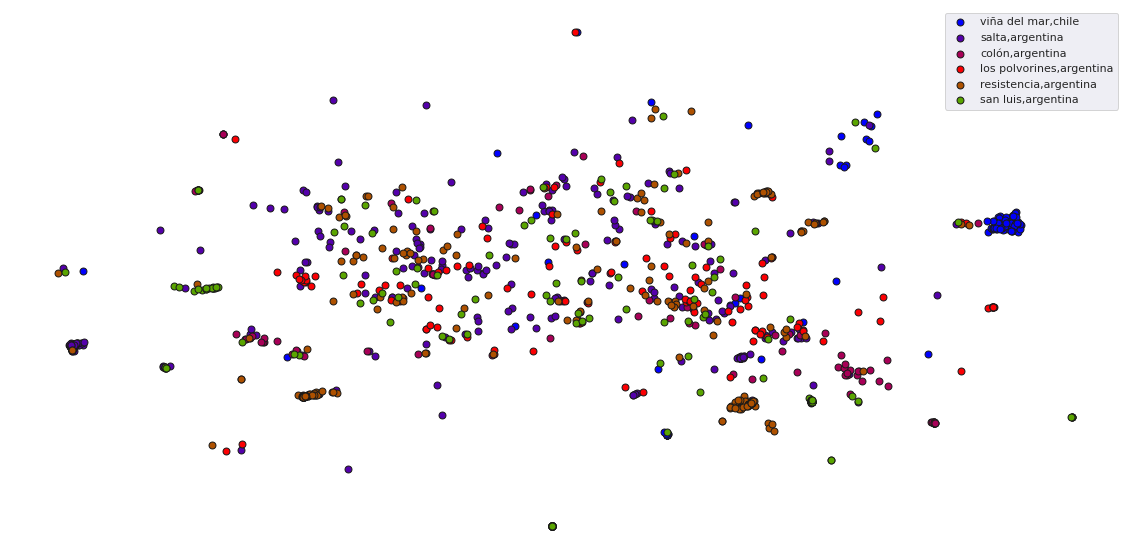

In [165]:
fig, ax = plt.subplots(figsize=(20, 10))

for target in plot_targets:
    ix = np.where(users_train_final["unified_place"].to_numpy() == target)
    ax.scatter(
        node2vec_tsne[:, 0][ix],
        node2vec_tsne[:, 1][ix],
        color=colors[target],
        label=target,
        s=48,
        alpha=1,
        edgecolor="k"
    )
    
ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")
ax.legend()
plt.show()

# Seguidores

In [119]:
cn_cross_val = CrossValidator(
    name="Seguidores Dirigidas Naive Bayes",
    clf=GridSearchCV(
        estimator=MultinomialNB(),
        param_grid={
            "alpha": [0.1, 0.5, 1.0, 2.0],
        },
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
)

net_probs_city = cn_cross_val.cross_predict(
    [vector_of_ac_follows],
    cities_true
)

cities_scores = get_all_metrics(cities_true_enc, net_probs_city, cn_cross_val.classes_order(), cities_with_coords)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'alpha': 0.1}


In [166]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    X_train = vector_of_ac_follows[X_train.index.to_numpy()]
    X_test = vector_of_ac_follows[X_test.index.to_numpy()]
    
    clf = GridSearchCV(
        estimator=MultinomialNB(),
        param_grid={
            "alpha": [0.1, 0.5, 1.0, 2.0],
        },
        cv=3,
        #n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=1
    )
    
    clf.fit(X_train, y_train)
    
    return clf, X_test
                
cn_cross_val = CrossValidator(
    name="Menciones No Dirigidas Naive Bayes",
)

net_probs_city = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, net_probs_city, cn_cross_val.classes_order(), cities_with_coords)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'alpha': 0.1}


In [167]:
print(count_score_city)

Accuracy: 0.36808808485435845        
Acc@161: 0.5755397620201368        
Balanced Acc: 0.1958258738723438        
ROC AUC Ovo: 0.6989577222595581        
Mean Dist Err: 904.3187321046864        
Median Dist Err: 25.41571007516044


Oslom

In [84]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    v = CountVectorizer(
        strip_accents=None,
        lowercase=False,
        #vocabulary=all_clusters,
        analyzer=lambda x: x
    )
    
    X_train = v.fit_transform(X_train["clusters_followers_0"]).astype(np.float32)
    X_test = v.transform(X_test["clusters_followers_0"]).astype(np.float32)
            
    clf=GridSearchCV(
        estimator=MultinomialNB(),
        param_grid={"alpha": [0.05, 0.1, 0.5, 1.0, 2.0]},
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
    
    clf.fit(X_train, y_train)
    
    return clf, X_test
    
cn_cross_val = CrossValidator(
    name="Seguidores Oslom #0",
)

follows_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, follows_preds, cn_cross_val.classes_order(), cities_with_coords, users_coords)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}


In [85]:
print(count_score_city)

Accuracy: 0.26126635438539814        
Acc@161: 0.42960211059064235        
Balanced Acc: 0.0716041961971205        
ROC AUC Ovo: 0.69430377751676        
Mean Dist Err: 1417.5008584669058        
Median Dist Err: 386.5426785476127


In [613]:
print(count_score_city)

Accuracy: 0.26126635438539814        
Acc@161: 0.42979055618370754        
Balanced Acc: 0.0716041961971205        
ROC AUC Ovo: 0.69430377751676        
Mean Dist Err: 1915.6307515821327        
Median Dist Err: 795.4205914099598


In [109]:
vectorizers_follows = []
vectors_of_clusters_follows = []

for i in range(total_clusters_follows):
    v = CountVectorizer(
        strip_accents=None,
        lowercase=False,
        #vocabulary=all_clusters,
        analyzer=lambda x: x
    )
    
    vectors_of_clusters_follows.append(
        v.fit_transform(users_train_final["clusters_followers_" + str(i)]).astype(np.float32)
    )
    
    vectorizers_follows.append(v)

vectors_of_clusters_follows

[<37146x556 sparse matrix of type '<class 'numpy.float32'>'
 	with 23269 stored elements in Compressed Sparse Row format>,
 <37146x94 sparse matrix of type '<class 'numpy.float32'>'
 	with 22677 stored elements in Compressed Sparse Row format>,
 <37146x17 sparse matrix of type '<class 'numpy.float32'>'
 	with 21925 stored elements in Compressed Sparse Row format>,
 <37146x4 sparse matrix of type '<class 'numpy.float32'>'
 	with 21772 stored elements in Compressed Sparse Row format>]

In [110]:
follows_all_preds = []
follows_cross_validators = []

i = 0

for clusters in vectors_of_clusters_follows:
    follows_cross_val = CrossValidator(
        name="Follower oslom #" + str(i),
        clf=GridSearchCV(
            estimator=MultinomialNB(),
            param_grid={"alpha": [0.05, 0.1, 0.5, 1.0, 2.0]},
            cv=3,
            n_jobs=-1,
            scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
            refit='roc_auc_ovo_weighted',
            verbose=3
        )
    )

    follows_preds = follows_cross_val.cross_predict(
        [clusters],
        cities_true 
    )
    
    follows_all_preds.append(follows_preds)
    follows_cross_validators.append(follows_cross_val)
    
    i += 1

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.5}
Fitting 3 folds 

In [124]:
print(get_all_metrics(cities_true_enc, follows_all_preds[0], follows_cross_val.classes_order(), cities_with_coords))

Accuracy: 0.26126635438539814        
Acc@161: 0.42987131858073546        
Balanced Acc: 0.0716041961971205        
ROC AUC Ovo: 0.6942944210951201        
Mean Dist Err: 1915.3136078812283        
Median Dist Err: 795.4205914099598


In [125]:
all_clusters_follows = None

for clusters in vectors_of_clusters_follows:
    all_clusters_follows = hstack([all_clusters_follows, clusters])

all_clusters_follows = all_clusters_follows.tocsr()
all_clusters_follows

<37146x671 sparse matrix of type '<class 'numpy.float32'>'
	with 89643 stored elements in Compressed Sparse Row format>

In [126]:
follows_cross_val = CrossValidator(
    name="Mentions oslom",
    clf=GridSearchCV(
        estimator=MultinomialNB(),
        param_grid={"alpha": [0.05, 0.1, 0.5, 1.0, 2.0]},
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
)

follows_preds = follows_cross_val.cross_predict(
    [all_clusters_follows],
    cities_true 
)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.5}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.5}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.5}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.5}


In [127]:
print(get_all_metrics(cities_true_enc, follows_preds, follows_cross_val.classes_order(), cities_with_coords))

Accuracy: 0.2491519948312066        
Acc@161: 0.40510418349216604        
Balanced Acc: 0.073778314215082        
ROC AUC Ovo: 0.7002045984890926        
Mean Dist Err: 1955.4475342203111        
Median Dist Err: 845.5216661441096


In [292]:
node2vec_fol_pec_embs = node2vec_pecanpy(vector_of_col_follows, num_walks=20, length_walks=100, p=1.0, q=0.5)

Took 00:00:02.35 to load graph
Took 00:00:00.00 to pre-compute transition probabilities
Took 00:01:26.00 to generate walks
Took 00:01:22.01 to train embeddings


In [113]:
#with open('../../tmp_paper/node2vec_fol_pec_embs.pickle', 'wb') as handle:
#    pickle.dump(node2vec_fol_pec_embs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [131]:
with open('../../tmp_paper/node2vec_fol_pec_embs.pickle', 'rb') as handle:
    node2vec_fol_pec_embs = pickle.load(handle)

In [293]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    X_train = node2vec_fol_pec_embs[X_train.index.to_numpy()]
    X_test = node2vec_fol_pec_embs[X_test.index.to_numpy()]
    
    clf=GridSearchCV(
        estimator=LogisticRegression(random_state=35,n_jobs=-1),
        param_grid={'C': [0.05, 0.1, 0.5, 1.0]},
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
    
    clf.fit(X_train, y_train)
    
    return clf, X_test
    
cn_cross_val = CrossValidator(
    name="Node2vec follows"
)

node2vec_follows_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, node2vec_follows_preds, cn_cross_val.classes_order(), cities_with_coords, users_coords)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'C': 0.5}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'C': 0.5}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'C': 0.5}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'C': 0.5}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'C': 0.5}


In [294]:
# Pesado
print("Nodevec Cities Follows")
print(count_score_city)

Nodevec Cities Follows
Accuracy: 0.39183222958057395        
Acc@161: 0.5985570451731007        
Balanced Acc: 0.1976827186495189        
ROC AUC Ovo: 0.7739790889643664        
Mean Dist Err: 865.509371779742        
Median Dist Err: 21.655645283457073


In [172]:
print("Nodevec Cities Follows")
print(count_score_city)

Nodevec Cities Follows
Accuracy: 0.38809023851827923        
Acc@161: 0.5959995692672159        
Balanced Acc: 0.187838923571584        
ROC AUC Ovo: 0.7719681215244546        
Mean Dist Err: 860.973559023903        
Median Dist Err: 20.848961175152088


In [381]:
#with open('../../tmp_paper/node2vec_follows_preds.pickle', 'wb') as handle:
#    pickle.dump(node2vec_follows_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [111]:
with open('../../tmp_paper/node2vec_follows_preds.pickle', 'rb') as handle:
    node2vec_follows_preds = pickle.load(handle)

# Menciones + seguidores

Infomap multicapa

In [174]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    v = CountVectorizer(
        strip_accents=None,
        lowercase=False,
        #vocabulary=all_clusters,
        analyzer=lambda x: x
    )
    
    X_train = v.fit_transform(X_train["clusters_infomap"]).astype(np.float32)
    X_test = v.transform(X_test["clusters_infomap"]).astype(np.float32)
            
    clf=GridSearchCV(
        estimator=MultinomialNB(),
        param_grid={"alpha": [0.05, 0.1, 0.5, 1.0, 2.0]},
        cv=3,
        #n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=1
    )
    
    clf.fit(X_train, y_train)
    
    return clf, X_test
    
cn_cross_val = CrossValidator(
    name="Menciones/Seguidores Infomap #0",
)

net_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, net_preds, cn_cross_val.classes_order(), cities_with_coords)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.05}


In [175]:
print(count_score_city)

Accuracy: 0.37481828460668715        
Acc@161: 0.5884617455446077        
Balanced Acc: 0.16908722507284596        
ROC AUC Ovo: 0.7567708984180359        
Mean Dist Err: 768.8739582945353        
Median Dist Err: 25.143908664557966


# Semi-completo: Menciones + Contenido

In [112]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    train_idxs = X_train.index.to_numpy()
    test_idxs = X_test.index.to_numpy()
    
    total_preds_train = transformer_preds[train_idxs]
    
    total_preds_train = np.concatenate(
        (total_preds_train, node2vec_mentions_preds[train_idxs]), axis=1)
    
    total_preds_test = transformer_preds[test_idxs]
    
    total_preds_test = np.concatenate(
        (total_preds_test, node2vec_mentions_preds[test_idxs]), axis=1)
        
    clf=GridSearchCV(
        estimator=LogisticRegression(random_state=35,n_jobs=-1),
        param_grid={'C': [0.1, 0.5, 1.0, 2.0, 4.0]},
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
    
    clf.fit(total_preds_train, y_train)
    
    return clf, total_preds_test
    
cn_cross_val = CrossValidator(
    name="Meta classifier solo Menciones y contenido",
)

nb_prob = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, nb_prob, cn_cross_val.classes_order(), cities_with_coords, users_coords)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}


In [113]:
print(count_score_city)

Accuracy: 0.7053787756420611        
Acc@161: 0.8196306466375922        
Balanced Acc: 0.5963298304141861        
ROC AUC Ovo: 0.948952351652766        
Mean Dist Err: 388.6055197863042        
Median Dist Err: 4.145845322505071


In [119]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    train_idxs = X_train.index.to_numpy()
    test_idxs = X_test.index.to_numpy()
    
    total_preds_train = content_preds[train_idxs]
    
    total_preds_train = np.concatenate(
        (total_preds_train, node2vec_mentions_preds[train_idxs]), axis=1)
    
    total_preds_test = content_preds[test_idxs]
    
    total_preds_test = np.concatenate(
        (total_preds_test, node2vec_mentions_preds[test_idxs]), axis=1)
        
    clf=GridSearchCV(
        estimator=LogisticRegression(random_state=35,n_jobs=-1),
        param_grid={'C': [0.1, 0.5, 1.0, 2.0, 4.0]},
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
    
    clf.fit(total_preds_train, y_train)
    
    return clf, total_preds_test
    
cn_cross_val = CrossValidator(
    name="Meta classifier solo Menciones y contenido",
)

nb_prob = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, nb_prob, cn_cross_val.classes_order(), cities_with_coords, users_coords)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}


In [120]:
print(count_score_city)

Accuracy: 0.7223388790179293        
Acc@161: 0.8272492327572283        
Balanced Acc: 0.6238555020012289        
ROC AUC Ovo: 0.9497373714607322        
Mean Dist Err: 374.8558324469884        
Median Dist Err: 3.949478032898317


# Completo: Menciones + contenido + seguidores

In [114]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    train_idxs = X_train.index.to_numpy()
    test_idxs = X_test.index.to_numpy()
    
    total_preds_train = transformer_preds[train_idxs]
    
    total_preds_train = np.concatenate(
        (total_preds_train, node2vec_mentions_preds[train_idxs], node2vec_follows_preds[train_idxs]), axis=1)
    
    total_preds_test = transformer_preds[test_idxs]
    
    total_preds_test = np.concatenate(
        (total_preds_test, node2vec_mentions_preds[test_idxs], node2vec_follows_preds[test_idxs]), axis=1)
        
    clf=GridSearchCV(
        estimator=LogisticRegression(random_state=35,n_jobs=-1),
        param_grid={'C': [0.1, 0.5, 1.0, 2.0, 4.0]},
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
    
    clf.fit(total_preds_train, y_train)
    
    return clf, total_preds_test
    
cn_cross_val = CrossValidator(
    name="Meta classifier solo Menciones y contenido",
)

nb_prob = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, nb_prob, cn_cross_val.classes_order(), cities_with_coords, users_coords)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}


In [115]:
print(count_score_city)

Accuracy: 0.7103052818607656        
Acc@161: 0.825176331233511        
Balanced Acc: 0.603393710318765        
ROC AUC Ovo: 0.9517888716020436        
Mean Dist Err: 379.07221067430584        
Median Dist Err: 4.051051626709029


In [117]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    train_idxs = X_train.index.to_numpy()
    test_idxs = X_test.index.to_numpy()
    
    total_preds_train = content_preds[train_idxs]
    
    total_preds_train = np.concatenate(
        (total_preds_train, node2vec_mentions_preds[train_idxs], node2vec_follows_preds[train_idxs]), axis=1)
    
    total_preds_test = content_preds[test_idxs]
    
    total_preds_test = np.concatenate(
        (total_preds_test, node2vec_mentions_preds[test_idxs], node2vec_follows_preds[test_idxs]), axis=1)
        
    clf=GridSearchCV(
        estimator=LogisticRegression(random_state=35,n_jobs=-1),
        param_grid={'C': [0.1, 0.5, 1.0, 2.0, 4.0]},
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
    
    clf.fit(total_preds_train, y_train)
    
    return clf, total_preds_test
    
cn_cross_val = CrossValidator(
    name="Meta classifier solo Menciones y contenido",
)

nb_prob = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, nb_prob, cn_cross_val.classes_order(), cities_with_coords, users_coords)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'C': 4.0}


In [118]:
print(count_score_city)

Accuracy: 0.7267808108544661        
Acc@161: 0.8317180853927745        
Balanced Acc: 0.6300609853191637        
ROC AUC Ovo: 0.9527223702020508        
Mean Dist Err: 371.4528674210856        
Median Dist Err: 3.9054288435796742


Metodo completo

In [127]:
def create_complete_model(
    optimizer, num_classes, input_text_length, embeddings_text, words_dim, embedding_text_dim, input_mentions_length,
    embeddings_mentions, mentions_dim, embeddings_mentions_dim, input_follows_length, embeddings_follows,
    follows_dim, embeddings_follows_dim
):
    clear_session()
    
    nlp_input = Input(shape=(input_text_length, ))
    nlp_emb = Embedding(words_dim, embedding_text_dim, input_length=input_text_length, 
                    weights=[embeddings_text],trainable=False)(nlp_input)
    sdrop = SpatialDropout1D(0.4)(nlp_emb)
    nlp_output = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(sdrop)
    #nlp_output = Attention(use_scale=True)([nlp_output, nlp_output])
    
    nlp_output = MultiHeadAttention(num_heads=6, key_dim=6)(nlp_output, nlp_output)
        
    nlp_output = Flatten()(nlp_output)
    
    mentions_input = Input(shape=(input_mentions_length, ))
    mentions_emb = Embedding(input_dim=mentions_dim, output_dim=embeddings_mentions_dim, 
                    weights=[embeddings_mentions],trainable=False)(mentions_input)
    
    mentions_sdrop = SpatialDropout1D(0.2)(mentions_emb)
    
    mentions_output = MultiHeadAttention(num_heads=6, key_dim=6)(mentions_sdrop, mentions_sdrop)
    
    mentions_output = Flatten()(mentions_output)
    
    #mentions_output = Attention(use_scale=True)([mentions_output, mentions_output])
    #mentions_output = MultiHeadAttention(num_heads=2, key_dim=2)((mentions_output, mentions_output))
    
    follows_input = Input(shape=(input_follows_length, ))
    follows_emb = Embedding(input_dim=follows_dim, output_dim=embeddings_follows_dim, 
                    weights=[embeddings_follows],trainable=False)(follows_input)
    
    follows_sdrop = SpatialDropout1D(0.2)(follows_emb)
    
    follows_output = MultiHeadAttention(num_heads=6, key_dim=6)(follows_sdrop, follows_sdrop)
    
    follows_output = Flatten()(follows_output)
    
    #follows_output = Attention(use_scale=True)([follows_output, follows_output])
        
    concat = Concatenate()([nlp_output, mentions_output, follows_output])
    output = Dense(num_classes, activation='softmax')(concat)

    model = Model(inputs=[nlp_input, mentions_input, follows_input], outputs=[output])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

In [443]:
model = create_complete_model(
    "adam", sequence_length, embeddings, len(tokenizer.word_index) + 1, embedding_dim, 1,
    node2vec_pec_embs, len(users_ids), node2vec_pec_embs.shape[1], 1,
    node2vec_fol_pec_embs, len(users_ids), node2vec_fol_pec_embs.shape[1]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 64)      3368704     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [ ]:
model.fit([input_w2v_nlp, np.arange(len(users_ids)), np.arange(len(users_ids))], cities_true)

In [ ]:
def preprocess(fold):   
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
    
    train_tweets = X_train["all_tweets"].to_numpy()
    val_tweets = X_val["all_tweets"].to_numpy()
    test_tweets = X_test["all_tweets"].to_numpy()
    
    train_idxs = X_train.index.to_numpy()
    val_idxs = X_val.index.to_numpy()
    test_idxs = X_test.index.to_numpy()
    
    X_train_nlp = tokenizer.texts_to_sequences(train_tweets)
    X_train_nlp = pad_sequences(X_train_nlp, maxlen=sequence_length, truncating='post', padding='pre')
    
    X_val_nlp = tokenizer.texts_to_sequences(val_tweets)
    X_val_nlp = pad_sequences(X_val_nlp, maxlen=sequence_length, truncating='post', padding='pre')
    
    X_test_nlp = tokenizer.texts_to_sequences(test_tweets)
    X_test_nlp = pad_sequences(X_test_nlp, maxlen=sequence_length, truncating='post', padding='pre')    
    
    X_train = [X_train_nlp, train_idxs, train_idxs]
    X_val = [X_val_nlp, val_idxs, val_idxs]
    X_test = [X_test_nlp, test_idxs, test_idxs]

    clf = create_complete_model(
        input_text_length=sequence_length,
        embeddings_text=embeddings,
        embedding_text_dim=embedding_dim,
        words_dim=len(tokenizer.word_index) + 1,
    
        input_mentions_length=1,
        embeddings_mentions=node2vec_pec_embs,
        mentions_dim=len(users_ids),
        embeddings_mentions_dim=node2vec_pec_embs.shape[1],
        
        input_follows_length=1,
        embeddings_follows=node2vec_fol_pec_embs,
        follows_dim=len(users_ids),
        embeddings_follows_dim=node2vec_fol_pec_embs.shape[1],
        
        optimizer="adam",
    )
    
    clf.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, restore_best_weights=True)],
        epochs=100,
        batch_size=64        
    )
    
    return clf, X_test

cn_cross_val = KerasCrossValidator(
    name="Complete Model",
    encoder=LabelBinarizer()
)

complete_preds = cn_cross_val.cross_predict(
    folds,
    test_idx,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, complete_preds, cn_cross_val.classes_order(), cities_with_coords)

Epoch 1/100
418/418 - 190s - loss: 3.0418 - accuracy: 0.3455 - val_loss: 2.2484 - val_accuracy: 0.4933
Epoch 2/100
418/418 - 187s - loss: 2.1037 - accuracy: 0.5172 - val_loss: 1.7429 - val_accuracy: 0.5935
Epoch 3/100
418/418 - 187s - loss: 1.8314 - accuracy: 0.5731 - val_loss: 1.6040 - val_accuracy: 0.6292
Epoch 4/100
418/418 - 187s - loss: 1.6954 - accuracy: 0.6030 - val_loss: 1.5538 - val_accuracy: 0.6521
Epoch 5/100
418/418 - 187s - loss: 1.6111 - accuracy: 0.6218 - val_loss: 1.5046 - val_accuracy: 0.6592
Epoch 6/100
418/418 - 187s - loss: 1.5313 - accuracy: 0.6367 - val_loss: 1.4564 - val_accuracy: 0.6662
Epoch 7/100
418/418 - 186s - loss: 1.4860 - accuracy: 0.6479 - val_loss: 1.4747 - val_accuracy: 0.6672
Epoch 8/100
418/418 - 187s - loss: 1.4285 - accuracy: 0.6584 - val_loss: 1.4224 - val_accuracy: 0.6753
Epoch 9/100
418/418 - 187s - loss: 1.3918 - accuracy: 0.6663 - val_loss: 1.4544 - val_accuracy: 0.6736
Epoch 10/100
418/418 - 187s - loss: 1.3514 - accuracy: 0.6729 - val_loss:

In [445]:
print(count_score_city)

Accuracy: 0.6905454153879287        
Acc@161: 0.8233457169008777        
Balanced Acc: 0.5790268948626763        
ROC AUC Ovo: 0.9563300004053908        
Mean Dist Err: 1182.959290704333        
Median Dist Err: 303.3777264439395


In [446]:
#with open('../../tmp_paper/complete_preds.pickle', 'wb') as handle:
#    pickle.dump(complete_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('../../tmp_paper/complete_preds.pickle', 'rb') as handle:
#    complete_preds = pickle.load(handle)

Transformer + NET

In [147]:
def create_complete_transformer_model(
    optimizer, num_classes, input_text_length, vocab_size, embed_text_dim, ff_dim, num_heads, input_mentions_length,
    embeddings_mentions, mentions_dim, embeddings_mentions_dim, input_follows_length, embeddings_follows,
    follows_dim, embeddings_follows_dim, embeddings_nlp
):
    clear_session()
    
    nlp_input = Input(shape=(input_text_length, ))
    
    nlp_emb = TokenAndPositionEmbeddingPreTrain(input_text_length, vocab_size, embed_text_dim, embeddings_nlp)(nlp_input)
        
    nlp_transformer = TransformerBlock(embed_text_dim, num_heads, ff_dim)(nlp_emb)
    
    nlp_gap = GlobalAveragePooling1D()(nlp_transformer)
    nlp_output = Dropout(0.1)(nlp_gap)
        
    mentions_input = Input(shape=(input_mentions_length, ))
    mentions_emb = Embedding(input_dim=mentions_dim, output_dim=embeddings_mentions_dim, 
                    weights=[embeddings_mentions],trainable=False)(mentions_input)
    
    mentions_sdrop = SpatialDropout1D(0.1)(mentions_emb)
    
    mentions_output = MultiHeadAttention(num_heads=num_heads, key_dim=embeddings_mentions_dim)(mentions_sdrop, mentions_sdrop)
    
    mentions_output = Flatten()(mentions_output)
    
    follows_input = Input(shape=(input_follows_length, ))
    follows_emb = Embedding(input_dim=follows_dim, output_dim=embeddings_follows_dim, 
                    weights=[embeddings_follows],trainable=False)(follows_input)
    
    follows_sdrop = SpatialDropout1D(0.1)(follows_emb)
    
    follows_output = MultiHeadAttention(num_heads=num_heads, key_dim=embeddings_follows_dim)(follows_sdrop, follows_sdrop)
    
    follows_output = Flatten()(follows_output)
            
    concat = Concatenate()([nlp_output, mentions_output, follows_output])
    
    #concat = Dense(150, activation='relu')(concat)
    
    final_emb = TokenAndPositionEmbedding(input_text_length, vocab_size, embed_text_dim)(concat)    
    final_emb = TransformerBlock(embed_text_dim, num_heads, ff_dim)(final_emb)
    
    #final_emb = Embedding(input_dim=embed_text_dim + mentions_dim + follows_dim, output_dim=32)(concat)
    
    #final_emb = TransformerBlock(128, num_heads, ff_dim)(final_emb)
    
    #final_emb = GlobalAveragePooling1D()(final_emb)
    #final_emb = Dropout(0.1)(final_emb)
    
    final_emb = GlobalAveragePooling1D()(final_emb)
    final_emb = Dropout(0.1)(final_emb)
    
    output = Dense(num_classes, activation='softmax')(final_emb)

    model = Model(inputs=[nlp_input, mentions_input, follows_input], outputs=[output])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

In [222]:
class TokenAndPositionMulEmbeddingPreTrain(layers.Layer):
    def __init__(self, maxlen, vocab_size1, vocab_size2, vocab_size3,
                 embed_dim1, embed_dim2, embed_dim3, weights1, weights2, weights3
    ):
        super(TokenAndPositionMulEmbeddingPreTrain, self).__init__()
        self.token_emb1 = layers.Embedding(input_dim=vocab_size1, output_dim=embed_dim1, weights=[weights1], trainable=True)
        self.token_emb2 = layers.Embedding(input_dim=vocab_size2, output_dim=embed_dim2, weights=[weights2], trainable=False)
        self.token_emb3 = layers.Embedding(input_dim=vocab_size3, output_dim=embed_dim3, weights=[weights3], trainable=False)
        
        self.dense = Dense(embed_dim1, activation='relu')
        
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim1)
        
    def call(self, x1, x2, x3):
        # same for all inputs
        maxlen = tf.shape(x1)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        
        x1 = self.token_emb1(x1)
        x2 = self.token_emb2(x2)
        x2 = self.dense(x2)
        x3 = self.token_emb3(x3)
        x3 = self.dense(x3)
        
        x = layers.Add()([x1, x2, x3])
       
        return x + positions

In [223]:
def create_complete_tf_model(
    optimizer, num_classes, input_length, vocab_size_text, vocab_size_net, embed_text_dim, ff_dim, num_heads, embeddings_nlp,
    embeddings_mentions, embed_mentions_dim, embeddings_follows, embed_follows_dim
):
    clear_session()

    nlp_input = Input(shape=(input_length, ))
    mentions_input = Input(shape=(input_length, ))
    follows_input = Input(shape=(input_length, ))
    
    emb = TokenAndPositionMulEmbeddingPreTrain(
        input_length,
        vocab_size_text,
        vocab_size_net,
        vocab_size_net,
        embed_text_dim,
        embed_mentions_dim,
        embed_follows_dim,
        embeddings_nlp,
        embeddings_mentions,
        embeddings_follows
    )(
        nlp_input, mentions_input, follows_input
    )
        
    transformer = TransformerBlock(embed_text_dim, num_heads, ff_dim)(emb)
    
    gap = GlobalAveragePooling1D()(transformer)
    drop = Dropout(0.1)(gap)

    output = Dense(num_classes, activation='softmax')(drop)

    model = Model(inputs=[nlp_input, mentions_input, follows_input], outputs=[output])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

In [224]:
model = create_complete_tf_model(        
    num_classes=total_cities,
        
    input_length=256,
    vocab_size_text=40000,
    vocab_size_net=len(users_ids),
    ff_dim=32,
    num_heads=6,
        
    embeddings_nlp=np.zeros(shape=(40000, 32)),
    embeddings_mentions=node2vec_pec_embs,
    embeddings_follows=node2vec_fol_pec_embs,
    
    embed_text_dim=32,
    embed_mentions_dim=node2vec_pec_embs.shape[1],
    embed_follows_dim=node2vec_fol_pec_embs.shape[1],
        
    optimizer="adam",
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
token_and_position_mul_embeddin (None, 256, 32)      10801696    input_1[0][0]                    
                                                                 input_2[0][0]                

In [148]:
model = create_complete_transformer_model(
    "adam", total_cities, 256, 40000, 32, 32, 6, 1,
    node2vec_pec_embs, len(users_ids), node2vec_pec_embs.shape[1], 1,
    node2vec_fol_pec_embs, len(users_ids), node2vec_fol_pec_embs.shape[1], embeddings_nlp=np.zeros(shape=(40000, 32))
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_and_position_embedding_pr (None, 256, 32)      1288192     input_1[0][0]                    
______________________________________________________________________________________________

In [225]:
def parse_stopwords(row, av_words):
    tweets = row["all_tweets"].lower()

    return ' '.join([word for word in re.split("\W+", tweets) if word in av_words])

def preprocess(fold):   
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
    
    vectorizer = CountVectorizer(
        #strip_accents='unicode',
        strip_accents=None,
        lowercase=True,
        #max_df=0.3,
        min_df=10,
        dtype=np.uint8
    )
    
    train_tweets = X_train["all_tweets"].to_numpy()
    val_tweets = X_val["all_tweets"].to_numpy()
    test_tweets = X_test["all_tweets"].to_numpy()
    
    vector_of_words = vectorizer.fit_transform(train_tweets)
    
    av_words = set(vectorizer.get_feature_names())

    train_tweets = X_train.apply(parse_stopwords, axis=1, av_words=av_words).to_numpy()
    
    tweets_filtered_list = list(map(lambda x: x.split(' '), train_tweets))
    
    print("Generated vocabulary")
    
    tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(tweets_filtered_list)
    
    print('Tokens unicos %s' % len(tokenizer.word_index))
    print('Embedding dim recomendado: ', len(tokenizer.word_index)**(1/4))    
    
    embedding_dim = 32
    sequence_length = 256
        
    word2vec = Word2Vec(
        tweets_filtered_list,
        vector_size=embedding_dim,
        window=5,
        min_count=0,
        sg=1,
        workers=6,
        epochs=10
    )
    
    embeddings = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

    for word, idx in tokenizer.word_index.items():
        try:
            embeddings[idx] =  word2vec.wv[word]
        except:
            pass
        
    print("Word2vec end")
    
    train_idxs = X_train.index.to_numpy()
    val_idxs = X_val.index.to_numpy()
    test_idxs = X_test.index.to_numpy()
    
    X_train_nlp = tokenizer.texts_to_sequences(train_tweets)
    X_train_nlp = pad_sequences(X_train_nlp, maxlen=sequence_length, truncating='post', padding='pre')
    
    X_val_nlp = tokenizer.texts_to_sequences(val_tweets)
    X_val_nlp = pad_sequences(X_val_nlp, maxlen=sequence_length, truncating='post', padding='pre')
    
    X_test_nlp = tokenizer.texts_to_sequences(test_tweets)
    X_test_nlp = pad_sequences(X_test_nlp, maxlen=sequence_length, truncating='post', padding='pre')    
    
    #X_train = [X_train_nlp, train_idxs, train_idxs]
    #X_val = [X_val_nlp, val_idxs, val_idxs]
    #X_test = [X_test_nlp, test_idxs, test_idxs]

    train_new_idxs = np.zeros(shape=(len(train_idxs), sequence_length), dtype=np.uint8)
    train_new_idxs[:, -1] = train_idxs
    
    val_new_idxs = np.zeros(shape=(len(val_idxs), sequence_length), dtype=np.uint8)
    val_new_idxs[:, -1] = val_idxs
    
    test_new_idxs = np.zeros(shape=(len(test_idxs), sequence_length), dtype=np.uint8)
    test_new_idxs[:, -1] = test_idxs
    
    X_train = [X_train_nlp, train_new_idxs, train_new_idxs]
    X_val = [X_val_nlp, val_new_idxs, val_new_idxs]
    X_test = [X_test_nlp, test_new_idxs, test_new_idxs]
    
    '''clf = create_complete_transformer_model(        
        num_classes=total_cities,
        
        input_text_length=sequence_length,
        vocab_size=len(tokenizer.word_index) + 1,
        embed_text_dim=embedding_dim,
        ff_dim=32,
        num_heads=6,
        
        embeddings_nlp=embeddings,
    
        input_mentions_length=1,
        embeddings_mentions=node2vec_pec_embs,
        mentions_dim=len(users_ids),
        embeddings_mentions_dim=node2vec_pec_embs.shape[1],
        
        input_follows_length=1,
        embeddings_follows=node2vec_fol_pec_embs,
        follows_dim=len(users_ids),
        embeddings_follows_dim=node2vec_fol_pec_embs.shape[1],
        
        optimizer="adam",
    )'''
    clf = create_complete_tf_model(        
        num_classes=total_cities,

        input_length=sequence_length,
        vocab_size_text=len(tokenizer.word_index) + 1,
        vocab_size_net=len(users_ids),
        ff_dim=32,
        num_heads=6,

        embeddings_nlp=embeddings,
        embeddings_mentions=node2vec_pec_embs,
        embeddings_follows=node2vec_fol_pec_embs,

        embed_text_dim=32,
        embed_mentions_dim=node2vec_pec_embs.shape[1],
        embed_follows_dim=node2vec_fol_pec_embs.shape[1],

        optimizer="adam",
    )
    
    clf.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001, restore_best_weights=True)],
        epochs=100,
        batch_size=64        
    )
    
    return clf, X_test

cn_cross_val = KerasCrossValidator(
    name="Complete Model",
    encoder=LabelBinarizer()
)

complete_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, complete_preds, cn_cross_val.classes_order(), cities_with_coords, users_coords)

Generated vocabulary
Tokens unicos 21490
Embedding dim recomendado:  12.107628971155853
Word2vec end
Epoch 1/100
418/418 [==============================] - 149s 355ms/step - loss: 3.1637 - accuracy: 0.3584 - val_loss: 2.2758 - val_accuracy: 0.5175
Epoch 2/100
418/418 [==============================] - 148s 354ms/step - loss: 1.9978 - accuracy: 0.5829 - val_loss: 1.8404 - val_accuracy: 0.6147
Epoch 3/100
418/418 [==============================] - 148s 354ms/step - loss: 1.6589 - accuracy: 0.6510 - val_loss: 1.7028 - val_accuracy: 0.6491
Epoch 4/100
418/418 [==============================] - 148s 354ms/step - loss: 1.4848 - accuracy: 0.6818 - val_loss: 1.6894 - val_accuracy: 0.6494
Epoch 5/100
418/418 [==============================] - 148s 355ms/step - loss: 1.3485 - accuracy: 0.7074 - val_loss: 1.7454 - val_accuracy: 0.6474
Epoch 6/100
 20/418 [>.............................] - ETA: 2:14 - loss: 1.1527 - accuracy: 0.7430

KeyboardInterrupt: 

In [232]:
print(count_score_city)

Accuracy: 0.688768642653314        
Acc@161: 0.8086738814408012        
Balanced Acc: 0.569606276388973        
ROC AUC Ovo: 0.9528290685839242        
Mean Dist Err: 416.8063205366012        
Median Dist Err: 0.0


# Preparación GCN, etc...

In [973]:
top_n_rows = top_n_idx_sparse(vector_of_mentions_local, 10)

In [974]:
top_ad_rows = top_n_idx_sparse(vector_of_co_mentions, 10)

for x, i in zip(top_n_rows, range(len(users_ids))):
    if len(x) != 10:
        tmp = set(x)
        tmp |= set(top_ad_rows[i])
        
        top_n_rows[i] = np.array(list(tmp))

In [47]:
def top_n_idx_sparse(matrix, n):
    top_n_idx = []
    for le, ri in zip(matrix.indptr[:-1], matrix.indptr[1:]):
        n_row_pick = min(n, ri - le)
        top_n_idx.append(matrix.indices[le + np.argpartition(matrix.data[le:ri], -n_row_pick)[-n_row_pick:]])
    return top_n_idx

In [48]:
top_n_rows = top_n_idx_sparse(vector_of_col_mentions, 100)

Tenemos 3419 usuarios sin menciones

In [49]:
y = 0
for x in top_n_rows:
    if len(x) == 0:
        y += 1
y

3419

In [50]:
cx = vector_of_col_follows.tocoo()

edges_tails = []
edges_head = []
edges_weight = []

already_passed = {}

for i in range(vector_of_col_follows.shape[0]):
    already_passed[i] = set()

for i,j,v in zip(cx.row, cx.col, cx.data):
    already_passed[i].add(j)

    if i in already_passed[j]:
        continue
    
    #edges_tails.append(users_ids[i])
    #edges_head.append(users_ids[j])
    edges_tails.append(i)
    edges_head.append(j)
    edges_weight.append(v)

In [51]:
colfollows_edges = pd.DataFrame({"source": edges_tails, "target": edges_head, "weight": edges_weight})
colfollows_edges.head(6)

,source,target,weight
0,1,2457,1
1,1,2624,1
2,1,3106,1
3,1,5069,1
4,1,9439,1
5,1,14429,1


In [52]:
cx = vector_of_col_mentions.tocoo()

edges_tails = []
edges_head = []
edges_weight = []

for i,j,v in zip(cx.row, cx.col, cx.data):    
    if j not in top_n_rows[i]:
        continue
    
    #edges_tails.append(users_ids[i])
    #edges_head.append(users_ids[j])
    edges_tails.append(i)
    edges_head.append(j)    
    edges_weight.append(v)

In [53]:
colmentions_edges_short = pd.DataFrame({"source": edges_tails, "target": edges_head, "weight": edges_weight})
colmentions_edges_short.head(6)

,source,target,weight
0,0,179,1
1,0,1663,1
2,0,9775,1
3,0,13214,1
4,0,22376,1
5,2,141,1


In [54]:
cx = vector_of_col_mentions.tocoo()

edges_tails = []
edges_head = []
edges_weight = []

already_passed = {}

for i in range(vector_of_col_mentions.shape[0]):
    already_passed[i] = set()

for i,j,v in zip(cx.row, cx.col, cx.data):
    already_passed[i].add(j)

    if i in already_passed[j]:
        continue
    
    #edges_tails.append(users_ids[i])
    #edges_head.append(users_ids[j])
    edges_tails.append(i)
    edges_head.append(j)
    edges_weight.append(v)

In [55]:
colmentions_edges_normal = pd.DataFrame(
    {"source": edges_tails, "target": edges_head, "weight": edges_weight}
)
colmentions_edges_normal.head(2)

,source,target,weight
0,0,179,1
1,0,1663,1


In [86]:
#with open(tmp_save + 'colmentions_edges_arg.pickle', 'wb') as handle:
#    pickle.dump(colmentions_edges_normal, handle, protocol=4)  

with open(tmp_save + 'colmentions_edges_arg.pickle', 'rb') as handle:
    colmentions_edges_normal = pickle.load(handle)

In [56]:
colmentions_edges = pd.DataFrame(
    {"source": edges_tails, "target": edges_head, "weight": edges_weight},
    index=np.arange(len(colfollows_edges), len(edges_tails) + len(colfollows_edges))
)
colmentions_edges.head(6)

,source,target,weight
1441746,0,179,1
1441747,0,1663,1
1441748,0,9775,1
1441749,0,13214,1
1441750,0,22376,1
1441751,2,141,1


In [267]:
cx = vector_of_mentions_undir_local.tocoo()

edges_tails = []
edges_head = []
edges_weight = []

already_passed = {}

for i in range(vector_of_mentions_undir_local.shape[0]):
    already_passed[i] = set()

for i,j,v in zip(cx.row, cx.col, cx.data):
    already_passed[i].add(j)

    if i in already_passed[j]:
        continue
    
    #edges_tails.append(users_ids[i])
    #edges_head.append(users_ids[j])
    edges_tails.append(i)
    edges_head.append(j)
    edges_weight.append(v)

In [268]:
local_mentions_edges_normal = pd.DataFrame(
    {"source": edges_tails, "target": edges_head, "weight": edges_weight}
)
local_mentions_edges_normal.head(2)

,source,target,weight
0,2,6386,1
1,2,30907,3


In [270]:
cx = vector_of_comentions_ext.tocoo()

edges_tails = []
edges_head = []
edges_weight = []

already_passed = {}

for i in range(vector_of_comentions_ext.shape[0]):
    already_passed[i] = set()

for i,j,v in zip(cx.row, cx.col, cx.data):
    already_passed[i].add(j)

    if i in already_passed[j]:
        continue
    
    #edges_tails.append(users_ids[i])
    #edges_head.append(users_ids[j])
    edges_tails.append(i)
    edges_head.append(j)
    edges_weight.append(v)

In [271]:
co_ext_mentions_edges = pd.DataFrame(
    {"source": edges_tails, "target": edges_head, "weight": edges_weight},
    index=np.arange(len(local_mentions_edges_normal), len(edges_tails) + len(local_mentions_edges_normal))
)
co_ext_mentions_edges.head(2)

,source,target,weight
43407,0,22376,1
43408,0,13214,1


In [274]:
#nodes_content_preds = sg.IndexedArray(preds_prob, index=users_ids)
nodes_content_preds = sg.IndexedArray(content_preds, index=np.arange(len(users_ids)))

In [62]:
colfollows_graph = sg.StellarGraph(nodes_content_preds, colfollows_edges)
print(colfollows_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 37146, Edges: 1441746

 Node types:
  default: [37146]
    Features: float64 vector, length 95
    Edge types: default-default->default

 Edge types:
    default-default->default: [1441746]
        Weights: all 1 (default)
        Features: none


In [63]:
colmentions_graph_short = sg.StellarGraph(nodes_content_preds, colmentions_edges_short)
print(colmentions_graph_short.info())

StellarGraph: Undirected multigraph
 Nodes: 37146, Edges: 2462115

 Node types:
  default: [37146]
    Features: float64 vector, length 95
    Edge types: default-default->default

 Edge types:
    default-default->default: [2462115]
        Weights: range=[1, 253], mean=3.13751, std=7.38625
        Features: none


In [64]:
colmentions_graph = sg.StellarGraph(nodes_content_preds, colmentions_edges_normal)
print(colmentions_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 37146, Edges: 4524003

 Node types:
  default: [37146]
    Features: float64 vector, length 95
    Edge types: default-default->default

 Edge types:
    default-default->default: [4524003]
        Weights: range=[1, 253], mean=1.77775, std=4.04455
        Features: none


In [65]:
multilayer_graph = sg.StellarGraph(
    nodes_content_preds, {"follows": colfollows_edges, "mentions": colmentions_edges}
)
print(multilayer_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 37146, Edges: 5965749

 Node types:
  default: [37146]
    Features: float64 vector, length 95
    Edge types: default-follows->default, default-mentions->default

 Edge types:
    default-mentions->default: [4524003]
        Weights: range=[1, 253], mean=1.77775, std=4.04455
        Features: none
    default-follows->default: [1441746]
        Weights: all 1 (default)
        Features: none


In [275]:
multilayer_mention_graph = sg.StellarGraph(
    nodes_content_preds, {"mentions": local_mentions_edges_normal, "co-mentions-ext": co_ext_mentions_edges}
)
print(multilayer_mention_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 37146, Edges: 4552528

 Node types:
  default: [37146]
    Features: float64 vector, length 95
    Edge types: default-co-mentions-ext->default, default-mentions->default

 Edge types:
    default-co-mentions-ext->default: [4509121]
        Weights: range=[1, 252], mean=1.75611, std=3.88502
        Features: none
    default-mentions->default: [43407]
        Weights: range=[1, 255], mean=3.85035, std=11.8652
        Features: none


In [276]:
#with open(tmp_save + 'colfollows_graph.pickle', 'wb') as handle:
#    pickle.dump(colfollows_graph, handle, protocol=4)  
    
#with open(tmp_save + 'colmentions_graph_short.pickle', 'wb') as handle:
#    pickle.dump(colmentions_graph_short, handle, protocol=4)  
    
#with open(tmp_save + 'colmentions_graph.pickle', 'wb') as handle:
#    pickle.dump(colmentions_graph, handle, protocol=4)  
    
#with open(tmp_save + 'multilayer_graph.pickle', 'wb') as handle:
#    pickle.dump(multilayer_graph, handle, protocol=4)   
    
#with open(tmp_save + 'multilayer_mention_graph.pickle', 'wb') as handle:
#    pickle.dump(multilayer_mention_graph, handle, protocol=4)       

In [87]:
with open(tmp_save + 'colfollows_graph.pickle', 'rb') as handle:
    colfollows_graph = pickle.load(handle)

with open(tmp_save + 'colmentions_graph_short.pickle', 'rb') as handle:
    colmentions_graph_short = pickle.load(handle)
    
with open(tmp_save + 'colmentions_graph.pickle', 'rb') as handle:
    colmentions_graph = pickle.load(handle)
    
with open(tmp_save + 'multilayer_graph.pickle', 'rb') as handle:
    multilayer_graph = pickle.load(handle)
    
with open(tmp_save + 'multilayer_mention_graph.pickle', 'rb') as handle:
    multilayer_mention_graph = pickle.load(handle)

# GCN

In [118]:
number_classes = users_train_final["class"].nunique()

def create_gcn_model(optimizer, generator):
    clear_session()
    
    gcn = sg.layer.GCN(
        layer_sizes=[32, 32, 32],
        activations=["relu", "relu", "relu"],
        generator=generator,
        dropout=0.2,
        bias=True
    )
    
    x_inp, x_out = gcn.in_out_tensors()

    predictions = tf.keras.layers.Dense(units=number_classes, activation="softmax")(x_out)

    model = tf.keras.Model(inputs=x_inp, outputs=predictions)

    model.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [160]:
gcn_mentions_generator = sg.mapper.FullBatchNodeGenerator(colmentions_graph, method="gcn", weighted=True)
#gcn_follows_generator = sg.mapper.FullBatchNodeGenerator(colfollows_graph, method="gcn", weighted=False)

def preprocess(fold):   
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
    
    X_train, y_train = gcn_mentions_generator.flow(X_train.index.to_numpy(), y_train)[0]
    X_val, y_val = gcn_mentions_generator.flow(X_val.index.to_numpy(), y_val)[0]

    X_test = gcn_mentions_generator.flow(X_test.index.to_numpy())

    clf = create_gcn_model(
        "adam",
        gcn_mentions_generator
    )
    
    clf.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=200, min_delta=0.0001, restore_best_weights=True)],
        epochs=1,
        shuffle=False    
    )
    
    return clf, X_test
    
gcn_cross_val = GCNCrossValidator(
    name="GCN",
    encoder=LabelBinarizer()
)

gcn_preds = gcn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, gcn_preds, gcn_cross_val.classes_order(), cities_with_coords, users_coords)

Using GCN (local pooling) filters...
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
1/1 [==============================] - 3s 3s/step - loss: 4.5563 - accuracy: 0.0163 - val_loss: 4.5540 - val_accuracy: 0.0229


In [163]:
#with open(tmp_save + 'gcn_exact_preds.pickle', 'wb') as handle:
#    pickle.dump(gcn_preds, handle, protocol=pickle.4)

with open(tmp_save + 'gcn_exact_preds.pickle', 'rb') as handle:
    gcn_preds = pickle.load(handle)

In [164]:
count_score_city = get_all_metrics(cities_true_enc, gcn_preds, gcn_cross_val.classes_order(), cities_with_coords, users_coords)

In [165]:
print(count_score_city)

Accuracy: 0.4909546115328703        
Acc@161: 0.6870726323157271        
Balanced Acc: 0.28073419715777387        
ROC AUC Ovo: 0.8670619169922369        
Mean Dist Err: 661.8093992254738        
Median Dist Err: 10.784626640591302


# GCN Sobre TOP K Terminos

In [119]:
class CustomGCNCrossValidator(GCNCrossValidator):
    def __init__(self, name, clf, nodes_ids, features, edges, encoder=None):
        self.nodes_ids = nodes_ids
        self.features = features
        self.edges = edges
        
        super().__init__(name, clf, encoder)
        
    def classifier(self):
        classifier = create_gcn_model("adam", self.gcn_generator)
        
        return classifier
    
    def chi2(self, X, y, k=50):
        features_sel = np.array([])
        
        for target in np.unique(y):
            chi, p = chi2(X, y==target)
            
            idxs = np.argsort(chi)[-k:]
            
            features_sel = np.concatenate([features_sel, idxs])
            
            #Top words of this target is at self.vocab[idxs]
                
        return np.unique(features_sel)
        
    def apply_to_folds(self, fold, with_val, generators):
        custom_gen = []
        
        #nodes_ids = fold[0][0]
        features = fold[0][1]
        y_train = fold[1]
        
        fold[0] = [fold[0][0]]
        fold[2] = [fold[2][0]]
        
        if with_val:
            fold[4] = [fold[4][0]]
                         
        feats_selected = self.chi2(features, y_train, k=100)
        
        print("Using Total features: ", len(feats_selected))
                    
        node_feats = sg.IndexedArray(np.array(self.features[:, feats_selected].todense()), index=self.nodes_ids)
        
        graph = sg.StellarGraph(node_feats, self.edges)
                        
        self.gcn_generator = sg.mapper.FullBatchNodeGenerator(graph, method="gcn", weighted=True)
        
        custom_gen.append(self.gcn_generator)
        
        return super().apply_to_folds(fold, with_val, custom_gen)

In [127]:
gcn_cross_val = CustomGCNCrossValidator(
    name="GCN",
    clf=None,
    nodes_ids=users_ids,
    features=vector_of_words,
    edges=comentions_edges_short,
    encoder=LabelBinarizer()
)

gcn_preds = gcn_cross_val.cross_predict(
    #[np.arange(users_train_final.shape[0])],
    [users_ids, vector_of_words.astype(np.float32)],
    cities_true,
    val_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=200, min_delta=0.0001, restore_best_weights=True)],
    epochs=8000,
    #batch_size=64,
    shuffle=False,
)

Using Total features:  8814
Using GCN (local pooling) filters...
Epoch 1/8000
1/1 [==============================] - 28s 28s/step - loss: 4.5525 - accuracy: 0.0058 - val_loss: 4.5178 - val_accuracy: 0.2275
Epoch 2/8000
1/1 [==============================] - 27s 27s/step - loss: 4.5189 - accuracy: 0.2187 - val_loss: 4.4864 - val_accuracy: 0.2433
Epoch 3/8000
1/1 [==============================] - 27s 27s/step - loss: 4.4872 - accuracy: 0.2413 - val_loss: 4.4544 - val_accuracy: 0.2463
Epoch 4/8000
1/1 [==============================] - 27s 27s/step - loss: 4.4531 - accuracy: 0.2426 - val_loss: 4.4212 - val_accuracy: 0.2473
Epoch 5/8000
1/1 [==============================] - 27s 27s/step - loss: 4.4185 - accuracy: 0.2475 - val_loss: 4.3868 - val_accuracy: 0.2487
Epoch 6/8000
1/1 [==============================] - 27s 27s/step - loss: 4.3818 - accuracy: 0.2479 - val_loss: 4.3518 - val_accuracy: 0.2483
Epoch 7/8000
1/1 [==============================] - 27s 27s/step - loss: 4.3450 - accurac

KeyboardInterrupt: 

In [85]:
print(get_all_metrics(classes_true_enc, gcn_preds, gcn_cross_val.classes_order()))

Accuracy: 0.3173961943672963        
Acc@161: 0.6073863245116716        
Balanced Acc: 0.2949784580916981        
ROC AUC Ovo: 0.8530327155534358        
Mean Dist Err: 678.6889842176678        
Median Dist Err: 13.061804713110872


# RGCN Sobre grafo multicapa y menciones con predicciones

In [ ]:
def create_rgcn_model(optimizer, num_classes, generator):
    clear_session()
    
    rgcn = sg.layer.RGCN(
        layer_sizes=[64, 32, num_classes],
        activations=["relu", "relu", "softmax"],
        generator=generator,
        num_bases=20,
        dropout=0.2,
        bias=True
    )
    
    x_inp, x_out = rgcn.in_out_tensors()

    #predictions = tf.keras.layers.Dense(units=num_classes, activation="softmax")(x_out)

    model = tf.keras.Model(inputs=x_inp, outputs=x_out)

    model.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [184]:
#gcn_generator = sg.mapper.RelationalFullBatchNodeGenerator(multilayer_graph, weighted=True)
gcn_generator = sg.mapper.RelationalFullBatchNodeGenerator(colmentions_graph, weighted=True)

def preprocess(fold):   
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
        
    X_train, y_train = gcn_generator.flow(X_train.index.to_numpy(), y_train)[0]
    X_val, y_val = gcn_generator.flow(X_val.index.to_numpy(), y_val)[0]

    X_test = gcn_generator.flow(X_test.index.to_numpy())

    clf = create_rgcn_model(
        "adam",
        total_cities,
        gcn_generator
    )
    
    clf.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=200, min_delta=0.0001, restore_best_weights=True)],
        epochs=12000,
        shuffle=False
    )
    
    return clf, X_test
    
gcn_cross_val = GCNCrossValidator(
    name="RGCN",
    encoder=LabelBinarizer()
)

rgcn_preds = gcn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, rgcn_preds, gcn_cross_val.classes_order(), cities_with_coords, users_coords)

1/1 [==============================] - 4s 4s/step - loss: 4.5645 - accuracy: 0.0050 - val_loss: 4.5528 - val_accuracy: 0.0061


In [186]:
#with open(tmp_save + 'rgcn_exact_preds.pickle', 'wb') as handle:
#    pickle.dump(rgcn_preds, handle, protocol=pickle.4)

with open(tmp_save + 'rgcn_exact_preds.pickle', 'rb') as handle:
    rgcn_preds = pickle.load(handle)

In [187]:
count_score_city = get_all_metrics(cities_true_enc, rgcn_preds, gcn_cross_val.classes_order(), cities_with_coords, users_coords)

In [188]:
print(count_score_city)

Accuracy: 0.7195929575189791        
Acc@161: 0.8236956872879987        
Balanced Acc: 0.6365413926761658        
ROC AUC Ovo: 0.946271090016968        
Mean Dist Err: 378.0676262482536        
Median Dist Err: 3.965544770862169


In [92]:
# Num bases 0 
with open(tmp_save + 'rgcn_exact_preds2.pickle', 'rb') as handle:
    rgcn_preds = pickle.load(handle)
    
count_score_city = get_all_metrics(cities_true_enc, rgcn_preds, gcn_cross_val.classes_order(), cities_with_coords, users_coords)
print(count_score_city)

Accuracy: 0.7251117213158886        
Acc@161: 0.826710816777042        
Balanced Acc: 0.6474032100023632        
ROC AUC Ovo: 0.947150978778891        
Mean Dist Err: 371.6084879061841        
Median Dist Err: 3.911879780531478


In [122]:
# Num bases 0 
# Layers 128 and 64
with open(tmp_save + 'rgcn_exact_preds3.pickle', 'rb') as handle:
    rgcn_preds = pickle.load(handle)
    
count_score_city = get_all_metrics(cities_true_enc, rgcn_preds, gcn_cross_val.classes_order(), cities_with_coords, users_coords)
print(count_score_city)

Accuracy: 0.7306574059118075        
Acc@161: 0.8287567975017498        
Balanced Acc: 0.659246929539086        
ROC AUC Ovo: 0.949104130652299        
Mean Dist Err: 367.5179092536559        
Median Dist Err: 3.845189064571962


Multicapa menciones

In [ ]:
gcn_generator = sg.mapper.RelationalFullBatchNodeGenerator(multilayer_mention_graph, weighted=True)

def preprocess(fold):   
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
        
    X_train, y_train = gcn_generator.flow(X_train.index.to_numpy(), y_train)[0]
    X_val, y_val = gcn_generator.flow(X_val.index.to_numpy(), y_val)[0]

    X_test = gcn_generator.flow(X_test.index.to_numpy())

    clf = create_rgcn_model(
        "adam",
        total_cities,
        gcn_generator
    )
    
    clf.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=200, min_delta=0.0001, restore_best_weights=True)],
        epochs=12000,
        shuffle=False
    )
    
    return clf, X_test
    
gcn_cross_val = GCNCrossValidator(
    name="RGCN",
    encoder=LabelBinarizer()
)

rgcn_preds = gcn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, rgcn_preds, gcn_cross_val.classes_order(), cities_with_coords, users_coords)

In [277]:
#with open(tmp_save + 'rgcn_mulmen_exact_preds.pickle', 'wb') as handle:
#    pickle.dump(rgcn_preds, handle, protocol=pickle.4)

with open(tmp_save + 'rgcn_mulmen_exact_preds.pickle', 'rb') as handle:
    rgcn_preds = pickle.load(handle)

In [278]:
count_score_city = get_all_metrics(cities_true_enc, rgcn_preds, encoder_city.classes_, cities_with_coords, users_coords)

In [279]:
print(count_score_city)

Accuracy: 0.7113013514241102        
Acc@161: 0.8177731115059494        
Balanced Acc: 0.620342027437165        
ROC AUC Ovo: 0.9443900588215118        
Mean Dist Err: 398.118666387908        
Median Dist Err: 4.037769857928971


Multicapa menciones + seguidores

In [ ]:
gcn_generator = sg.mapper.RelationalFullBatchNodeGenerator(multilayer_graph, weighted=True)
#gcn_generator = sg.mapper.RelationalFullBatchNodeGenerator(colmentions_graph, weighted=True)

def preprocess(fold):   
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
        
    X_train, y_train = gcn_generator.flow(X_train.index.to_numpy(), y_train)[0]
    X_val, y_val = gcn_generator.flow(X_val.index.to_numpy(), y_val)[0]

    X_test = gcn_generator.flow(X_test.index.to_numpy())

    clf = create_rgcn_model(
        "adam",
        total_cities,
        gcn_generator
    )  
    
    clf.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=200, min_delta=0.0001, restore_best_weights=True)],
        epochs=12000,
        shuffle=False
    )
    
    return clf, X_test
    
gcn_cross_val = GCNCrossValidator(
    name="RGCN",
    encoder=LabelBinarizer()
)

rgcn_preds = gcn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, rgcn_preds, gcn_cross_val.classes_order(), cities_with_coords, users_coords)

In [410]:
#with open(tmp_save + 'rgcn_mul_exact_preds.pickle', 'wb') as handle:
#    pickle.dump(rgcn_preds, handle, protocol=pickle.4)

In [192]:
with open(tmp_save + 'rgcn_mul_exact_preds.pickle', 'rb') as handle:
    rgcn_preds = pickle.load(handle)

In [193]:
count_score_city = get_all_metrics(cities_true_enc, rgcn_preds, gcn_cross_val.classes_order(), cities_with_coords, users_coords)

In [194]:
print(count_score_city)

Accuracy: 0.7171431648091315        
Acc@161: 0.8230495881117752        
Balanced Acc: 0.6313202108380628        
ROC AUC Ovo: 0.9475644783349242        
Mean Dist Err: 380.23299452462584        
Median Dist Err: 3.974227327442117


RGCN sobre los Top K Terminos por ciudad como features

In [125]:
def preprocess(fold):   
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
    
    vectorizer = CountVectorizer(
        #strip_accents='unicode',
        strip_accents='ascii',
        lowercase=True,
        max_df=0.2,
        min_df=10,
        ngram_range=(1, 3)
    )
    
    X_train_content = vectorizer.fit_transform(X_train["all_tweets"].to_numpy()).astype(np.uint8)
    X_val_content = vectorizer.transform(X_val["all_tweets"].to_numpy()).astype(np.uint8)
    X_test_content = vectorizer.transform(X_test["all_tweets"].to_numpy()).astype(np.uint8)
    
    chi = ChiSelector(np.array(vectorizer.get_feature_names()), k=50)
    
    X_train_content = chi.fit_transform(X_train_content, encoder_city.inverse_transform(y_train))
    
    #X_train_content = chi.transform(X_train_content)
    X_val_content = chi.transform(X_val_content)
    X_test_content = chi.transform(X_test_content)
    
    #print("Training shape: ", X_train_content.shape)
    #print("Val shape: ", X_val_content.shape)
    #print("Test shape: ", X_test_content.shape)
    
    idxs = np.concatenate((X_train.index.to_numpy(), X_val.index.to_numpy(), X_test.index.to_numpy()))
    
    total_content = np.squeeze(
        np.asarray(vstack([X_train_content, X_val_content, X_test_content]).todense())
    )
    
    total_content = total_content[idxs.argsort()]#.astype(np.float64)
        
    nodes_content = sg.IndexedArray(total_content, index=np.arange(len(users_ids)))
    
    graph = sg.StellarGraph(nodes_content, colmentions_edges_normal)
    print(graph.info())
    
    generator = sg.mapper.RelationalFullBatchNodeGenerator(graph, weighted=True)
    
    X_train, y_train = generator.flow(X_train.index.to_numpy(), y_train)[0]
    X_val, y_val = generator.flow(X_val.index.to_numpy(), y_val)[0]

    X_test = generator.flow(X_test.index.to_numpy())
    
    clf = create_rgcn_model(
        Adam(learning_rate=0.01),
        total_cities,
        generator
    )
    
    clf.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001, restore_best_weights=True)],
        epochs=12000,
        shuffle=False
    )
    
    return clf, X_test
    
gcn_cross_val = GCNCrossValidator(
    name="GCN",
    encoder=LabelBinarizer()
)

rgcn_preds = gcn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, rgcn_preds, gcn_cross_val.classes_order(), cities_with_coords, users_coords)

StellarGraph: Undirected multigraph
 Nodes: 37146, Edges: 4524003

 Node types:
  default: [37146]
    Features: uint8 vector, length 4478
    Edge types: default-default->default

 Edge types:
    default-default->default: [4524003]
        Weights: range=[1, 253], mean=1.77775, std=4.04455
        Features: none
Epoch 1/12000
1/1 [==============================] - 37s 37s/step - loss: 4.6001 - accuracy: 0.0142 - val_loss: 7.9318 - val_accuracy: 0.2301
Epoch 2/12000
1/1 [==============================] - 36s 36s/step - loss: 7.9193 - accuracy: 0.2291 - val_loss: 4.1169 - val_accuracy: 0.1588
Epoch 3/12000
1/1 [==============================] - 36s 36s/step - loss: 4.1719 - accuracy: 0.1313 - val_loss: 4.3142 - val_accuracy: 0.1269
Epoch 4/12000
1/1 [==============================] - 36s 36s/step - loss: 4.3153 - accuracy: 0.1011 - val_loss: 4.2376 - val_accuracy: 0.1117
Epoch 5/12000
1/1 [==============================] - 36s 36s/step - loss: 4.2484 - accuracy: 0.0908 - val_loss: 4.12

1/1 [==============================] - 36s 36s/step - loss: 1.2125 - accuracy: 0.7196 - val_loss: 1.6793 - val_accuracy: 0.6851
Epoch 114/12000
1/1 [==============================] - 36s 36s/step - loss: 1.1974 - accuracy: 0.7202 - val_loss: 1.6777 - val_accuracy: 0.6847
Epoch 115/12000
1/1 [==============================] - 36s 36s/step - loss: 1.1870 - accuracy: 0.7239 - val_loss: 1.6667 - val_accuracy: 0.6864
Epoch 116/12000
1/1 [==============================] - 36s 36s/step - loss: 1.2013 - accuracy: 0.7236 - val_loss: 1.6589 - val_accuracy: 0.6884
Epoch 117/12000
1/1 [==============================] - 36s 36s/step - loss: 1.1818 - accuracy: 0.7294 - val_loss: 1.6633 - val_accuracy: 0.6864
Epoch 118/12000
1/1 [==============================] - 36s 36s/step - loss: 1.1844 - accuracy: 0.7243 - val_loss: 1.6649 - val_accuracy: 0.6891
Epoch 119/12000
1/1 [==============================] - 36s 36s/step - loss: 1.1757 - accuracy: 0.7292 - val_loss: 1.6555 - val_accuracy: 0.6908
Epoch 12

1/1 [==============================] - 36s 36s/step - loss: 2.3188 - accuracy: 0.5131 - val_loss: 2.2362 - val_accuracy: 0.5404
Epoch 30/12000
1/1 [==============================] - 36s 36s/step - loss: 2.2829 - accuracy: 0.5185 - val_loss: 2.2038 - val_accuracy: 0.5538
Epoch 31/12000
1/1 [==============================] - 36s 36s/step - loss: 2.2551 - accuracy: 0.5241 - val_loss: 2.1657 - val_accuracy: 0.5569
Epoch 32/12000
1/1 [==============================] - 36s 36s/step - loss: 2.2235 - accuracy: 0.5328 - val_loss: 2.1275 - val_accuracy: 0.5622
Epoch 33/12000
1/1 [==============================] - 37s 37s/step - loss: 2.1705 - accuracy: 0.5377 - val_loss: 2.0992 - val_accuracy: 0.5737
Epoch 34/12000
1/1 [==============================] - 37s 37s/step - loss: 2.1373 - accuracy: 0.5474 - val_loss: 2.0678 - val_accuracy: 0.5774
Epoch 35/12000
1/1 [==============================] - 36s 36s/step - loss: 2.1085 - accuracy: 0.5557 - val_loss: 2.0277 - val_accuracy: 0.5754
Epoch 36/12000

1/1 [==============================] - 36s 36s/step - loss: 1.9856 - accuracy: 0.5764 - val_loss: 1.9411 - val_accuracy: 0.6030
Epoch 40/12000
1/1 [==============================] - 36s 36s/step - loss: 1.9721 - accuracy: 0.5756 - val_loss: 1.9104 - val_accuracy: 0.6006
Epoch 41/12000
1/1 [==============================] - 36s 36s/step - loss: 1.9378 - accuracy: 0.5779 - val_loss: 1.8928 - val_accuracy: 0.6208
Epoch 42/12000
1/1 [==============================] - 36s 36s/step - loss: 1.9224 - accuracy: 0.5954 - val_loss: 1.8541 - val_accuracy: 0.6144
Epoch 43/12000
1/1 [==============================] - 36s 36s/step - loss: 1.8804 - accuracy: 0.5895 - val_loss: 1.8246 - val_accuracy: 0.6306
Epoch 44/12000
1/1 [==============================] - 36s 36s/step - loss: 1.8538 - accuracy: 0.6006 - val_loss: 1.8072 - val_accuracy: 0.6343
Epoch 45/12000
1/1 [==============================] - 36s 36s/step - loss: 1.8266 - accuracy: 0.6057 - val_loss: 1.7847 - val_accuracy: 0.6332
Epoch 46/12000

1/1 [==============================] - 35s 35s/step - loss: 2.0593 - accuracy: 0.5434 - val_loss: 2.0515 - val_accuracy: 0.5784
Epoch 40/12000
1/1 [==============================] - 35s 35s/step - loss: 2.0231 - accuracy: 0.5594 - val_loss: 2.0511 - val_accuracy: 0.5956
Epoch 41/12000
1/1 [==============================] - 35s 35s/step - loss: 2.0180 - accuracy: 0.5696 - val_loss: 2.0030 - val_accuracy: 0.5791
Epoch 42/12000
1/1 [==============================] - 35s 35s/step - loss: 1.9587 - accuracy: 0.5643 - val_loss: 1.9807 - val_accuracy: 0.5834
Epoch 43/12000
1/1 [==============================] - 35s 35s/step - loss: 1.9409 - accuracy: 0.5718 - val_loss: 1.9666 - val_accuracy: 0.6131
Epoch 44/12000
1/1 [==============================] - 35s 35s/step - loss: 1.9199 - accuracy: 0.5860 - val_loss: 1.9349 - val_accuracy: 0.6137
Epoch 45/12000
1/1 [==============================] - 35s 35s/step - loss: 1.8972 - accuracy: 0.5929 - val_loss: 1.9393 - val_accuracy: 0.5986
Epoch 46/12000

Epoch 31/12000
1/1 [==============================] - 36s 36s/step - loss: 2.2543 - accuracy: 0.5137 - val_loss: 2.1769 - val_accuracy: 0.5565
Epoch 32/12000
1/1 [==============================] - 36s 36s/step - loss: 2.2288 - accuracy: 0.5242 - val_loss: 2.1291 - val_accuracy: 0.5525
Epoch 33/12000
1/1 [==============================] - 36s 36s/step - loss: 2.1841 - accuracy: 0.5237 - val_loss: 2.0954 - val_accuracy: 0.5808
Epoch 34/12000
1/1 [==============================] - 36s 36s/step - loss: 2.1531 - accuracy: 0.5419 - val_loss: 2.0649 - val_accuracy: 0.5845
Epoch 35/12000
1/1 [==============================] - 36s 36s/step - loss: 2.1240 - accuracy: 0.5450 - val_loss: 2.0242 - val_accuracy: 0.5851
Epoch 36/12000
1/1 [==============================] - 36s 36s/step - loss: 2.0902 - accuracy: 0.5456 - val_loss: 1.9791 - val_accuracy: 0.5983
Epoch 37/12000
1/1 [==============================] - 36s 36s/step - loss: 2.0330 - accuracy: 0.5634 - val_loss: 1.9460 - val_accuracy: 0.6060

In [126]:
print(count_score_city)

Accuracy: 0.700156140634254        
Acc@161: 0.810800624562537        
Balanced Acc: 0.6212380419316011        
ROC AUC Ovo: 0.9403745164360833        
Mean Dist Err: 411.2169649592463        
Median Dist Err: 4.145198440948736


In [121]:
def preprocess(fold):   
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
    
    vectorizer = CountVectorizer(
        #strip_accents='unicode',
        strip_accents='ascii',
        lowercase=True,
        max_df=0.2,
        min_df=10,
        ngram_range=(1, 3)
    )
    
    X_train_content = vectorizer.fit_transform(X_train["all_tweets"].to_numpy()).astype(np.uint8)
    X_val_content = vectorizer.transform(X_val["all_tweets"].to_numpy()).astype(np.uint8)
    X_test_content = vectorizer.transform(X_test["all_tweets"].to_numpy()).astype(np.uint8)
    
    chi = ChiSelector(np.array(vectorizer.get_feature_names()), k=50)
    
    X_train_content = chi.fit_transform(X_train_content, encoder_city.inverse_transform(y_train))
    
    #X_train_content = chi.transform(X_train_content)
    X_val_content = chi.transform(X_val_content)
    X_test_content = chi.transform(X_test_content)
    
    #print("Training shape: ", X_train_content.shape)
    #print("Val shape: ", X_val_content.shape)
    #print("Test shape: ", X_test_content.shape)
    
    idxs = np.concatenate((X_train.index.to_numpy(), X_val.index.to_numpy(), X_test.index.to_numpy()))
    
    total_content = np.squeeze(
        np.asarray(vstack([X_train_content, X_val_content, X_test_content]).todense())
    )
    
    total_content = total_content[idxs.argsort()]#.astype(np.float64)
        
    nodes_content = sg.IndexedArray(total_content, index=np.arange(len(users_ids)))
    
    graph = sg.StellarGraph(nodes_content, colmentions_edges_normal)
    print(graph.info())
    
    generator = sg.mapper.RelationalFullBatchNodeGenerator(graph, weighted=True)
    
    X_train, y_train = generator.flow(X_train.index.to_numpy(), y_train)[0]
    X_val, y_val = generator.flow(X_val.index.to_numpy(), y_val)[0]

    X_test = generator.flow(X_test.index.to_numpy())
    
    clf = create_rgcn_model(
        "adam",
        total_cities,
        generator
    )
    
    clf.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001, restore_best_weights=True)],
        epochs=12000,
        shuffle=False
    )
    
    return clf, X_test
    
gcn_cross_val = GCNCrossValidator(
    name="GCN",
    encoder=LabelBinarizer()
)

rgcn_preds = gcn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, rgcn_preds, gcn_cross_val.classes_order(), cities_with_coords, users_coords)

StellarGraph: Undirected multigraph
 Nodes: 37146, Edges: 4524003

 Node types:
  default: [37146]
    Features: uint8 vector, length 4478
    Edge types: default-default->default

 Edge types:
    default-default->default: [4524003]
        Weights: range=[1, 253], mean=1.77775, std=4.04455
        Features: none
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/12000
1/1 [==============================] - 34s 34s/step - loss: 4.6539 - accuracy: 0.0123 - val_loss: 4.4622 - val_accuracy: 0.2036
Epoch 2/12000
1/1 [==============================] - 32s 32s/step - loss: 4.5101 - accuracy: 0.1595 - val_loss: 4.3213 - val_accuracy: 0.2227
Epoch 3/12000
1/1 [==============================] - 32s 32s/step - loss: 4.3788 - accuracy: 0.1983 - val_loss: 4.1698 - val_accuracy: 0.2291
Epoch 4/12000
1/1 [==============================] - 32s 32s/step - loss: 4.2400 - accuracy: 0.2168 - val_loss: 4.0231 -

1/1 [==============================] - 32s 32s/step - loss: 1.6741 - accuracy: 0.6358 - val_loss: 1.9178 - val_accuracy: 0.6292
Epoch 111/12000
1/1 [==============================] - 32s 32s/step - loss: 1.6836 - accuracy: 0.6406 - val_loss: 1.9112 - val_accuracy: 0.6356
Epoch 112/12000
1/1 [==============================] - 32s 32s/step - loss: 1.6648 - accuracy: 0.6464 - val_loss: 1.9033 - val_accuracy: 0.6349
Epoch 113/12000
1/1 [==============================] - 32s 32s/step - loss: 1.6552 - accuracy: 0.6479 - val_loss: 1.9015 - val_accuracy: 0.6326
Epoch 114/12000
1/1 [==============================] - 32s 32s/step - loss: 1.6572 - accuracy: 0.6398 - val_loss: 1.8990 - val_accuracy: 0.6322
Epoch 115/12000
1/1 [==============================] - 32s 32s/step - loss: 1.6558 - accuracy: 0.6463 - val_loss: 1.9040 - val_accuracy: 0.6373
Epoch 116/12000
1/1 [==============================] - 32s 32s/step - loss: 1.6454 - accuracy: 0.6516 - val_loss: 1.9015 - val_accuracy: 0.6383
Epoch 11

1/1 [==============================] - 32s 32s/step - loss: 1.4124 - accuracy: 0.6917 - val_loss: 1.7988 - val_accuracy: 0.6598
Epoch 168/12000
1/1 [==============================] - 32s 32s/step - loss: 1.4054 - accuracy: 0.6906 - val_loss: 1.7937 - val_accuracy: 0.6595
Epoch 169/12000
1/1 [==============================] - 32s 32s/step - loss: 1.3906 - accuracy: 0.6938 - val_loss: 1.7924 - val_accuracy: 0.6592
Epoch 170/12000
1/1 [==============================] - 32s 32s/step - loss: 1.4009 - accuracy: 0.6949 - val_loss: 1.7914 - val_accuracy: 0.6592
Epoch 171/12000
1/1 [==============================] - 32s 32s/step - loss: 1.4010 - accuracy: 0.6938 - val_loss: 1.7973 - val_accuracy: 0.6581
Epoch 172/12000
1/1 [==============================] - 32s 32s/step - loss: 1.3917 - accuracy: 0.6883 - val_loss: 1.7910 - val_accuracy: 0.6615
Epoch 173/12000
1/1 [==============================] - 32s 32s/step - loss: 1.3801 - accuracy: 0.6957 - val_loss: 1.7869 - val_accuracy: 0.6672
Epoch 17

1/1 [==============================] - 32s 32s/step - loss: 1.2372 - accuracy: 0.7241 - val_loss: 1.7575 - val_accuracy: 0.6679
Epoch 225/12000
1/1 [==============================] - 32s 32s/step - loss: 1.2472 - accuracy: 0.7174 - val_loss: 1.7517 - val_accuracy: 0.6672
Epoch 226/12000
1/1 [==============================] - 32s 32s/step - loss: 1.2372 - accuracy: 0.7226 - val_loss: 1.7448 - val_accuracy: 0.6692
Epoch 227/12000
1/1 [==============================] - 32s 32s/step - loss: 1.2491 - accuracy: 0.7200 - val_loss: 1.7421 - val_accuracy: 0.6729
Epoch 228/12000
1/1 [==============================] - 32s 32s/step - loss: 1.2374 - accuracy: 0.7231 - val_loss: 1.7456 - val_accuracy: 0.6709
Epoch 229/12000
1/1 [==============================] - 32s 32s/step - loss: 1.2417 - accuracy: 0.7227 - val_loss: 1.7526 - val_accuracy: 0.6689
Epoch 230/12000
1/1 [==============================] - 32s 32s/step - loss: 1.2269 - accuracy: 0.7200 - val_loss: 1.7536 - val_accuracy: 0.6679
Epoch 23

KeyboardInterrupt: 

In [196]:
preds_ = np.array([encoder_city.classes_[x] for x in np.argmax(rgcn_preds, axis=1)])

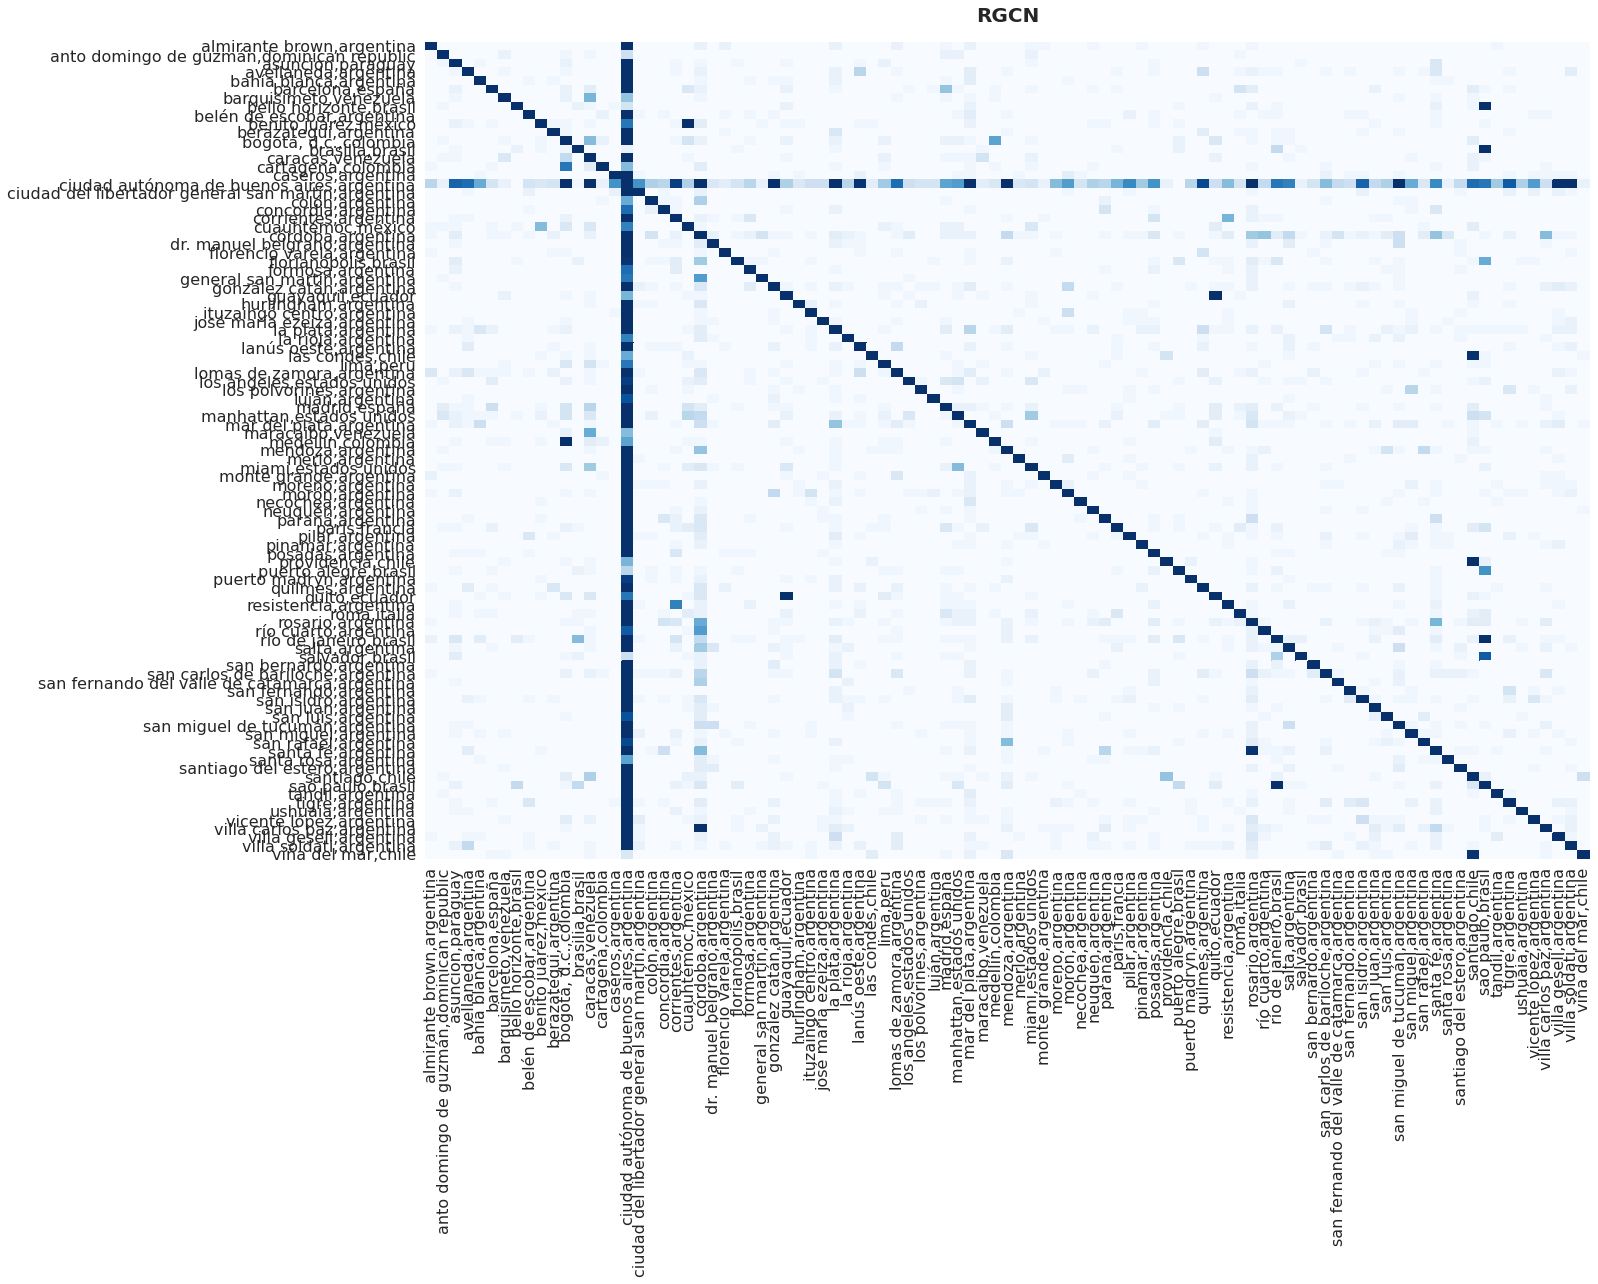

In [197]:
f, ax = plt.subplots(nrows=1, figsize=(25, 20))
i = 0
f.tight_layout(pad=30.0)

cm = confusion_matrix(cities_true, preds_, labels=np.unique(cities_true))

sns.heatmap(
    cm,
    #annot=True,
    #linewidths=.5,
    #fmt='d',
    robust=True,
    cmap='Blues',
    xticklabels=np.unique(cities_true),
    yticklabels=np.unique(cities_true),
    ax=ax,
    cbar=False
)
    
ax.set_title("RGCN", fontsize=20, fontweight='bold', pad=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.show()

# Graphsage

In [ ]:
with open(tmp_save + 'colfollows_graph.pickle', 'rb') as handle:
    colfollows_graph = pickle.load(handle)

with open(tmp_save + 'colmentions_graph_short.pickle', 'rb') as handle:
    colmentions_graph_short = pickle.load(handle)
    
with open(tmp_save + 'colmentions_graph.pickle', 'rb') as handle:
    colmentions_graph = pickle.load(handle)
    
with open(tmp_save + 'multilayer_graph.pickle', 'rb') as handle:
    multilayer_graph = pickle.load(handle)
    
with open(tmp_save + 'multilayer_mention_graph.pickle', 'rb') as handle:
    multilayer_mention_graph = pickle.load(handle)

In [174]:
def create_graphsage_model(optimizer, num_classes, generator):
    clear_session()
    
    graphsage_model = sg.layer.GraphSAGE(
        layer_sizes=[64],
        activations=["relu"],
        generator=generator,
        bias=True,
        dropout=0.2,
        aggregator=sg.layer.MeanAggregator,#sg.layer.AttentionalAggregator,
        normalize="l2",
        #kernel_regularizer=tf.keras.regularizers.l2(0.2)
    )
    
    x_inp, x_out = graphsage_model.in_out_tensors()
    
    x_out = Dense(units=num_classes, activation="softmax")(x_out)
    
    model = Model(inputs=x_inp, outputs=x_out)
    
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    return model

In [175]:
graphsage_generator = sg.mapper.GraphSAGENodeGenerator(colmentions_graph, 200000, [100], weighted=True)

def preprocess(fold):   
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
    
    X_train, y_train = graphsage_generator.flow(X_train.index.to_numpy(), y_train, shuffle=True)[0]
    X_val, y_val = graphsage_generator.flow(X_val.index.to_numpy(), y_val)[0]

    X_test = graphsage_generator.flow(X_test.index.to_numpy())

    clf = create_graphsage_model(
        Adam(learning_rate=3e-3),
        total_cities,
        graphsage_generator
    )
    
    clf.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=30, min_delta=0.0001, restore_best_weights=True)],
        epochs=50000,
        shuffle=False    
    )
    
    return clf, X_test   

graphsage_cross_val = GCNCrossValidator(
    name="Graphsage",
    encoder=LabelBinarizer()
)

graphsage_preds = graphsage_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(cities_true_enc, graphsage_preds, graphsage_cross_val.classes_order(), cities_with_coords, users_coords)

Epoch 1/50000
836/836 [==============================] - 2s 2ms/step - loss: 2.8898 - accuracy: 0.4153 - val_loss: 2.0536 - val_accuracy: 0.6050
Epoch 2/50000
836/836 [==============================] - 1s 2ms/step - loss: 1.9960 - accuracy: 0.6213 - val_loss: 1.6151 - val_accuracy: 0.7009
Epoch 3/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.7521 - accuracy: 0.6545 - val_loss: 1.4766 - val_accuracy: 0.7123
Epoch 4/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.6556 - accuracy: 0.6632 - val_loss: 1.4194 - val_accuracy: 0.7150
Epoch 5/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.6088 - accuracy: 0.6668 - val_loss: 1.3984 - val_accuracy: 0.7164
Epoch 6/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.5807 - accuracy: 0.6703 - val_loss: 1.3784 - val_accuracy: 0.7197
Epoch 7/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.5482 - accuracy: 0.6758 - val_loss: 1.3672 - val_ac

836/836 [==============================] - 2s 2ms/step - loss: 1.4694 - accuracy: 0.6769 - val_loss: 1.3343 - val_accuracy: 0.7275
Epoch 22/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.4549 - accuracy: 0.6780 - val_loss: 1.3328 - val_accuracy: 0.7301
Epoch 23/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.4587 - accuracy: 0.6776 - val_loss: 1.3337 - val_accuracy: 0.7268
Epoch 24/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.4616 - accuracy: 0.6782 - val_loss: 1.3330 - val_accuracy: 0.7275
Epoch 25/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.4496 - accuracy: 0.6816 - val_loss: 1.3374 - val_accuracy: 0.7278
Epoch 26/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.4536 - accuracy: 0.6785 - val_loss: 1.3273 - val_accuracy: 0.7271
Epoch 27/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.4375 - accuracy: 0.6809 - val_loss: 1.3345 - val_accuracy: 

836/836 [==============================] - 2s 2ms/step - loss: 1.3987 - accuracy: 0.6870 - val_loss: 1.3130 - val_accuracy: 0.7305
Epoch 47/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.4011 - accuracy: 0.6869 - val_loss: 1.3103 - val_accuracy: 0.7291
Epoch 48/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.3955 - accuracy: 0.6870 - val_loss: 1.3096 - val_accuracy: 0.7312
Epoch 49/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.3958 - accuracy: 0.6860 - val_loss: 1.3157 - val_accuracy: 0.7298
Epoch 50/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.3864 - accuracy: 0.6903 - val_loss: 1.3154 - val_accuracy: 0.7264
Epoch 51/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.3958 - accuracy: 0.6875 - val_loss: 1.3166 - val_accuracy: 0.7315
Epoch 52/50000
836/836 [==============================] - 2s 2ms/step - loss: 1.3853 - accuracy: 0.6904 - val_loss: 1.3126 - val_accuracy: 

In [176]:
print(count_score_city)

Accuracy: 0.7270769396435687        
Acc@161: 0.8231841921068217        
Balanced Acc: 0.6580762875333183        
ROC AUC Ovo: 0.9449703076128813        
Mean Dist Err: 369.0252996592966        
Median Dist Err: 3.868846211114615


In [137]:
class CustomGraphSageCrossValidator(GCNCrossValidator):
    def __init__(self, name, clf, nodes_ids, features, edges, encoder=None):
        self.nodes_ids = nodes_ids
        self.features = features
        self.edges = edges
        
        super().__init__(name, clf, encoder)
        
    def classifier(self):
        classifier = create_graphsage_model("adam", self.gcn_generator)
        
        return classifier
    
    def chi2(self, X, y, k=50):
        features_sel = np.array([])
        
        for target in np.unique(y):
            chi, p = chi2(X, y==target)
            
            idxs = np.argsort(chi)[-k:]
            
            features_sel = np.concatenate([features_sel, idxs])
            
            #Top words of this target is at self.vocab[idxs]
                
        return np.unique(features_sel)
        
    def apply_to_folds(self, fold, with_val, generators):
        custom_gen = []
        
        #nodes_ids = fold[0][0]
        features = fold[0][1]
        y_train = fold[1]
        
        fold[0] = [fold[0][0]]
        fold[2] = [fold[2][0]]
        
        if with_val:
            fold[4] = [fold[4][0]]
                         
        feats_selected = self.chi2(features, y_train, k=100)
        
        print("Using Total features: ", len(feats_selected))
                    
        node_feats = sg.IndexedArray(np.array(self.features[:, feats_selected].todense()), index=self.nodes_ids)
        
        graph = sg.StellarGraph(node_feats, self.edges)
        
        print(graph.info())
                        
        self.gcn_generator = sg.mapper.GraphSAGENodeGenerator(graph, 100, [64, 32])
        
        custom_gen.append(self.gcn_generator)
        
        return super().apply_to_folds(fold, with_val, custom_gen)

In [138]:
graphsage_cross_val = CustomGraphSageCrossValidator(
    name="GCN",
    clf=None,
    nodes_ids=users_ids,
    features=vector_of_words,
    edges=comentions_edges,
    encoder=LabelBinarizer()
)

graphsage_preds = graphsage_cross_val.cross_predict(
    #[np.arange(users_train_final.shape[0])],
    [users_ids, vector_of_words.astype(np.float32)],
    cities_true,
    val_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=200, min_delta=0.0001, restore_best_weights=True)],
    epochs=8000,
    #batch_size=64,
    shuffle=False,
)

Using Total features:  8814
StellarGraph: Undirected multigraph
 Nodes: 37146, Edges: 9048006

 Node types:
  default: [37146]
    Features: uint8 vector, length 8814
    Edge types: default-default->default

 Edge types:
    default-default->default: [9048006]
        Weights: range=[1, 253], mean=1.77775, std=4.04455
        Features: none


MemoryError: Unable to allocate 13.4 GiB for an array with shape (204800, 8814) and data type float64

# GAT

In [95]:
def create_gat_model(optimizer, generator):
    clear_session()
    
    gat_model = sg.layer.GAT(
        layer_sizes=[128, number_classes],
        activations=["elu", "softmax"],
        attn_heads=15,
        generator=generator,
        in_dropout=0.5,
        attn_dropout=0.5,
        normalize=None,
    )
    
    x_inp, predictions = gat_model.in_out_tensors()
    
    model = Model(inputs=x_inp, outputs=predictions)
    
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    return model

In [96]:
gat_generator = sg.mapper.FullBatchNodeGenerator(graph, method="gat")

gat_cross_val = GCNCrossValidator(
    name="GAT",
    clf=lambda: create_gat_model("adam", gat_generator),
    encoder=LabelEncoder()
)

gat_preds = gat_cross_val.cross_predict(
    [users_ids],
    classes_true,
    val_split=0.1,
    generators=[gat_generator],
    callbacks=[EarlyStopping(monitor='val_loss', patience=300, min_delta=0.0001, restore_best_weights=True)],
    epochs=2500,
    #batch_size=64,
    shuffle=False,
)

Epoch 1/2500
1/1 [==============================] - 12s 12s/step - loss: 4.6334 - accuracy: 0.0112 - val_loss: 4.5915 - val_accuracy: 0.0625
Epoch 2/2500
1/1 [==============================] - 5s 5s/step - loss: 4.6006 - accuracy: 0.0430 - val_loss: 4.5609 - val_accuracy: 0.1365
Epoch 3/2500
1/1 [==============================] - 5s 5s/step - loss: 4.5684 - accuracy: 0.0908 - val_loss: 4.5306 - val_accuracy: 0.1638
Epoch 4/2500
1/1 [==============================] - 5s 5s/step - loss: 4.5373 - accuracy: 0.1187 - val_loss: 4.5003 - val_accuracy: 0.1713
Epoch 5/2500
1/1 [==============================] - 5s 5s/step - loss: 4.5050 - accuracy: 0.1401 - val_loss: 4.4703 - val_accuracy: 0.1744
Epoch 6/2500
1/1 [==============================] - 5s 5s/step - loss: 4.4796 - accuracy: 0.1433 - val_loss: 4.4403 - val_accuracy: 0.1793
Epoch 7/2500
1/1 [==============================] - 5s 5s/step - loss: 4.4508 - accuracy: 0.1433 - val_loss: 4.4104 - val_accuracy: 0.1807
Epoch 8/2500
1/1 [=======

1/1 [==============================] - 5s 5s/step - loss: 3.3715 - accuracy: 0.2662 - val_loss: 3.4791 - val_accuracy: 0.2937
Epoch 118/2500
1/1 [==============================] - 5s 5s/step - loss: 3.3656 - accuracy: 0.2685 - val_loss: 3.4790 - val_accuracy: 0.2926
Epoch 119/2500
1/1 [==============================] - 5s 5s/step - loss: 3.3516 - accuracy: 0.2729 - val_loss: 3.4788 - val_accuracy: 0.2946
Epoch 120/2500
1/1 [==============================] - 5s 5s/step - loss: 3.3584 - accuracy: 0.2678 - val_loss: 3.4785 - val_accuracy: 0.2952
Epoch 121/2500
1/1 [==============================] - 5s 5s/step - loss: 3.3515 - accuracy: 0.2700 - val_loss: 3.4776 - val_accuracy: 0.2949
Epoch 122/2500
1/1 [==============================] - 5s 5s/step - loss: 3.3586 - accuracy: 0.2697 - val_loss: 3.4765 - val_accuracy: 0.2926
Epoch 123/2500
1/1 [==============================] - 5s 5s/step - loss: 3.3441 - accuracy: 0.2712 - val_loss: 3.4764 - val_accuracy: 0.2915
Epoch 124/2500
1/1 [========

1/1 [==============================] - 5s 5s/step - loss: 3.2647 - accuracy: 0.2769 - val_loss: 3.4904 - val_accuracy: 0.2900
Epoch 234/2500
1/1 [==============================] - 5s 5s/step - loss: 3.2535 - accuracy: 0.2776 - val_loss: 3.4904 - val_accuracy: 0.2892
Epoch 235/2500
1/1 [==============================] - 5s 5s/step - loss: 3.2586 - accuracy: 0.2723 - val_loss: 3.4901 - val_accuracy: 0.2909
Epoch 236/2500
1/1 [==============================] - 5s 5s/step - loss: 3.2570 - accuracy: 0.2775 - val_loss: 3.4903 - val_accuracy: 0.2920
Epoch 237/2500
1/1 [==============================] - 5s 5s/step - loss: 3.2464 - accuracy: 0.2776 - val_loss: 3.4910 - val_accuracy: 0.2909
Epoch 238/2500
1/1 [==============================] - 5s 5s/step - loss: 3.2572 - accuracy: 0.2739 - val_loss: 3.4914 - val_accuracy: 0.2923
Epoch 239/2500
1/1 [==============================] - 5s 5s/step - loss: 3.2662 - accuracy: 0.2750 - val_loss: 3.4908 - val_accuracy: 0.2926
Epoch 240/2500
1/1 [========

1/1 [==============================] - 5s 5s/step - loss: 3.2260 - accuracy: 0.2767 - val_loss: 3.4924 - val_accuracy: 0.2923
Epoch 350/2500
1/1 [==============================] - 5s 5s/step - loss: 3.2132 - accuracy: 0.2805 - val_loss: 3.4927 - val_accuracy: 0.2929
Epoch 351/2500
1/1 [==============================] - 5s 5s/step - loss: 3.2269 - accuracy: 0.2756 - val_loss: 3.4926 - val_accuracy: 0.2946
Epoch 352/2500
1/1 [==============================] - 5s 5s/step - loss: 3.2090 - accuracy: 0.2825 - val_loss: 3.4910 - val_accuracy: 0.2940
Epoch 353/2500
1/1 [==============================] - 5s 5s/step - loss: 3.2098 - accuracy: 0.2771 - val_loss: 3.4904 - val_accuracy: 0.2932
Epoch 354/2500
1/1 [==============================] - 5s 5s/step - loss: 3.2119 - accuracy: 0.2820 - val_loss: 3.4906 - val_accuracy: 0.2912
Epoch 355/2500
1/1 [==============================] - 5s 5s/step - loss: 3.2062 - accuracy: 0.2763 - val_loss: 3.4903 - val_accuracy: 0.2912
Epoch 356/2500
1/1 [========

1/1 [==============================] - 5s 5s/step - loss: 3.9115 - accuracy: 0.2026 - val_loss: 3.8020 - val_accuracy: 0.2567
Epoch 34/2500
1/1 [==============================] - 5s 5s/step - loss: 3.8829 - accuracy: 0.2097 - val_loss: 3.7868 - val_accuracy: 0.2570
Epoch 35/2500
1/1 [==============================] - 5s 5s/step - loss: 3.8734 - accuracy: 0.2080 - val_loss: 3.7715 - val_accuracy: 0.2608
Epoch 36/2500
1/1 [==============================] - 5s 5s/step - loss: 3.8466 - accuracy: 0.2151 - val_loss: 3.7562 - val_accuracy: 0.2656
Epoch 37/2500
1/1 [==============================] - 5s 5s/step - loss: 3.8383 - accuracy: 0.2158 - val_loss: 3.7407 - val_accuracy: 0.2671
Epoch 38/2500
1/1 [==============================] - 5s 5s/step - loss: 3.8244 - accuracy: 0.2235 - val_loss: 3.7254 - val_accuracy: 0.2708
Epoch 39/2500
1/1 [==============================] - 5s 5s/step - loss: 3.8008 - accuracy: 0.2206 - val_loss: 3.7104 - val_accuracy: 0.2737
Epoch 40/2500
1/1 [===============

KeyboardInterrupt: 

# Old

In [204]:
accuracy_score(classes_true, np.array([graphsage_cross_val.classes_order()[x] for x in np.argmax(graphsage_preds, axis=1)]))

0.14462781463033947

In [205]:
accuracy_161km(classes_true, np.array([graphsage_cross_val.classes_order()[x] for x in np.argmax(graphsage_preds, axis=1)]))

0.4416875157802924

In [ ]:
neural_cross_val = CrossValidator(
    name="Neural BiLSTM",
    clf=KerasClassifier(
        build_fn=create_complete_model,
        verbose=2,
        callbacks=EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001),
        optimizer="adam",
        epochs=1,
        batch_size=64,
        input_nlp_length=input_nlp.shape[1],
        input_mentions_length=word2vec.wv.vectors.shape[1]
    ),
    encoder=LabelEncoder()
)

neural_preds_X = neural_cross_val.cross_predict(
    [input_nlp, word2vec.wv.vectors],
    classes_true,
    val_split=0.05,
    predict_proba=False
)

# Entrenamiento

In [79]:
vectorizers_mentions = []
vectors_of_clusters_mentions = []

for i in range(total_clusters_mentions):
    v = CountVectorizer(
        strip_accents=None,
        lowercase=False,
        #vocabulary=all_clusters,
        analyzer=lambda x: x
    )
    
    vectors_of_clusters_mentions.append(
        v.fit_transform(users_train_final["clusters_mentions_" + str(i)]).astype(np.float32)
    )
    
    vectorizers_mentions.append(v)

In [80]:
vectors_of_clusters_mentions

[<43567x3644 sparse matrix of type '<class 'numpy.float32'>'
 	with 48747 stored elements in Compressed Sparse Row format>]

In [81]:
vectorizers_follows = []
vectors_of_clusters_follows = []

for i in range(total_clusters_follows):
    v = CountVectorizer(
        strip_accents=None,
        lowercase=False,
        #vocabulary=all_clusters,
        analyzer=lambda x: x
    )
    
    vectors_of_clusters_follows.append(
        v.fit_transform(users_train_final["clusters_followers_" + str(i)]).astype(np.float32)
    )
    
    vectorizers_follows.append(v)

In [163]:
vectors_of_clusters_follows

[<43567x556 sparse matrix of type '<class 'numpy.float32'>'
 	with 27080 stored elements in Compressed Sparse Row format>,
 <43567x94 sparse matrix of type '<class 'numpy.float32'>'
 	with 26468 stored elements in Compressed Sparse Row format>,
 <43567x17 sparse matrix of type '<class 'numpy.float32'>'
 	with 25519 stored elements in Compressed Sparse Row format>,
 <43567x4 sparse matrix of type '<class 'numpy.float32'>'
 	with 25288 stored elements in Compressed Sparse Row format>]

In [164]:
all_clusters_mentions = None

for clusters in vectors_of_clusters_mentions:
    all_clusters_mentions = hstack([all_clusters_mentions, clusters])

all_clusters_follows = None

for clusters in vectors_of_clusters_follows:
    all_clusters_follows = hstack([all_clusters_follows, clusters])    
    
all_clusters_mentions

<43567x696 sparse matrix of type '<class 'numpy.float32'>'
	with 183746 stored elements in COOrdinate format>

In [165]:
all_clusters_mentions = all_clusters_mentions.tocsr()
all_clusters_follows = all_clusters_follows.tocsr()

In [431]:
neural_cross_val = CrossValidator(
    name="Neural LSTM",
    clf=KerasClassifier(
        build_fn=create_complete_model,
        verbose=2,
        callbacks=EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001),
        optimizer="adam",
        epochs=30,
        batch_size=64,
        input_nlp_length=input_nlp.shape[1],
        input_mentions_length=fake_array.shape[1],
        weights_mentions=pretrained_weights
       # input_follows_length=all_clusters_follows.shape[1]
    ),
    encoder=LabelEncoder()
)

neural_preds_X = neural_cross_val.cross_predict(
    [input_nlp, fake_array],
    classes_true,
    val_split=0.05,
    predict_proba=False
)

Epoch 1/30
518/518 - 193s - loss: 4.2081 - accuracy: 0.0841 - val_loss: 3.8041 - val_accuracy: 0.1417
Epoch 2/30
518/518 - 186s - loss: 3.5092 - accuracy: 0.1919 - val_loss: 3.3593 - val_accuracy: 0.2243
Epoch 3/30
518/518 - 186s - loss: 2.9886 - accuracy: 0.2855 - val_loss: 3.1043 - val_accuracy: 0.2926
Epoch 4/30
518/518 - 185s - loss: 2.6634 - accuracy: 0.3532 - val_loss: 2.9722 - val_accuracy: 0.3270
Epoch 5/30
518/518 - 186s - loss: 2.3930 - accuracy: 0.4098 - val_loss: 2.9079 - val_accuracy: 0.3517
Epoch 6/30
518/518 - 186s - loss: 2.1872 - accuracy: 0.4514 - val_loss: 2.8582 - val_accuracy: 0.3649
Epoch 7/30
518/518 - 186s - loss: 2.0769 - accuracy: 0.4754 - val_loss: 2.8722 - val_accuracy: 0.3523
Epoch 8/30
518/518 - 186s - loss: 1.8872 - accuracy: 0.5166 - val_loss: 2.8865 - val_accuracy: 0.3678
Epoch 9/30
518/518 - 186s - loss: 1.7600 - accuracy: 0.5464 - val_loss: 2.9256 - val_accuracy: 0.3735
Epoch 10/30
518/518 - 185s - loss: 1.6451 - accuracy: 0.5710 - val_loss: 2.9792 - 

KeyboardInterrupt: 

In [89]:
accuracy_score(classes_true, neural_preds)

0.4438451121261505

In [90]:
accuracy_161km(classes_true, neural_preds)

0.6918539261367549

Separate models

In [ ]:
content_cross_val = CrossValidator(
    name="Content LSTM",
    clf=KerasClassifier(
        build_fn=create_nlp_model,
        verbose=2,
        input_length=input_nlp.shape[1],
        optimizer="adam",
        callbacks=EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, restore_best_weights=True),
        epochs=128,
        batch_size=64  
    ),
    encoder=LabelEncoder()
)

content_preds = content_cross_val.cross_predict(
    [input_nlp],
    classes_true,
    val_split=0.2
)

Epoch 1/128
436/436 - 122s - loss: 4.2637 - accuracy: 0.0784 - val_loss: 3.8298 - val_accuracy: 0.1297
Epoch 2/128
436/436 - 118s - loss: 3.5019 - accuracy: 0.1900 - val_loss: 3.3477 - val_accuracy: 0.2199
Epoch 3/128
436/436 - 118s - loss: 2.9506 - accuracy: 0.2808 - val_loss: 3.2144 - val_accuracy: 0.2661
Epoch 4/128


In [320]:
#with open('../../tmp_paper/content_preds.pickle', 'wb') as handle:
#    pickle.dump(content_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [78]:
#with open('../../tmp_paper/content_preds.pickle', 'rb') as handle:
#    content_preds = pickle.load(handle)

In [145]:
accuracy_score(classes_true, np.array([content_cross_val.classes_order()[x] for x in np.argmax(content_preds, axis=1)]))

0.3410149884086579

In [146]:
accuracy_161km(classes_true, np.array([content_cross_val.classes_order()[x] for x in np.argmax(content_preds, axis=1)]))

0.589505818624188

In [82]:
    mentions_cross_val = CrossValidator(
        name="Mentions Naive Bayes #" + str(i),
        clf=GridSearchCV(
            estimator=MultinomialNB(),
            param_grid={"alpha": [0.1, 0.5, 1.0, 2.0]},
            cv=3,
            n_jobs=-1,
            scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
            refit='roc_auc_ovo_weighted',
            verbose=3
        )
    )

    mentions_preds = mentions_cross_val.cross_score(
    [vectors_of_clusters_mentions[0]],
    classes_true,
    scoring={
        'accuracy': 'accuracy',
        'balanced_accuracy': 'balanced_accuracy',
        'roc_auc_ovo_weighted': 'roc_auc_ovo_weighted',
        'accuracy@161': make_scorer(accuracy_161km, greater_is_better=True)            
    }
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


In [83]:
mentions_preds #Resultado con menciones dirigidas

{'fit_time': array([84.74593139, 86.29568291, 86.18918419, 86.72739148, 86.18252969]),
 'score_time': array([5.51942801, 5.6650176 , 6.596668  , 6.41266012, 5.80591774]),
 'test_accuracy': array([0.1663989 , 0.17213679, 0.20153793, 0.2024561 , 0.15092391]),
 'test_balanced_accuracy': array([0.14416924, 0.14349766, 0.17711566, 0.18622678, 0.12349433]),
 'test_roc_auc_ovo_weighted': array([0.71873456, 0.72869687, 0.72913581, 0.7205245 , 0.69160615]),
 'test_accuracy@161': array([0.48955703, 0.51021345, 0.52461839, 0.50820613, 0.4960404 ])}

In [58]:
mentions_preds #Resultado con menciones no dirigidas

{'fit_time': array([85.66773534, 86.01443768, 87.22573876, 87.42889953, 86.09338379]),
 'score_time': array([5.95741391, 6.66771531, 6.08000493, 5.62024689, 5.12601924]),
 'test_accuracy': array([0.17798944, 0.19956392, 0.21485137, 0.20693217, 0.17181223]),
 'test_balanced_accuracy': array([0.1625316 , 0.18487193, 0.20055768, 0.19368557, 0.15755188]),
 'test_roc_auc_ovo_weighted': array([0.73027779, 0.73934633, 0.74204274, 0.73191581, 0.70715056]),
 'test_accuracy@161': array([0.49954097, 0.5095249 , 0.53265236, 0.51612533, 0.47893952])}

In [191]:
mentions_preds #Resultado con comenciones

{'fit_time': array([81.30275917, 82.02766347, 84.27038074, 83.79635406, 81.89668918]),
 'score_time': array([6.56125307, 6.44094682, 4.62715268, 4.8839736 , 5.86592555]),
 'test_accuracy': array([0.19176039, 0.2211384 , 0.2286239 , 0.22839435, 0.19866866]),
 'test_balanced_accuracy': array([0.17065298, 0.20407987, 0.20931871, 0.20964372, 0.18025622]),
 'test_roc_auc_ovo_weighted': array([0.77293233, 0.77523306, 0.78109158, 0.76985327, 0.75103605]),
 'test_accuracy@161': array([0.53236172, 0.54211613, 0.57660966, 0.54194881, 0.51796167])}

In [167]:
mentions_preds #Resultado con menciones colapsadas

{'fit_time': array([83.45256758, 81.3967638 , 81.91035676, 81.84780574, 83.62461948]),
 'score_time': array([5.45714545, 4.87386847, 5.79235339, 4.63058734, 5.38084507]),
 'test_accuracy': array([0.19921965, 0.23295846, 0.24515092, 0.2436589 , 0.20624354]),
 'test_balanced_accuracy': array([0.18000999, 0.2141232 , 0.22619962, 0.2251826 , 0.18871887]),
 'test_roc_auc_ovo_weighted': array([0.77592934, 0.78025374, 0.78830594, 0.77332938, 0.75573171]),
 'test_accuracy@161': array([0.53798485, 0.55542805, 0.58257776, 0.55790199, 0.52978308])}

In [613]:
mentions_all_preds = []
mentions_cross_validators = []

i = 0

for clusters in vectors_of_clusters_mentions:
    mentions_cross_val = CrossValidator(
        name="Mentions Naive Bayes #" + str(i),
        clf=GridSearchCV(
            estimator=MultinomialNB(),
            param_grid={"alpha": [0.1, 0.5, 1.0, 2.0]},
            cv=3,
            n_jobs=-1,
            scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
            refit='roc_auc_ovo_weighted',
            verbose=3
        )
    )

    mentions_preds = mentions_cross_val.cross_predict(
        [clusters],
        classes_true 
    )
    
    mentions_all_preds.append(mentions_preds)
    mentions_cross_validators.append(mentions_cross_val)
    
    i += 1

follows_all_preds = []    
follows_cross_validators = []

i = 0

for clusters in vectors_of_clusters_follows:    
    followers_cross_val = CrossValidator(
        name="Followers Naive Bayes #" + str(i),
        clf=GridSearchCV(
            estimator=MultinomialNB(),
            param_grid={"alpha": [0.1, 0.5, 1.0, 2.0]},
            cv=3,
            n_jobs=-1,
            scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
            refit='roc_auc_ovo_weighted',
            verbose=3
        )
    )

    follows_preds = followers_cross_val.cross_predict(
        [clusters],
        classes_true 
    )
    
    follows_all_preds.append(follows_preds)
    follows_cross_validators.append(followers_cross_val)
    
    i += 1

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates

In [616]:
total_preds = content_preds

for follows_preds in follows_all_preds:
    total_preds = np.concatenate((total_preds, follows_preds), axis=1)

for mentions_preds in mentions_all_preds:
    total_preds = np.concatenate((total_preds, mentions_preds), axis=1)

In [617]:
meta_cross_val = CrossValidator(
    name="Meta classifier",
    clf=GridSearchCV(
        estimator=LogisticRegression(class_weight="balanced",random_state=35,n_jobs=-1),
        param_grid={'C': [0.5, 1.0], 'class_weight': ['balanced']},
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
)

meta_preds = meta_cross_val.cross_predict(
    [total_preds],
    classes_true,
    predict_proba=False
)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [144]:
meta_cross_val.cross_score(
    [total_preds],
    classes_true,
    scoring={
        'accuracy': 'accuracy',
        'balanced_accuracy': 'balanced_accuracy',
        'roc_auc_ovo_weighted': 'roc_auc_ovo_weighted',
        'accuracy@161': make_scorer(accuracy_161km, greater_is_better=True)            
    }
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.9min remaining:  7.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


{'fit_time': array([306.15769434, 287.3593688 , 291.24560165, 304.40464735,
        290.99488521]),
 'score_time': array([4.22527814, 5.39945412, 4.80088735, 4.2956202 , 4.58473682]),
 'test_accuracy': array([0.35815928, 0.40716089, 0.41386434, 0.44198324, 0.38023643]),
 'test_balanced_accuracy': array([0.34481759, 0.39919832, 0.41679426, 0.44079747, 0.37335784]),
 'test_roc_auc_ovo_weighted': array([0.91234781, 0.92848396, 0.93048155, 0.92975553, 0.91237872]),
 'test_accuracy@161': array([0.66352995, 0.69302272, 0.710777  , 0.71043269, 0.67427981])}

In [142]:
accuracy_score(meta_preds, classes_true)

0.4122615741272064

In [143]:
accuracy_161km(meta_preds, classes_true)

0.6972938233066311

73% acc@161 con keras con meta clasificador

In [84]:
leaves_df = gpd.GeoDataFrame(leaves)
leaves_df.head()

,x_min,x_max,y_min,y_max,points,x_med_points,y_med_points,x_cent_points,y_cent_points,class
0,-64.189462,-64.178549,-31.487109,-31.334949,1154,-64.183300,-31.400000,-64.183770,-31.405112,0
1,-58.521712,-58.415098,-34.615872,-34.606259,1219,-58.439700,-34.608900,-58.441674,-34.609278,1
2,-58.415091,-58.373400,-34.615810,-34.606275,1218,-58.373400,-34.608600,-58.378626,-34.609021,2
3,-58.666085,-58.525221,-34.924792,-34.652453,548,-58.564309,-34.683600,-58.581942,-34.709198,3
4,-71.578315,-70.650278,-33.477783,-32.931045,663,-70.666700,-33.443029,-70.826561,-33.364081,4


In [85]:
def create_regions(row):
    return box(row["x_min"], row["y_min"], row["x_max"], row["y_max"])

def create_mid_point(row):
    return Point(row["x_med_points"], row["y_med_points"])

leaves_df["region"] = leaves_df.apply(create_regions, axis=1)
leaves_df["mid_point"] = leaves_df.apply(create_mid_point, axis=1)

In [86]:
region_df = gpd.GeoDataFrame(leaves_df, geometry='region')
med_df = gpd.GeoDataFrame(leaves_df, geometry='mid_point')

In [87]:
def create_points(row):
    return Point(row["longitude"], row["latitude"])

points = users_train_final[["latitude", "longitude"]].apply(create_points, axis=1)
points_df = gpd.GeoDataFrame({"points": points}, geometry='points')

In [103]:
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)

south = world.query('continent == "South America"')

In [123]:
arg = gpd.read_file(unTPath + 'shapefiles/departamento.shp')
prov_arg = gpd.read_file(unTPath + 'shapefiles/provincia.shp')

In [99]:
gpd.datasets.available

['naturalearth_lowres', 'naturalearth_cities', 'nybb']

In [89]:
cmap = plt.cm.gist_rainbow
cmaplist = [cmap(i) for i in range(cmap.N)]
targets = np.unique(users_train_final["unified_place"].to_numpy())
colors = {}

i = 0

for target in targets:
    colors[target] = cmaplist[i]
    i += 2

In [90]:
latitudes = users_train_final["latitude"].to_numpy()
longitudes = users_train_final["longitude"].to_numpy()

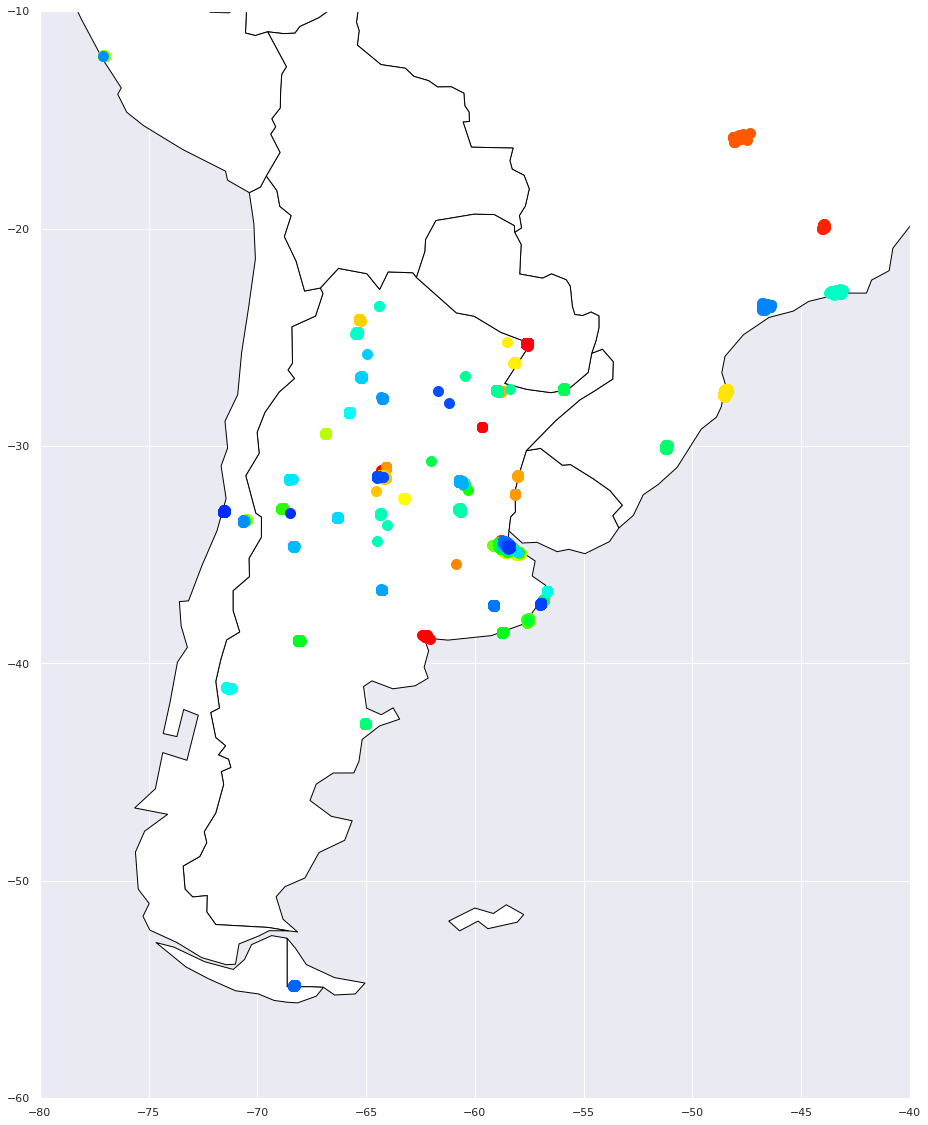

In [121]:
fig, ax = plt.subplots(figsize=(25, 20))

world.plot(ax=ax, color='white', edgecolor='black')
for target in targets:
    ix = np.where(users_train_final["unified_place"].to_numpy() == target)
    ax.scatter(longitudes[ix], latitudes[ix], color=colors[target], label=target, s=100)
    
ax.set_xlim(-80, -40)
ax.set_ylim(-60, -10)

#ax.legend()
plt.show()

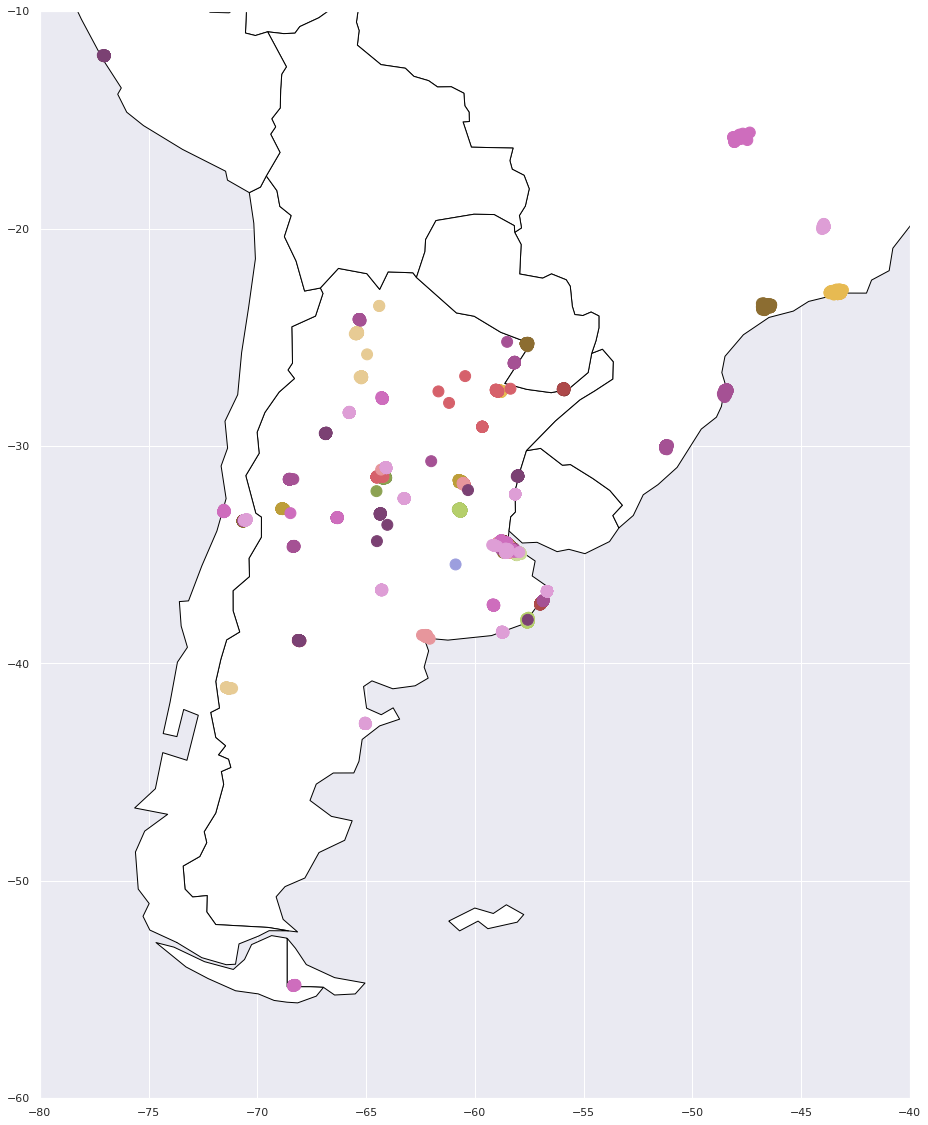

In [122]:
fig, ax = plt.subplots(figsize=(25, 20))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')

points_df.plot(ax=ax, marker='o', markersize=120, cmap="tab20b", alpha=1.0)

ax.set_xlim(-80, -40)
ax.set_ylim(-60, -10)

plt.show();

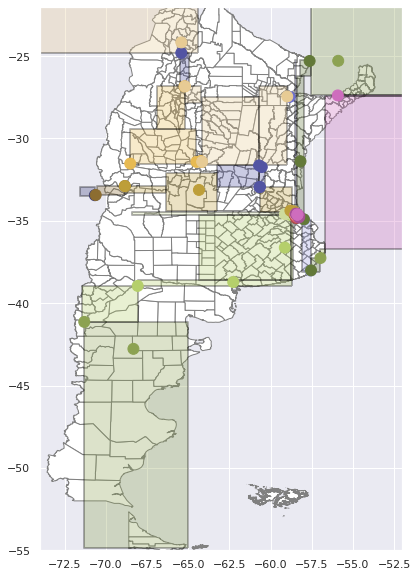

In [126]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_aspect('equal')

arg.plot(ax=ax, color='white', edgecolor='gray')

region_df.plot(ax=ax, cmap="tab20b", alpha=0.3, linewidth=2, linestyle='-', edgecolor="black")
med_df.plot(ax=ax, marker='o', markersize=120, cmap="tab20b", alpha=1.0)

#ax.set_xlim(-80, -40)
#ax.set_ylim(-60, -10)

ax.set_xlim(-74, -52)
ax.set_ylim(-55, -22)

plt.show();

fig.savefig(figuresPath + 'kdtrees/kdtree_255_twitter_exact_paper.pdf', bbox_inches = 'tight')


# Guardado para ejecución en otro ambiente

In [681]:
fold_id = 0

for fold in folds_cities:
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)

    y_train = encoder_city.transform(y_train)
    y_val = encoder_city.transform(y_val)
    y_test = encoder_city.transform(y_test)
    
    train_tweets = X_train["all_tweets"].to_numpy()
    val_tweets = X_val["all_tweets"].to_numpy()
    test_tweets = X_test["all_tweets"].to_numpy()
    
    train_idxs = X_train.index.to_numpy()
    val_idxs = X_val.index.to_numpy()
    test_idxs = X_test.index.to_numpy()
    
    max_features = 50000
    sequence_length = 256
    
    tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(train_tweets)
    
    X_train_nlp = tokenizer.texts_to_sequences(train_tweets)
    X_train_nlp = pad_sequences(X_train_nlp, maxlen=sequence_length, truncating='post', padding='pre')
    
    X_val_nlp = tokenizer.texts_to_sequences(val_tweets)
    X_val_nlp = pad_sequences(X_val_nlp, maxlen=sequence_length, truncating='post', padding='pre')
    
    X_test_nlp = tokenizer.texts_to_sequences(test_tweets)
    X_test_nlp = pad_sequences(X_test_nlp, maxlen=sequence_length, truncating='post', padding='pre')    
    
    X_train = [X_train_nlp, train_idxs, train_idxs]
    X_val = [X_val_nlp, val_idxs, val_idxs]
    X_test = [X_test_nlp, test_idxs, test_idxs]
    
    with open(tmp_save + 'X_train_fold_' + str(fold_id) + '.pickle', 'wb') as handle:
        pickle.dump(X_train, handle, protocol=4)  
        
    with open(tmp_save + 'X_val_fold_' + str(fold_id) + '.pickle', 'wb') as handle:
        pickle.dump(X_val, handle, protocol=4) 
        
    with open(tmp_save + 'X_test_fold_' + str(fold_id) + '.pickle', 'wb') as handle:
        pickle.dump(X_test, handle, protocol=4) 
        
    with open(tmp_save + 'y_train_fold_' + str(fold_id) + '.pickle', 'wb') as handle:
        pickle.dump(y_train, handle, protocol=4)  
        
    with open(tmp_save + 'y_val_fold_' + str(fold_id) + '.pickle', 'wb') as handle:
        pickle.dump(y_val, handle, protocol=4) 
        
    with open(tmp_save + 'y_test_fold_' + str(fold_id) + '.pickle', 'wb') as handle:
        pickle.dump(y_test, handle, protocol=4) 
        
    fold_id += 1

In [682]:
#with open(tmp_save + 'node2vec_pec_embs_folds.pickle', 'wb') as handle:
#    pickle.dump(node2vec_pec_embs, handle, protocol=4)

In [683]:
#with open(tmp_save + 'node2vec_fol_pec_embs_folds.pickle', 'wb') as handle:
#    pickle.dump(node2vec_fol_pec_embs, handle, protocol=4)

In [109]:
#with open(tmp_save + 'embeddings_word2vec_folds.pickle', 'wb') as handle:
#    pickle.dump(embeddings, handle, protocol=4)

# Explicabilidad

In [83]:
import shap
shap.initjs()

In [184]:
X_train, y_train, X_test, y_test = folds_cities[0].unpack()

In [270]:
with open(tmp_save + 'tmp_1_ex.pickle', 'wb') as handle:
    pickle.dump(X_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(tmp_save + 'tmp_2_ex.pickle', 'wb') as handle:
    pickle.dump(y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(tmp_save + 'tmp_3_ex.pickle', 'wb') as handle:
    pickle.dump(X_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(tmp_save + 'tmp_4_ex.pickle', 'wb') as handle:
    pickle.dump(y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)    

In [87]:
with open(tmp_save + 'tmp_1_ex.pickle', 'rb') as handle:
    X_train = pickle.load(handle)
    
with open(tmp_save + 'tmp_2_ex.pickle', 'rb') as handle:
    y_train = pickle.load(handle)
    
with open(tmp_save + 'tmp_3_ex.pickle', 'rb') as handle:
    X_test = pickle.load(handle)
    
with open(tmp_save + 'tmp_4_ex.pickle', 'rb') as handle:
    y_test = pickle.load(handle)

In [88]:
y_train_enc = encoder_city.transform(y_train)
y_test_enc = encoder_city.transform(y_test)

In [495]:
vectorizer = CountVectorizer(
    #strip_accents='unicode',
    strip_accents='ascii',
    lowercase=True,
    max_df=0.2,
    min_df=10,
    ngram_range=(1, 3)
)
        
X_train_tweets = vectorizer.fit_transform(X_train["all_tweets"].to_numpy()).astype(np.uint8)
        
X_test_tweets = vectorizer.transform(X_test["all_tweets"].to_numpy()).astype(np.uint8)
    
estimator = Pipeline(
    [
        ("chi2", ChiSelector(np.array(vectorizer.get_feature_names()), k=50)),
        ("naive_bayes", LogisticRegression(n_jobs=-1))
    ]
)

content_clf = estimator

'''content_clf = GridSearchCV(
    estimator=estimator,
    param_grid={
        "naive_bayes__alpha": [0.5],
        "chi2__k": [50]
    },
    cv=3,
    n_jobs=-1,
    scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
    refit='roc_auc_ovo_weighted',
    verbose=3
)'''
    
content_clf.fit(X_train_tweets, y_train)

cont_preds = content_clf.predict_proba(X_test_tweets)

In [497]:
print(get_all_metrics(y_test_enc, cont_preds, content_clf.classes_, cities_with_coords, users_coords[X_test.index]))

Accuracy: 0.6639300134589502        
Acc@161: 0.7699865410497981        
Balanced Acc: 0.6031862181466354        
ROC AUC Ovo: 0.9155949684941548        
Mean Dist Err: 532.3259710843771        
Median Dist Err: 4.854669287837341


In [468]:
X_train_tweets_tf = content_clf.named_steps["chi2"].transform(X_train_tweets)
X_test_tweets_tf = content_clf.named_steps["chi2"].transform(X_test_tweets)

In [469]:
X_train_tweets_tf

<29716x4493 sparse matrix of type '<class 'numpy.uint8'>'
	with 468107 stored elements in Compressed Sparse Row format>

In [470]:
feats_sel = [int(x) for x in content_clf.named_steps["chi2"].features_selected]

In [471]:
feat_names = np.array(vectorizer.get_feature_names())[feats_sel]

In [301]:
np.where(feat_names == "en cordoba capitallllll")

(array([1476]),)

In [302]:
explainer = shap.TreeExplainer(
    content_clf.named_steps["naive_bayes"]
    #X_train_tweets_tf,
    #feature_names=feat_names,
    #feature_perturbation="interventional"
)

In [474]:
explainer = shap.LinearExplainer(
    content_clf.named_steps["naive_bayes"],
    X_train_tweets_tf,
    feature_names=feat_names,
    feature_perturbation="interventional"
)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [119]:
#explainer = shap.Explainer(
#    content_clf.best_estimator_.named_steps["naive_bayes"],
#    X_train_tweets_tf,
#    feature_names=feat_names
#)

#shap_values = explainer(X_test)

Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
Attribute intercept_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).


In [476]:
shap_values = explainer.shap_values(X_test_tweets_tf)

In [285]:
len(shap_values)

95

In [477]:
X_test_tweets_tf_array = X_test_tweets_tf.toarray()

In [498]:
index_city = np.where(content_clf.classes_ == "rosario,argentina")[0][0]

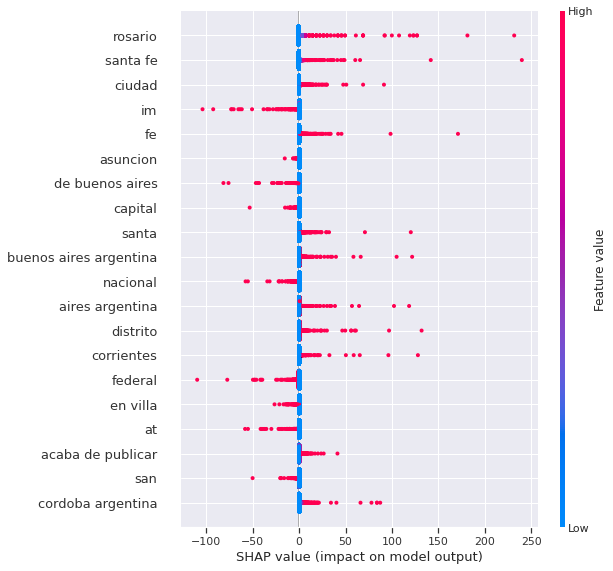

In [499]:
shap.summary_plot(shap_values[index_city], X_test_tweets_tf_array, feature_names=feat_names)

In [123]:
explainer = shap.LinearExplainer(
    content_clf.best_estimator_.named_steps["naive_bayes"],
    X_train_tweets_tf,
    feature_dependence="independent"
)
#shap_values = explainer.shap_values(X_test_tweets_tf)

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
Attribute intercept_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).


In [136]:
city = 'san bernardo,argentina'
X_test_tweets_tf_city = X_test_tweets_tf[y_test == city] 

In [137]:
shap_values = explainer.shap_values(X_test_tweets_tf_city)

In [138]:
X_test_tweets_tf_array = X_test_tweets_tf_city.toarray() # we need to pass a dense version for the plotting functions

Ego nets

In [90]:
X_train_node2vec = node2vec_pec_embs[X_train.index.to_numpy()]
X_test_node2vec = node2vec_pec_embs[X_test.index.to_numpy()]
    
mentions_clf=GridSearchCV(
    estimator=LogisticRegression(random_state=35, n_jobs=-1),
    param_grid={'C': [0.05, 0.1, 0.5, 1.0]},
    cv=3,
    n_jobs=-1,
    scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
    refit='roc_auc_ovo_weighted',
    verbose=3
)
    
mentions_clf.fit(X_train_node2vec, y_train)
    
ment_preds = mentions_clf.predict_proba(X_test_node2vec)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [91]:
print(get_all_metrics(y_test_enc, ment_preds, mentions_clf.classes_, cities_with_coords, users_coords[X_test.index]))

Accuracy: 0.4574697173620458        
Acc@161: 0.6563930013458951        
Balanced Acc: 0.25010809918170385        
ROC AUC Ovo: 0.8425289037622423        
Mean Dist Err: 722.6494219477671        
Median Dist Err: 14.040268059229316


In [92]:
ment_ex_train = mentions_clf.predict(X_train_node2vec)

In [93]:
ment_ex_preds = mentions_clf.predict(X_test_node2vec)

In [94]:
ment_total_preds = np.concatenate((ment_ex_train, ment_ex_preds))

In [95]:
all_idxs = np.concatenate((X_train.index.to_numpy(), X_test.index.to_numpy()))
all_idxs = all_idxs.argsort()

ment_total_preds = ment_total_preds[all_idxs]

In [96]:
col_net = nx.convert_matrix.from_scipy_sparse_matrix(vector_of_col_mentions)

In [186]:
#node_pos = 10
node_pos = 15
#node_pos = 3000
print(ment_ex_preds[node_pos], "|||", y_test[node_pos])

ciudad autónoma de buenos aires,argentina ||| ciudad autónoma de buenos aires,argentina


In [187]:
# Node 1 is beauty to plot
node_id = np.where(users_ids == X_test["id"].to_numpy()[node_pos])[0][0]

In [188]:
ego_net = nx.ego_graph(col_net, node_id, radius=1, distance='weight')

In [189]:
city_with_order = np.concatenate((y_train, y_test))
cities_nodes = [cities_true[node] for node in ego_net]
cities_log_nodes = [ment_total_preds[node] for node in ego_net]

cities_graph = np.unique(cities_nodes)
cities_log = np.unique(cities_log_nodes)
cities_used = np.unique(np.concatenate((cities_nodes, cities_log_nodes)))

In [190]:
#pos = nx.drawing.nx_agraph.graphviz_layout(ego_net, prog='neato')
#pos = nx.spring_layout(ego_net, scale=20, k= 5 / np.sqrt(ego_net.order()))

In [191]:
palette = sns.color_palette(cc.glasbey_light, n_colors=len(cities_used))

#targets = np.unique(cities_true)
#cmap = plt.cm.gist_rainbow
#cmaplist = [cmap(i) for i in range(cmap.N)]

colors = {}

i = 0

for target in cities_used:
    colors[target] = palette[i]
    i += 1
    
color_map = [colors[x] for x in cities_nodes]
color_log_map = [colors[x] for x in cities_log_nodes]

In [192]:
#node_colors = [color_map[node] for node in ego_net]
node_size = [100 if x != node_id else 800 for x in ego_net]

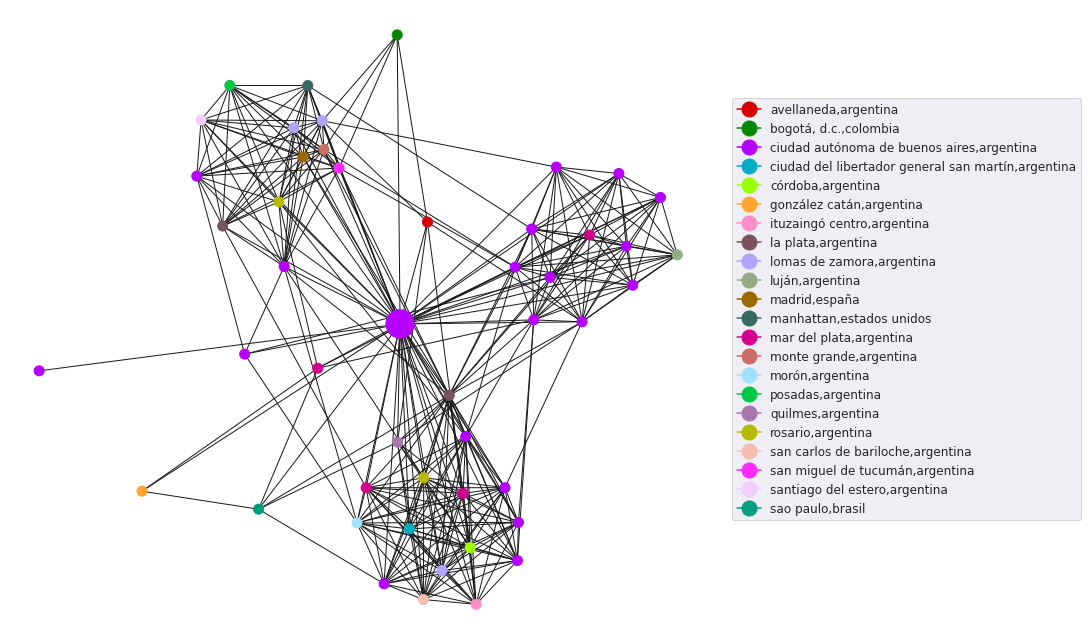

In [193]:
#cities_used = np.unique([cities_true[node] for node in ego_net])
legends = []

for city in cities_graph:
    legends.append(Line2D([0], [0], marker='o', color=colors[city], label=city, markersize=15))
    #legends.append(mpatches.Patch(color=colors[city], label=city))

f, ax = plt.subplots(figsize=(15, 15))

#options = {"node_size": 1000, "node_color": [color_map[node_id]]}

nx.draw(ego_net, node_color=color_map, with_labels=False, ax=ax, node_size=node_size)#, pos=pos)

#nx.draw_networkx_nodes(ego_net, nodelist=[node_id], pos=pos, **options)
plt.legend(handles=legends, bbox_to_anchor=(1, 0.6), loc="center right", fontsize=12, 
           bbox_transform=plt.gcf().transFigure)
plt.subplots_adjust(left=0.0, bottom=0.3, right=0.65)

plt.show()

In [194]:
ego_nodes = list(ego_net.nodes)

In [195]:
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42
)

node2vec_tsne = tsne.fit(node2vec_pec_embs[ego_nodes])

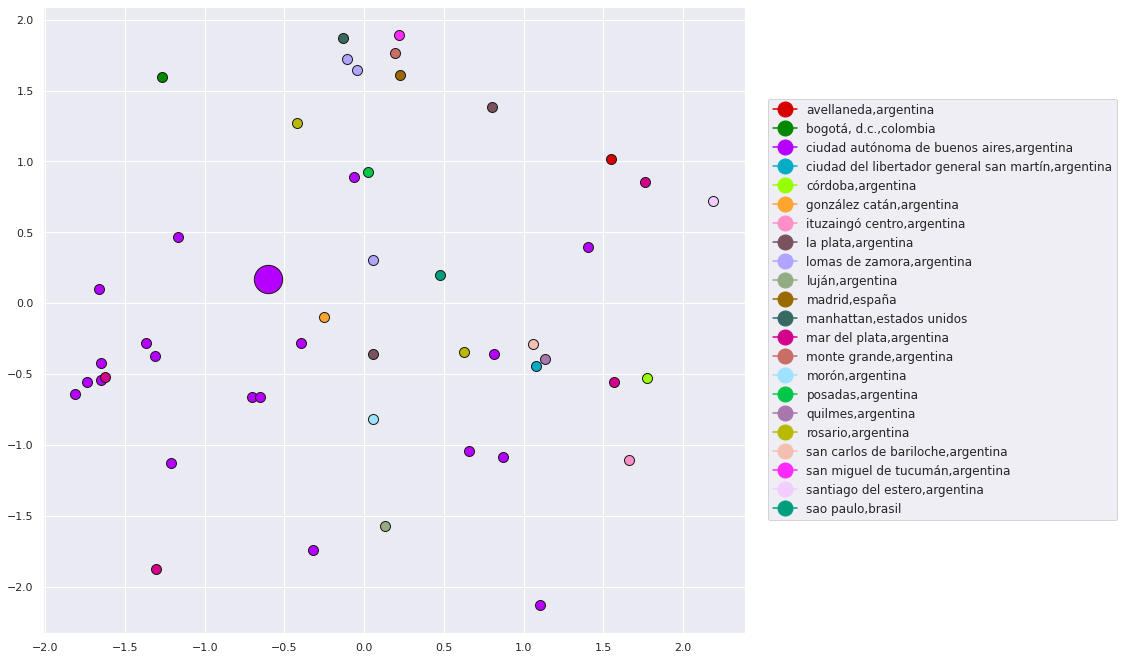

In [196]:
fig, ax = plt.subplots(figsize=(15, 15))

legends = []

for city in cities_graph:
    legends.append(Line2D([0], [0], marker='o', color=colors[city], label=city, markersize=15))
    
for target in cities_graph:
    ix = np.where(np.array(cities_nodes) == target)
    
    ax.scatter(
        node2vec_tsne[:, 0][ix],
        node2vec_tsne[:, 1][ix],
        color=colors[target],
        #label=target,
        s=100,
        alpha=1,
        edgecolor="k"
    )

pos_node = np.where(np.array(ego_nodes) == node_id)[0][0]
    
ax.scatter(
    node2vec_tsne[:, 0][pos_node],
    node2vec_tsne[:, 1][pos_node],
    color=color_map[pos_node],
    #label=target,
    s=800,
    alpha=1,
    edgecolor="k"
)     

#ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")
plt.legend(handles=legends, bbox_to_anchor=(1, 0.6), loc="center right", fontsize=12, 
           bbox_transform=plt.gcf().transFigure)
plt.subplots_adjust(left=0.0, bottom=0.3, right=0.65)

plt.show()

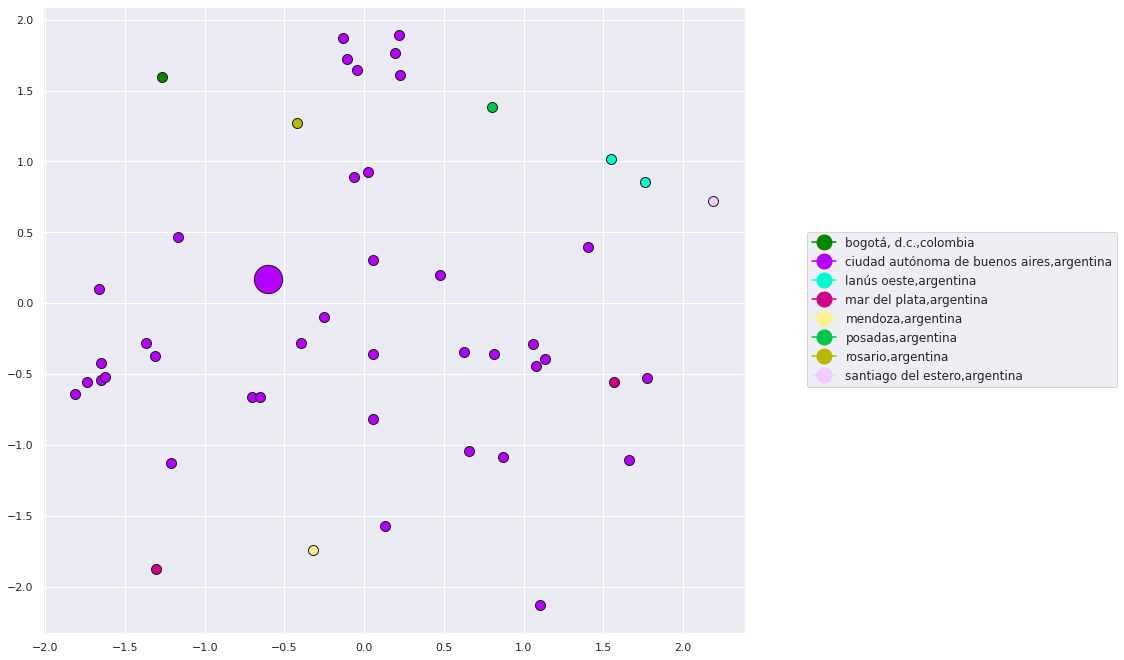

In [197]:
fig, ax = plt.subplots(figsize=(15, 15))

legends = []

for city in cities_log:
    legends.append(Line2D([0], [0], marker='o', color=colors[city], label=city, markersize=15))
    
for target in cities_log:
    ix = np.where(np.array(cities_log_nodes) == target)

    ax.scatter(
        node2vec_tsne[:, 0][ix],
        node2vec_tsne[:, 1][ix],
        color=colors[target],
        #label=target,
        s=100,
        alpha=1,
        edgecolor="k"
    )
    
pos_node = np.where(np.array(ego_nodes) == node_id)[0][0]
    
ax.scatter(
    node2vec_tsne[:, 0][pos_node],
    node2vec_tsne[:, 1][pos_node],
    color=color_log_map[pos_node],
    #label=target,
    s=800,
    alpha=1,
    edgecolor="k"
)   

#ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")
plt.legend(handles=legends, bbox_to_anchor=(1, 0.6), loc="center right", fontsize=12, 
           bbox_transform=plt.gcf().transFigure)
plt.subplots_adjust(left=0.0, bottom=0.3, right=0.65)

plt.show()

Para GraphTSNE

In [198]:
vector_of_col_mentions

<37146x37146 sparse matrix of type '<class 'numpy.uint8'>'
	with 9048006 stored elements in Compressed Sparse Row format>

In [199]:
vector_of_feats = sparse.csr_matrix(content_preds)
vector_of_feats

NameError: name 'content_preds' is not defined

In [676]:
encoder_ = LabelEncoder()

cities_number = encoder_.fit_transform(cities_true)
cities_number

array([16, 16, 16, ..., 72, 72, 72])

In [677]:
data_to_graphtsne = [vector_of_feats, cities_number, vector_of_col_mentions]

In [680]:
with open('../GraphTSNE/data/cora/twitter_arg_exact_full.pkl', 'wb') as handle:
    pickle.dump(data_to_graphtsne, handle, protocol=pickle.HIGHEST_PROTOCOL)